Baseline models performance (non-parametric, PNNs, AffinePNN) on both `Hepmass` and `Dataset`.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

from typing import List, Tuple, Dict, Union

%matplotlib inline
sns.set()

In [2]:
from script import free_mem, set_random_seed
from script import utils 

from script.datasets import Hepmass, Dataset
from script.models import NN, PNN, AffinePNN, DcPNN

from script.evaluation import hepmass as hepmass_eval
from script.evaluation import auc_with_error, auc_vs_no_mass, auc_vs_mass_no_features, \
                              metric_with_error, plot_significance

In [3]:
set_random_seed(42)

Random seed 42 set.


In [4]:
BATCH_SIZE = 100
VAL_SPLIT = 0.25
NUM_EPOCHS = 20

In [5]:
def _get_compiled_model(cls, units: list = None, save: str = None, **kwargs):
    units = [300, 150, 100, 50] if units is None else units
    
    if isinstance(data, Hepmass):
        features_shape = (data.features.shape[-1],)
    else:
        features_shape = (data.train_features.shape[-1],)
    
    model = cls(input_shapes=dict(m=(1,), x=features_shape), 
                units=units, **kwargs)

    model.compile(metrics=['binary_accuracy', metrics.AUC(name='auc'), 
                           metrics.Precision(), metrics.Recall()])

    if isinstance(save, str):
        checkpoint = ModelCheckpoint('weights/' + save + '/weights-{epoch:02d}-{val_auc:.3f}',
                                     save_weights_only=True, monitor='val_auc',
                                     mode='max', save_best_only=True)
        return model, checkpoint
    
    return model

In [6]:
def get_compiled_non_parametric(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=NN, units=units, save=save, **kwargs)


def get_compiled_pnn(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=PNN, units=units, save=save, **kwargs)
 

def get_compiled_affine_pnn(units=None, save=None, **kwargs):
    return _get_compiled_model(cls=AffinePNN, units=units, save=save, **kwargs)

In [26]:
def compare_plot(mass: list, title=None, size=(10, 9), legend='best', x_label='mass (GeV)',
                 y_label='AUC', **kwargs):
    if isinstance(size, tuple):
        plt.figure(figsize=size)
    
    for key, auc in kwargs.items():
        plt.plot(mass, auc, marker='o', label=f'{key}: {np.round(np.mean(auc), 2)}')
        
    plt.title(title or 'AUC Comparison')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=legend)
    plt.show()

In [39]:
def plot_mass_reliance(model, dataset, auc=None, auc_index=2, name='pNN', size=(12, 9), 
                       legend='best', **kwargs):
    from script.datasets import Hepmass,  Dataset

    if isinstance(dataset, Hepmass):
        mass = dataset.unique_mass
    else:
        mass = dataset.current_mass_intervals

    if auc is None:
        auc = []
        compute_auc = True
    else:
        compute_auc = False

    # compute auc on zeroed features
    zero_auc = []

    for i, m in enumerate(mass):
        x, y = dataset.get_by_mass(m, **kwargs)

        if compute_auc:
            score = model.evaluate(x=x, y=y, batch_size=128, verbose=0)
            auc.append(round(score[auc_index], 4))

        # zero features, then evaluate
        x['x'] = np.zeros_like(x['x'])

        score = model.evaluate(x=x, y=y, batch_size=128, verbose=0)
        zero_auc.append(round(score[auc_index], 4))

    # compute metric
    metric =  200 * np.abs(np.array(zero_auc) / np.array(auc) - 0.5)

    # plot
    plt.figure(figsize=size)

    plt.title(f'Mass Reliance ({name})')
    plt.xlabel('Mass (GeV)')
    plt.ylabel('%')

    label = r'$m_{r}$' + f': {np.round(np.mean(metric), 1)}%'

    if isinstance(dataset, Hepmass):
        plt.plot(mass, metric, marker='o', label=label)
    else:
        plt.plot(dataset.unique_signal_mass, metric, marker='o', label=label)

    plt.legend(loc=legend)
    plt.show()
    
    return metric

## Hepmass

In [15]:
def plot_significance_hep(model, dataset: Hepmass, bins=20, name='Model', 
                          sample_frac=None, size=14, ams_eq=2):
    def safe_div(a, b):
        if b == 0.0:
            return 0.0
    
        return a / b

    fig, axes = plt.subplots(ncols=3, nrows=2)
    axes = np.reshape(axes, newshape=[-1])
    
    fig.set_figwidth(size)
    fig.set_figheight(size // 2)
    
    plt.suptitle(f'[HEPMASS] {name}\'s Output Distribution + Significance', 
                 y=1.02, verticalalignment='top')
    
    for i, mass in enumerate(dataset.unique_mass + [None]):
        ax = axes[i]
        
        if mass is None:
            x, y = dataset.get(sample=sample_frac)
            title = 'Total'
        else:
            x, y = dataset.get_by_mass(mass, sample=sample_frac)
            title = f'{int(round(mass))} GeV'
            
        out = model.predict(x, batch_size=128, verbose=0)
        out = np.asarray(out)
        
        sig_mask = y == 1.0
        bkg_mask = y == 0.0
        
        cuts = np.linspace(0.0, 1.0, num=bins)
        ams = []
        
        bx = ax.twinx()
        
        ax.hist(out[sig_mask], bins=bins, alpha=0.55, label='sig', color='blue', edgecolor='blue')
        ax.hist(out[bkg_mask], bins=bins, alpha=0.7, label='bkg', color='red', histtype='step', 
                          hatch='//', linewidth=2, edgecolor='red')
        
        for i in range(len(cuts) - 1):
            lo, up = cuts[i], cuts[i + 1]
            
            cut_mask = (out > lo) & (out <= up)
            
            # select signals and bkg (as true positives of both classes)
            s = out[sig_mask & cut_mask].shape[0]
            b = out[bkg_mask & cut_mask].shape[0]
            
            # compute approximate median significance (AMS)
            if ams_eq == 1:
                val = np.sqrt(2 * ((s + b) * np.log(1 + safe_div(s, b)) - s))
            elif ams_eq == 2:
                val = safe_div(s, np.sqrt(s + b))
            else:
                val = safe_div(s, np.sqrt(b))
            
            ams.append(val)
        
        k = np.argmax(ams)
        
        bx.grid(False)
        bx.plot(cuts, [0.0] + ams, color='g', label='Significance')
        
        ax.axvline(x=cuts[k + 1], linestyle='--', linewidth=2, color='g',
                   label=f'{round(cuts[k + 1], 1)}: {round(ams[k], 1)}')
        
        bx.set_ylabel('Significance')
        ax.set_title(title)
        ax.set_xlabel('Probability')
        ax.set_ylabel('Num. Events')
        
        ax.legend(loc='best')
    
    fig.tight_layout()


In [16]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH)

free_mem()
x_train, y_train = data.get()

loading...
fitting feature scaler..
fitting mass scaler..
dataset loaded.


In [17]:
test_data = Hepmass(x_scaler=data.x_scaler, m_scaler=data.m_scaler)
test_data.load(path=Hepmass.TEST_PATH, fit_scaler=False)

loading...
dataset loaded.


In [9]:
num_features = len(data.columns['feature'])
hep_features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        hep_features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    hep_features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [13]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn')
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          8400        x[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          15100       dense_1[0][0]                    
________________________________________________________________________________________

In [10]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
              epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 82.28, AUC: 90.25

Epoch 1/20
52500/52500 [==============================] - 175s 3ms/step - loss: 0.3344 - binary_accuracy: 0.8171 - auc: 0.8931 - precision_1: 0.8564 - recall_1: 0.7622 - lr: 0.0010 - grad-norm: 0.5083 - weight-norm: 27.3606 - reg-losses: 0.0000e+00 - val_loss: 0.4001 - val_binary_accuracy: 0.8199 - val_auc: 0.8967 - val_precision_1: 0.8702 - val_recall_1: 0.7520
Epoch 2/20
52500/52500 [==============================] - 170s 3ms/step - loss: 0.3812 - binary_accuracy: 0.8197 - auc: 0.8966 - precision_1: 0.8595 - recall_1: 0.7644 - lr: 0.0010 - grad-norm: 0.3933 - weight-norm: 34.7094 - reg-losses: 0.0000e+00 - val_loss: 0.3985 - val_binary_accuracy: 0.8201 - val_auc: 0.8974 - val_precision_1: 0.8546 - val_recall_1: 0.7714
Epoch 3/20
52500/52500 [==============================] - 173s 3ms/step - loss: 0.3053 - binary_accuracy: 0.8208 - auc: 0.8981 - precision_1: 0.8612 - recall_1: 0.7651 - lr: 0.0010 - grad-norm: 0.3873 - weight-norm: 40.7445 - reg-losses: 0.0000e+00 - val_loss: 0.3961 - 

In [14]:
nn.load_weights('weights/hepmass/baseline-nn/weights-18-0.902')

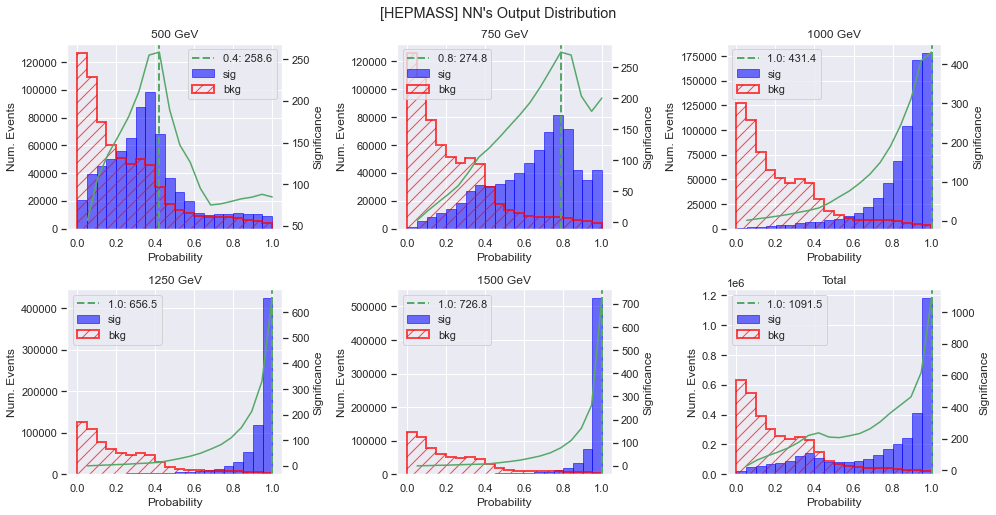

In [90]:
plot_significance_hep(nn, data, name='NN')

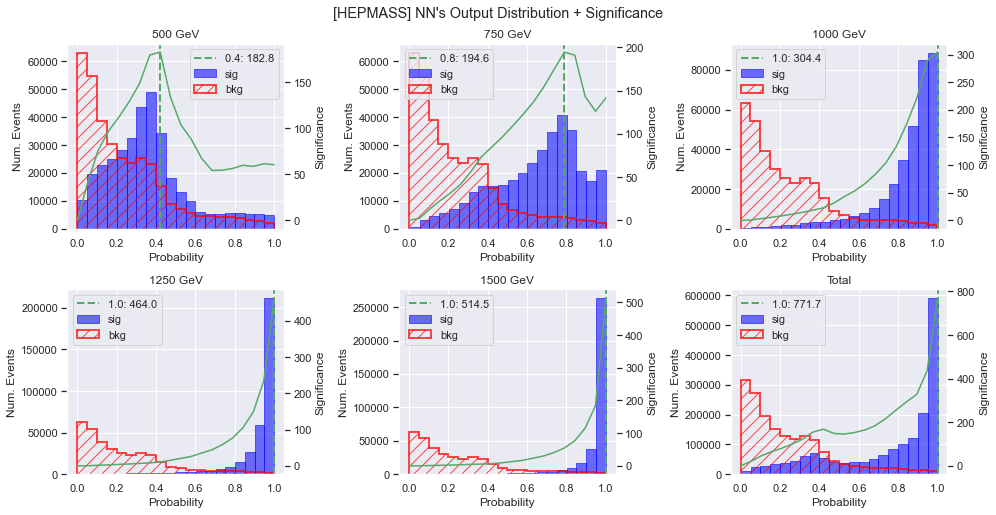

In [15]:
plot_significance_hep(nn, test_data, name='NN')

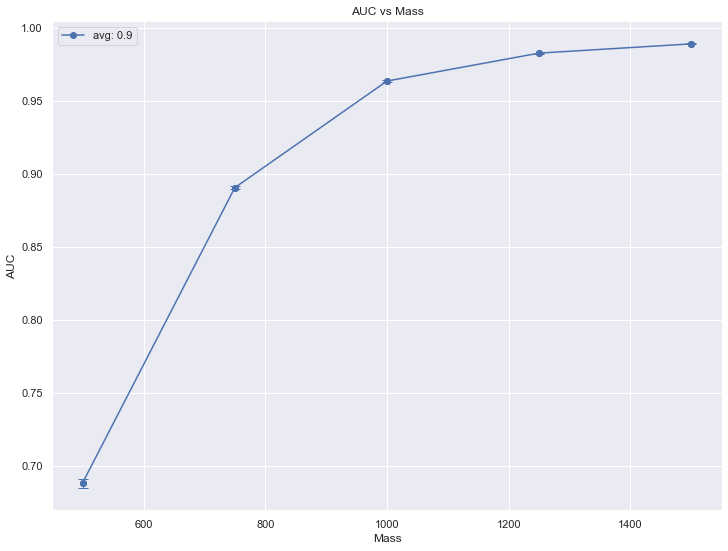

array([0.68872, 0.89053, 0.96337, 0.98248, 0.98881])

In [16]:
hepmass_eval.auc_with_error(nn, data, silent=True)

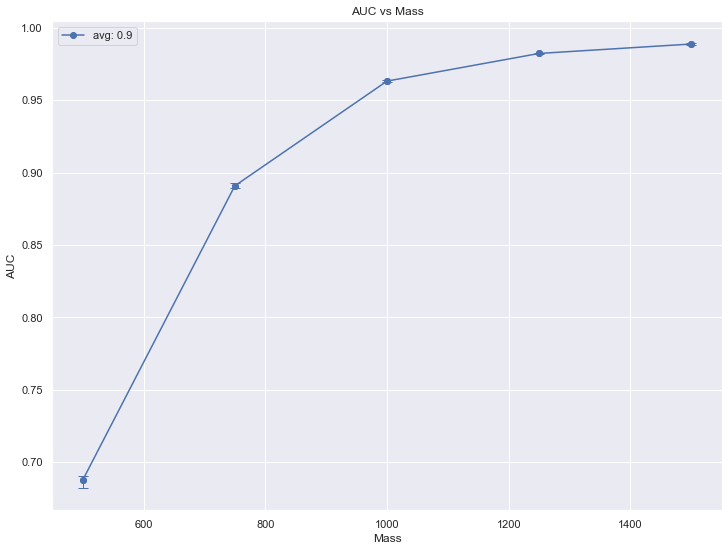

array([0.68756, 0.89083, 0.96307, 0.98217, 0.98869])

In [17]:
hepmass_eval.auc_with_error(nn, test_data, silent=True)

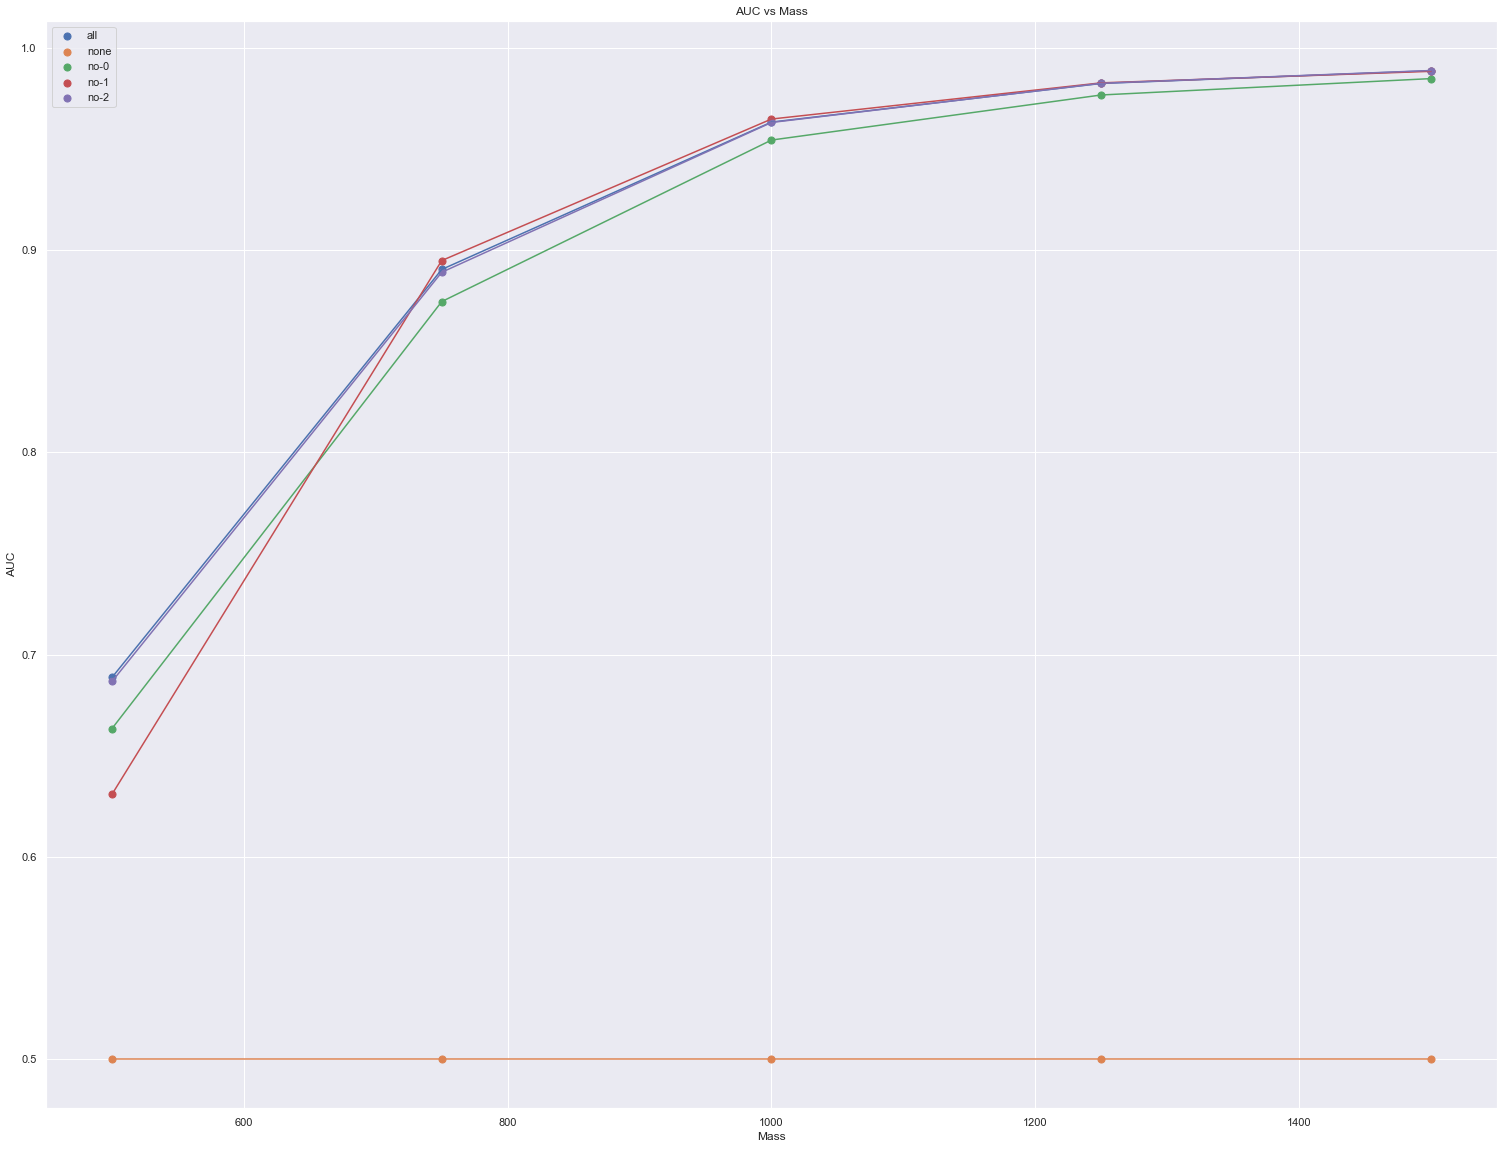

In [11]:
_ = hepmass_eval.auc_vs_mass_no_features(nn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### PNN

In [18]:
pnn, checkpoint = get_compiled_pnn(save='hepmass/baseline-pnn')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 300)          8700        concatenate[0][0]     

In [24]:
_ = pnn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.21 (+6%), AUC: 95.68 (+5%)

Epoch 1/20
52500/52500 [==============================] - 180s 3ms/step - loss: 0.2801 - binary_accuracy: 0.8655 - auc: 0.9466 - precision_2: 0.8462 - recall_2: 0.8933 - lr: 0.0010 - grad-norm: 0.7167 - weight-norm: 34.0381 - reg-losses: 0.0000e+00 - val_loss: 0.2770 - val_binary_accuracy: 0.8737 - val_auc: 0.9518 - val_precision_2: 0.8497 - val_recall_2: 0.9081
Epoch 2/20
52500/52500 [==============================] - 176s 3ms/step - loss: 0.2825 - binary_accuracy: 0.8747 - auc: 0.9522 - precision_2: 0.8571 - recall_2: 0.8994 - lr: 0.0010 - grad-norm: 0.5817 - weight-norm: 49.0340 - reg-losses: 0.0000e+00 - val_loss: 0.2708 - val_binary_accuracy: 0.8768 - val_auc: 0.9537 - val_precision_2: 0.8651 - val_recall_2: 0.8929
Epoch 3/20
52500/52500 [==============================] - 179s 3ms/step - loss: 0.2526 - binary_accuracy: 0.8770 - auc: 0.9536 - precision_2: 0.8596 - recall_2: 0.9013 - lr: 0.0010 - grad-norm: 0.5389 - weight-norm: 59.8712 - reg-losses: 0.0000e+00 - val_loss: 0.2708 - 

In [19]:
utils.load_from_checkpoint(pnn, path='hepmass/baseline-pnn')

Loaded from "weights\hepmass/baseline-pnn\weights-18-0.957"


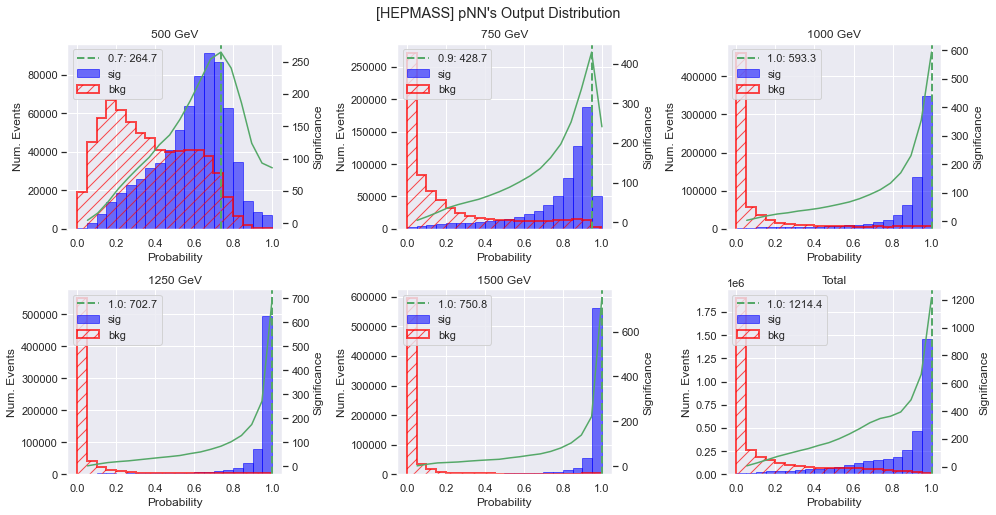

In [93]:
plot_significance_hep(pnn, data, name='pNN')

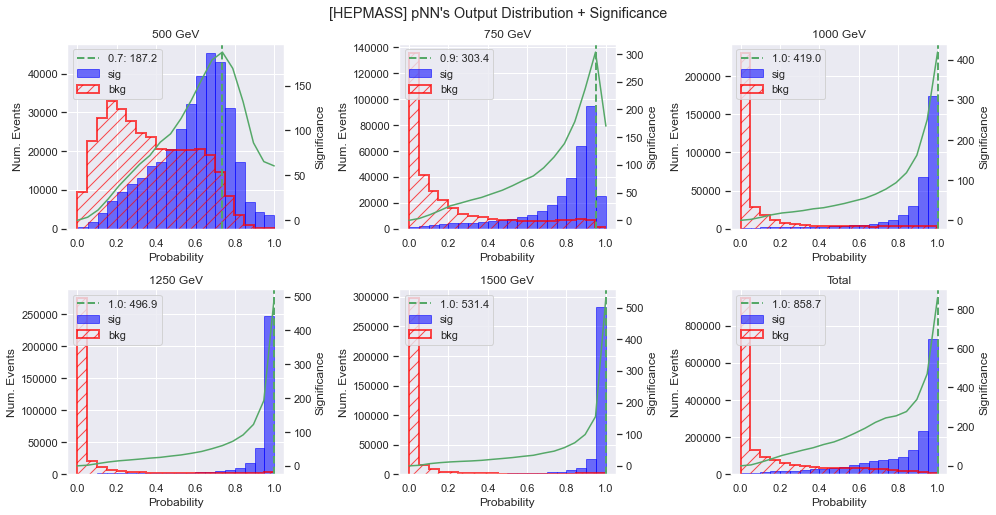

In [20]:
plot_significance_hep(pnn, test_data, name='pNN')

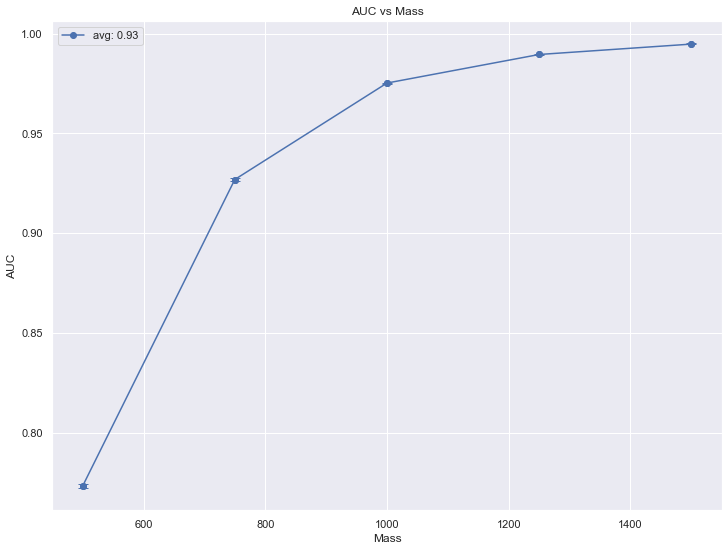

array([0.77339, 0.9269 , 0.97516, 0.98949, 0.9947 ])

In [21]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

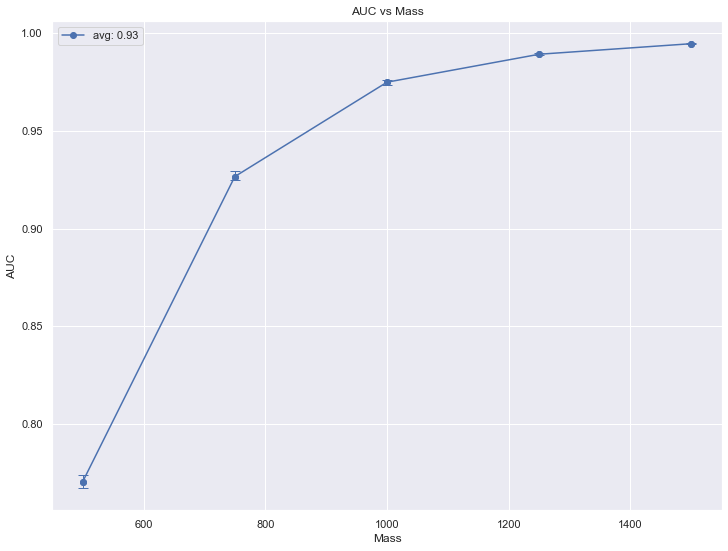

array([0.77042, 0.92662, 0.97489, 0.98917, 0.99457])

In [22]:
hepmass_eval.auc_with_error(pnn, test_data, silent=True)

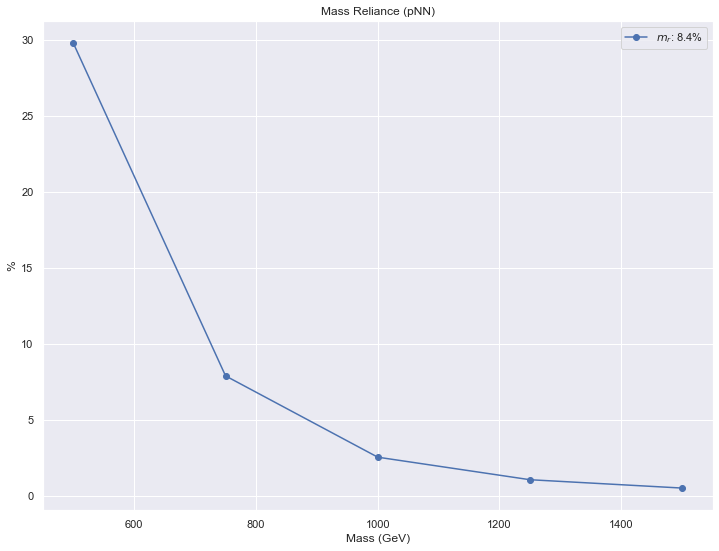

array([29.8026999 ,  7.9214332 ,  2.57462304,  1.09179135,  0.54293183])

In [22]:
plot_mass_reliance(pnn, test_data)

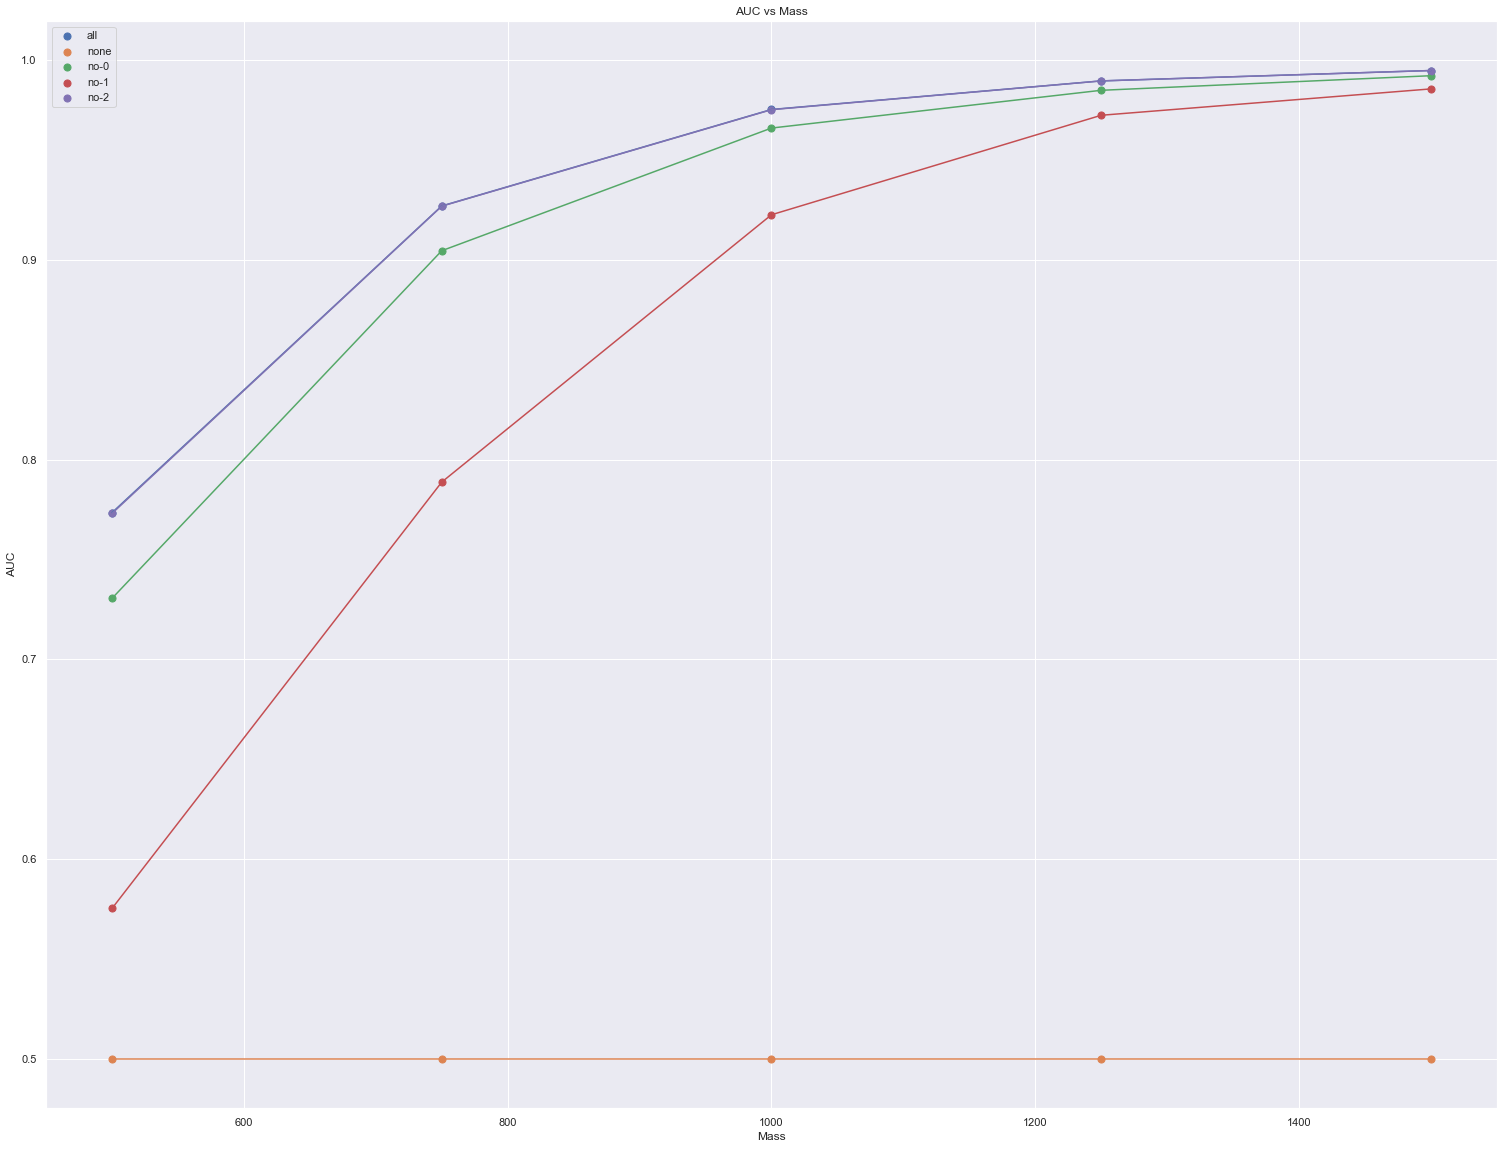

In [17]:
_ = hepmass_eval.auc_vs_mass_no_features(pnn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### AffinePNN

In [23]:
affine, checkpoint = get_compiled_affine_pnn(save='hepmass/baseline-affine', 
                                             track_mass_reliance=True)
affine.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 300)          8400        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_12[0][0]                   
                                                                 m[0][0]               

In [13]:
_ = affine.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
               epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.39 (+0.2%), AUC: 95.78 (+0.1%) 

Epoch 1/20
52500/52500 [==============================] - 277s 5ms/step - loss: 0.2504 - binary_accuracy: 0.8595 - auc: 0.9433 - precision_1: 0.8391 - recall_1: 0.8897 - cls-loss: 0.2986 - lr: 0.0010 - grad-norm: 0.5752 - weight-norm: 42.1305 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0667 - val_loss: 0.2811 - val_binary_accuracy: 0.8713 - val_auc: 0.9502 - val_precision_1: 0.8498 - val_recall_1: 0.9021
Epoch 2/20
52500/52500 [==============================] - 278s 5ms/step - loss: 0.3054 - binary_accuracy: 0.8730 - auc: 0.9511 - precision_1: 0.8551 - recall_1: 0.8983 - cls-loss: 0.2782 - lr: 0.0010 - grad-norm: 0.5249 - weight-norm: 59.6165 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0536 - val_loss: 0.2717 - val_binary_accuracy: 0.8766 - val_auc: 0.9534 - val_precision_1: 0.8556 - val_recall_1: 0.9062
Epoch 3/20
52500/52500 [==============================] - 277s 5ms/step - loss: 0.2647 - binary_accuracy: 0.8767 - auc: 0.

In [24]:
utils.load_from_checkpoint(affine, 'hepmass/baseline-affine')

Loaded from "weights\hepmass/baseline-affine\weights-19-0.958"


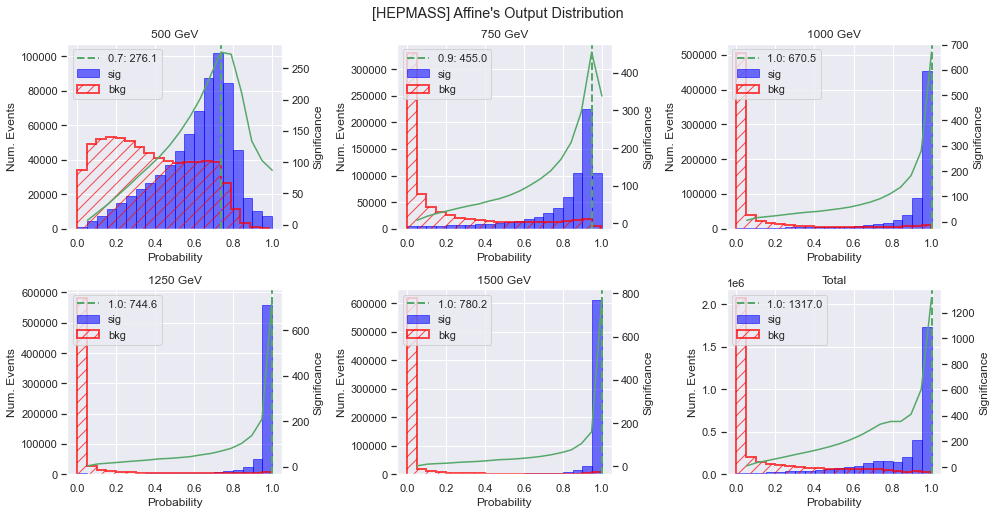

In [96]:
plot_significance_hep(affine, data, name='Affine')

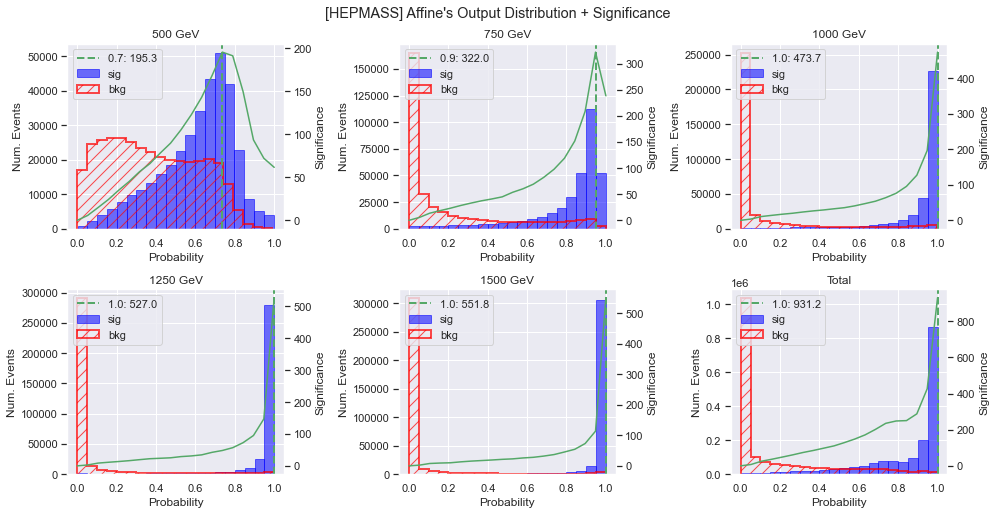

In [25]:
plot_significance_hep(affine, test_data, name='Affine')

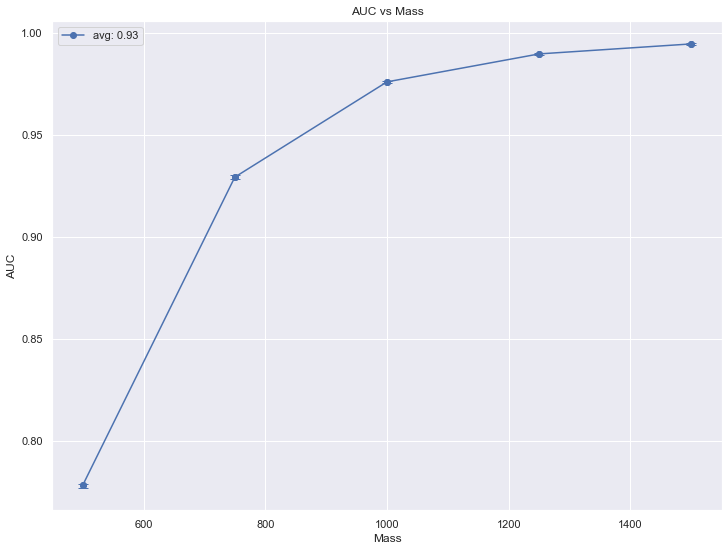

array([0.77829, 0.9294 , 0.97608, 0.98978, 0.99465])

In [26]:
hepmass_eval.auc_with_error(affine, data, silent=True)

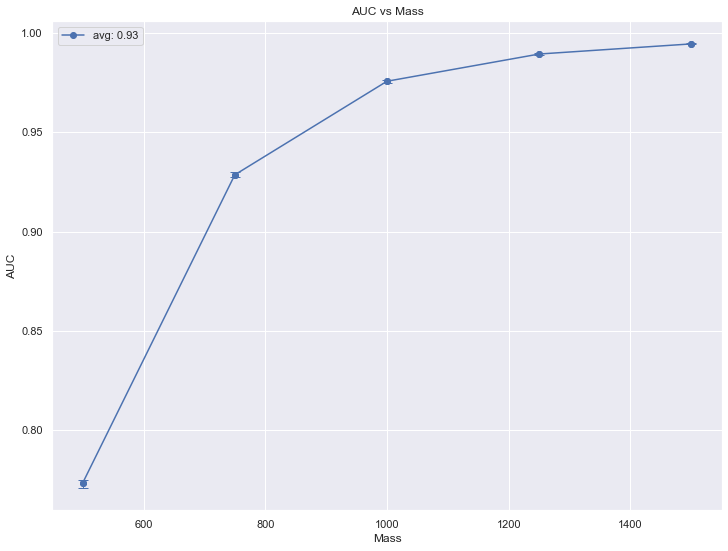

array([0.77343, 0.92865, 0.97566, 0.98941, 0.99449])

In [27]:
hepmass_eval.auc_with_error(affine, test_data, silent=True)

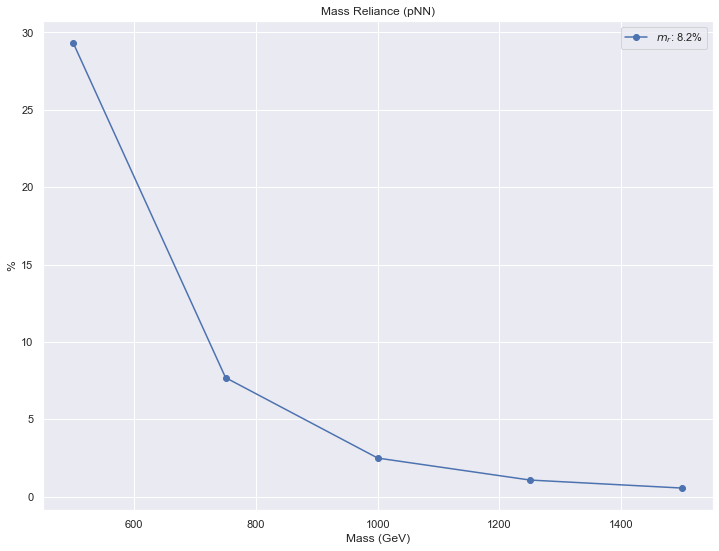

array([29.29919834,  7.68899418,  2.49051963,  1.07135638,  0.55304173])

In [25]:
plot_mass_reliance(affine, test_data)

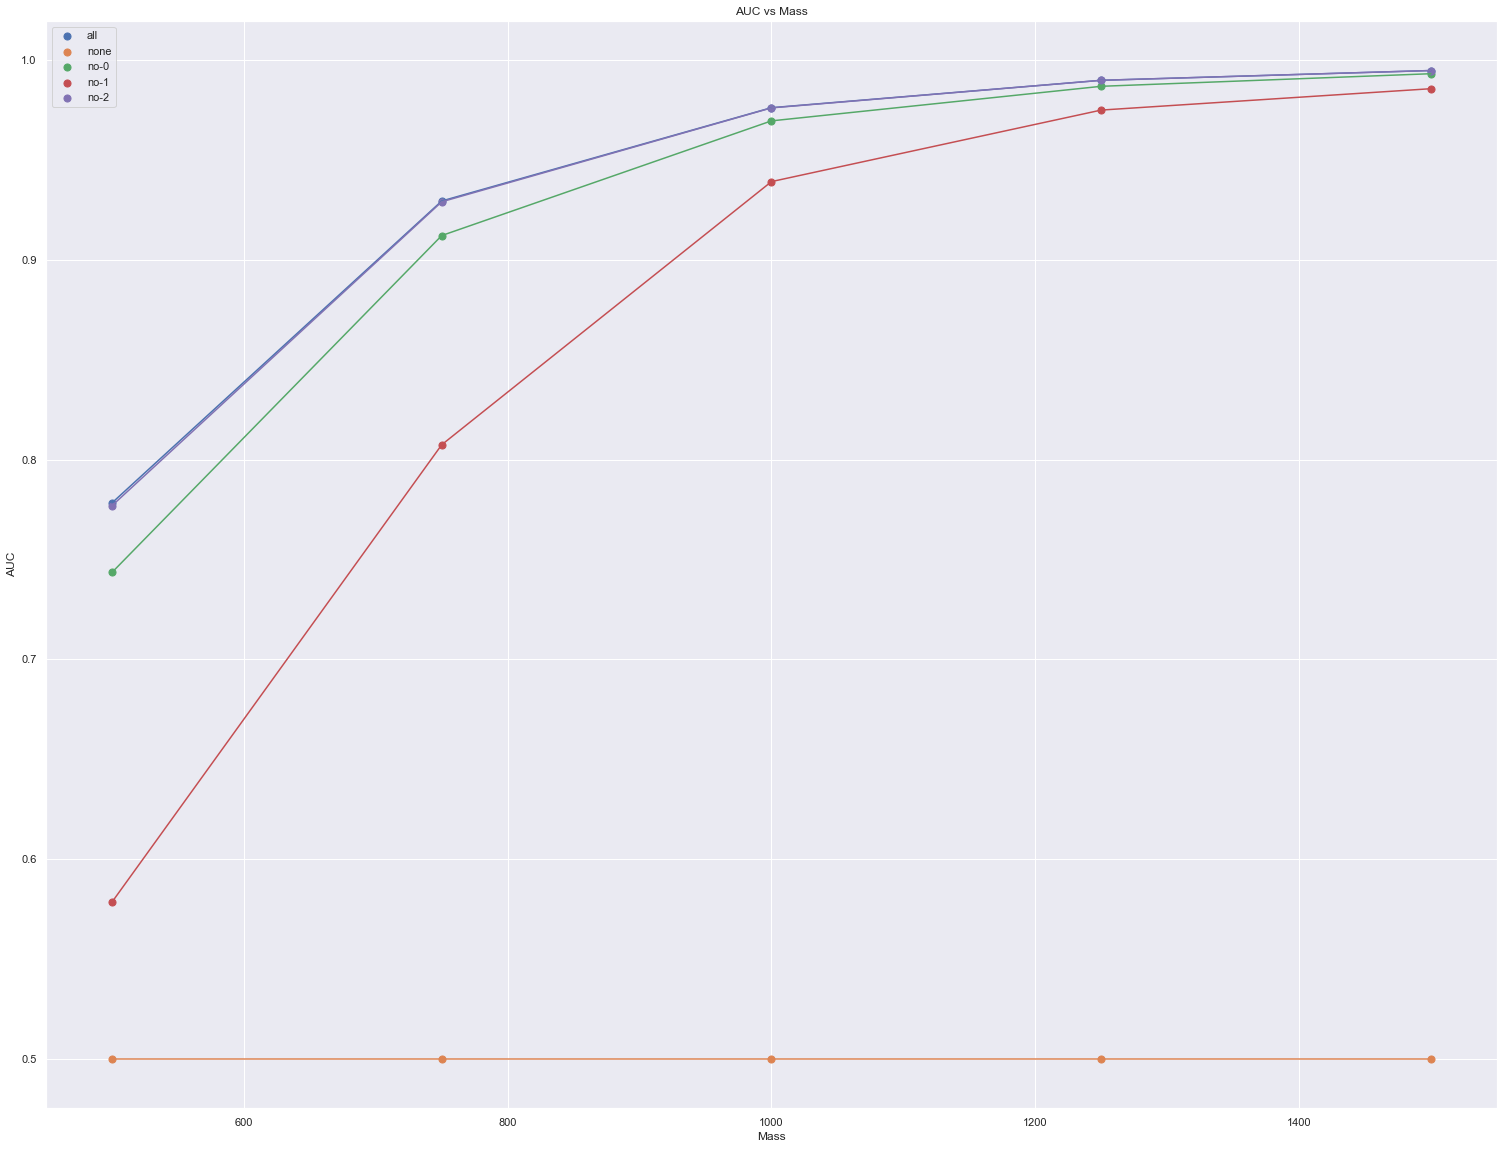

In [22]:
_ = hepmass_eval.auc_vs_mass_no_features(affine, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

* The **feature reliance** of both pNN and AffinePNN is very similar: telling that they learned to exploit features in the same way?

#### DC-PNN

In [28]:
model, checkpoint = utils.get_compiled_model(cls=DcPNN, data=data, track_mass_reliance=True,
                                             lr=3e-4, save='hepmass/baseline-dc-pnn')
model.summary()

Model: "DC-pNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 28)           0           x[0][0]                          
                                                                 m[0][0]                          
__________________________________________________________________________________________________
dense-0 (Dense)                 (None, 300)          8700        concat[0][0]                

In [12]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.37, AUC: 95.76

Epoch 1/20
52500/52500 [==============================] - 338s 6ms/step - loss: 0.2643 - binary_accuracy: 0.8525 - auc: 0.9390 - precision: 0.8309 - recall: 0.8853 - cls-loss: 0.3087 - lr: 3.0000e-04 - grad-norm: 0.7992 - weight-norm: 36.1931 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0680 - val_loss: 0.2876 - val_binary_accuracy: 0.8666 - val_auc: 0.9477 - val_precision: 0.8463 - val_recall: 0.8960
Epoch 2/20
52500/52500 [==============================] - 310s 6ms/step - loss: 0.3065 - binary_accuracy: 0.8681 - auc: 0.9484 - precision: 0.8524 - recall: 0.8904 - cls-loss: 0.2856 - lr: 3.0000e-04 - grad-norm: 0.9208 - weight-norm: 42.1183 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0370 - val_loss: 0.2800 - val_binary_accuracy: 0.8718 - val_auc: 0.9506 - val_precision: 0.8539 - val_recall: 0.8971
Epoch 3/20
52500/52500 [==============================] - 271s 5ms/step - loss: 0.2571 - binary_accuracy: 0.8734 - auc: 0.9515 - p

Epoch 20/20
52500/52500 [==============================] - 260s 5ms/step - loss: 0.2834 - binary_accuracy: 0.8850 - auc: 0.9585 - precision: 0.8689 - recall: 0.9069 - cls-loss: 0.2567 - lr: 3.0000e-04 - grad-norm: 0.6762 - weight-norm: 91.1930 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0639 - val_loss: 0.2603 - val_binary_accuracy: 0.8835 - val_auc: 0.9573 - val_precision: 0.8666 - val_recall: 0.9066


In [29]:
utils.load_from_checkpoint(model, 'hepmass/baseline-dc-pnn')

Loaded from "weights\hepmass/baseline-dc-pnn\weights-16-0.958"


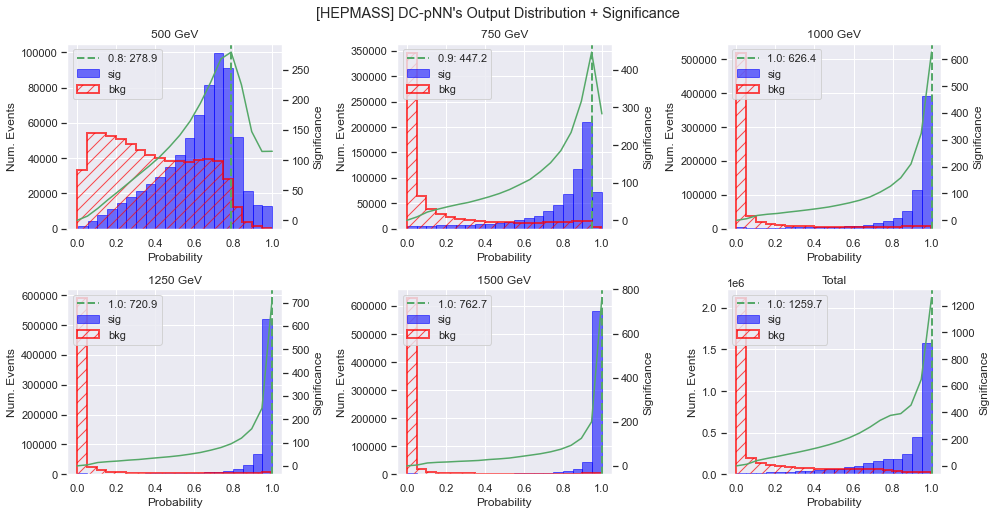

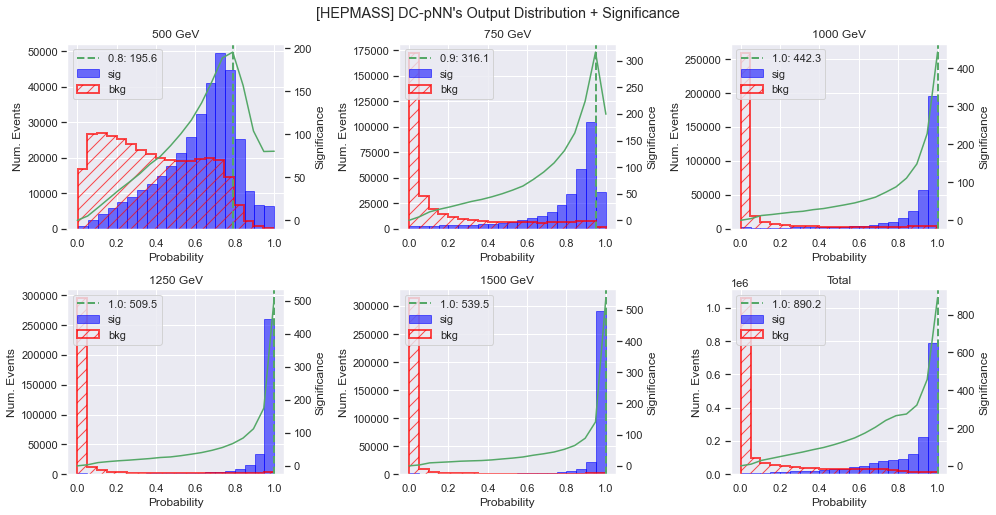

In [16]:
plot_significance_hep(model, data, name='DC-pNN')
plot_significance_hep(model, test_data, name='DC-pNN')

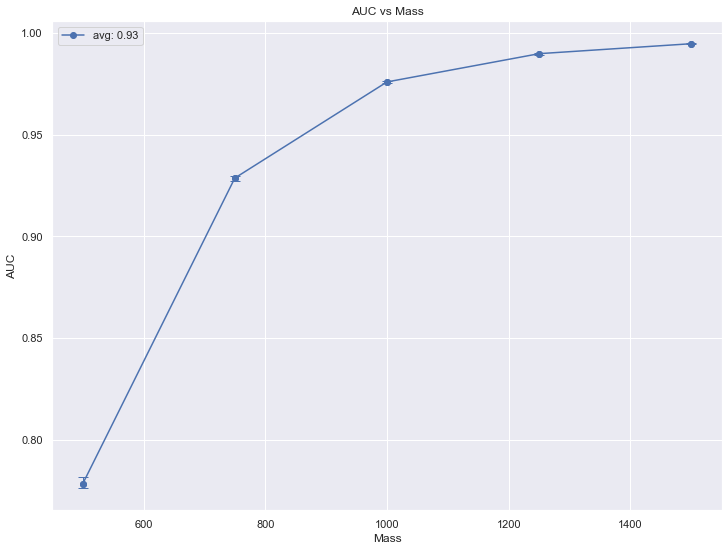

array([0.7782 , 0.92871, 0.976  , 0.98986, 0.9948 ])

In [17]:
hepmass_eval.auc_with_error(model, data, silent=True)

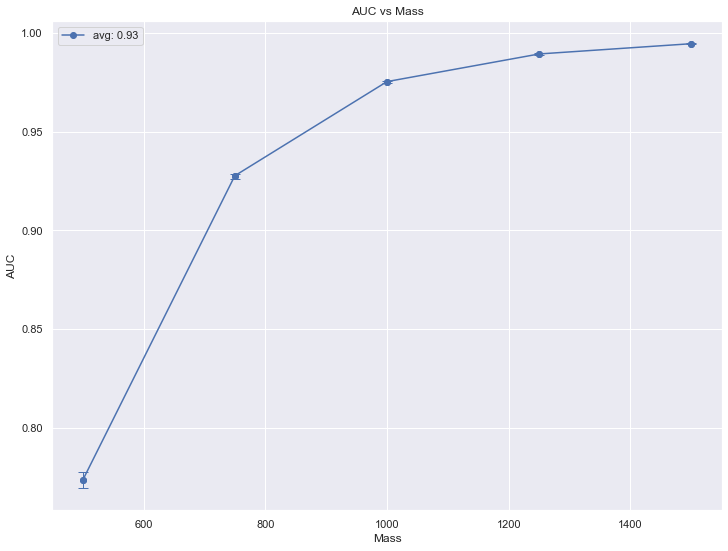

array([0.77345, 0.92766, 0.97542, 0.98939, 0.99455])

In [18]:
hepmass_eval.auc_with_error(model, test_data, silent=True)

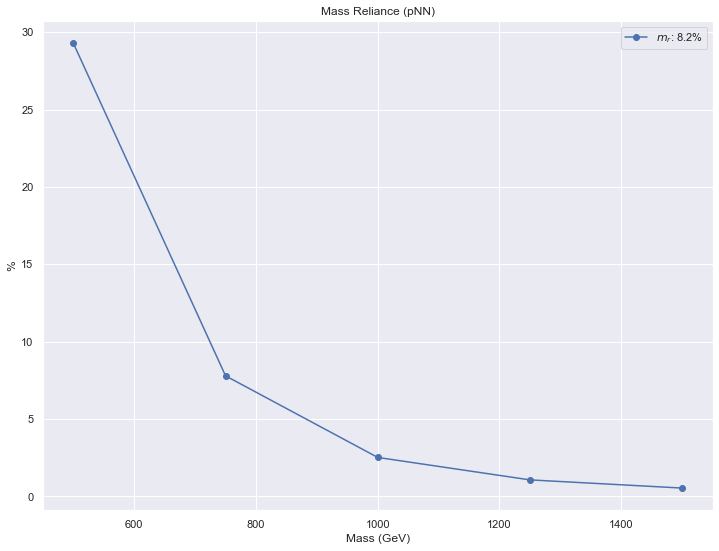

array([29.28248222,  7.79346772,  2.52204224,  1.07135638,  0.54293183])

In [30]:
plot_mass_reliance(model, test_data)

---
AUC comparison:

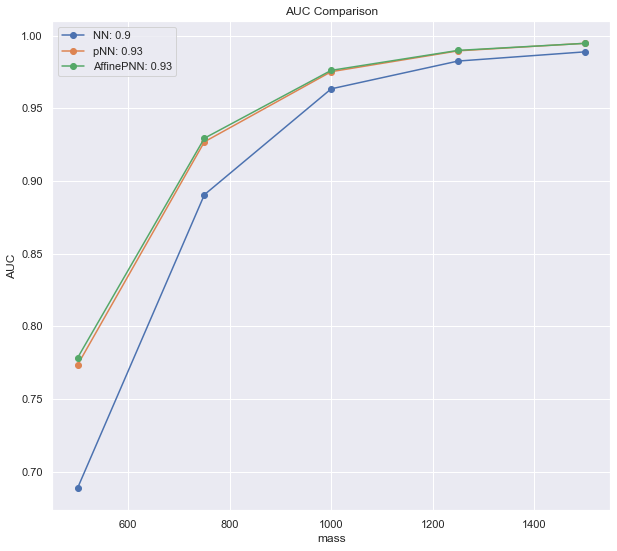

In [18]:
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             NN=[0.68872, 0.89053, 0.96337, 0.98248, 0.98881],
             pNN=[0.7734 , 0.92691, 0.97517, 0.9895 , 0.9947],
             AffinePNN=[0.77828, 0.92939, 0.97609, 0.98981, 0.99466])

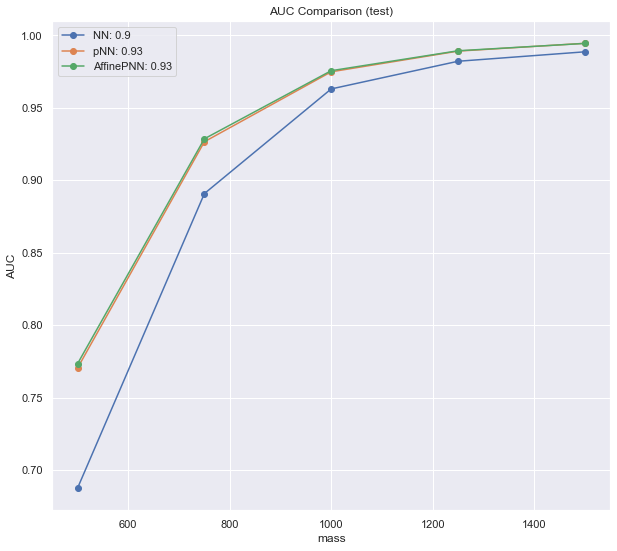

In [20]:
# test
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             title='AUC Comparison (test)',
             NN=[0.68756, 0.89083, 0.96307, 0.98217, 0.98869],
             pNN=[0.77042, 0.92662, 0.97489, 0.98917, 0.99457],
             AffinePNN=[0.77343, 0.92865, 0.97566, 0.98941, 0.99449],
#              DCpNN=[0.77345, 0.92766, 0.97542, 0.98939, 0.99455]
            )

Mass reliance comparison:

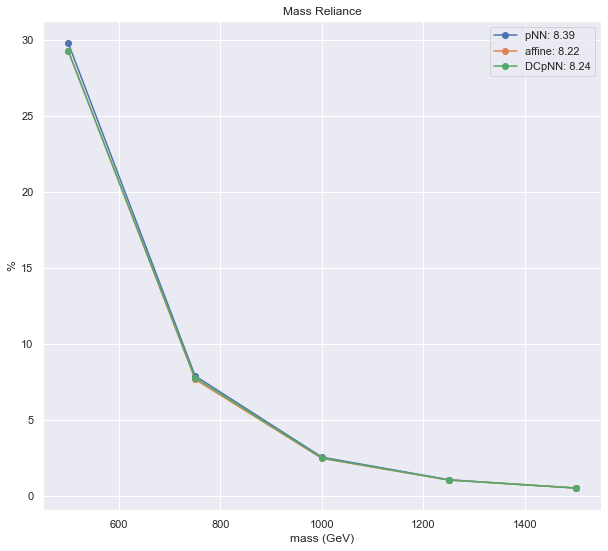

In [32]:
compare_plot(data.unique_mass, title='Mass Reliance', y_label='%',
             pNN=[29.8026999 ,  7.9214332 ,  2.57462304,  1.09179135,  0.54293183],
             affine=[29.29919834,  7.68899418,  2.49051963,  1.07135638,  0.55304173],
             DCpNN=[29.28248222,  7.79346772,  2.52204224,  1.07135638,  0.54293183])

### Robust
Clipped outliers

In [9]:
data = Hepmass(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(path=Hepmass.TRAIN_PATH, robust=True)

free_mem()
x_train, y_train = data.get()

loading...
clipping outliers..
fitting feature scaler..
fitting mass scaler..
dataset loaded.


In [10]:
test_data = Hepmass(x_scaler=data.x_scaler, m_scaler=data.m_scaler)
test_data.load(path=Hepmass.TEST_PATH, fit_scaler=False, robust=True, statistics=data.stats)

loading...
clipping outliers..
dataset loaded.


#### Non-parametric NN

In [11]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn-robust2')

In [10]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn-robust2')

nn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
       epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.52, AUC: 95.48

Epoch 1/20
41016/41016 [==============================] - 182s 4ms/step - loss: 0.2930 - binary_accuracy: 0.8283 - auc: 0.9103 - precision: 0.8483 - recall: 0.7996 - lr: 0.0010 - grad-norm: 0.6071 - weight-norm: 30.3583 - reg-losses: 0.0000e+00 - val_loss: 0.3643 - val_binary_accuracy: 0.8343 - val_auc: 0.9166 - val_precision: 0.8606 - val_recall: 0.7978
Epoch 2/20
41016/41016 [==============================] - 178s 4ms/step - loss: 0.3560 - binary_accuracy: 0.8349 - auc: 0.9170 - precision: 0.8514 - recall: 0.8114 - lr: 0.0010 - grad-norm: 0.5288 - weight-norm: 43.4450 - reg-losses: 0.0000e+00 - val_loss: 0.3592 - val_binary_accuracy: 0.8370 - val_auc: 0.9192 - val_precision: 0.8551 - val_recall: 0.8117
Epoch 3/20
41016/41016 [==============================] - 176s 4ms/step - loss: 0.3188 - binary_accuracy: 0.8373 - auc: 0.9192 - precision: 0.8535 - recall: 0.8145 - lr: 0.0010 - grad-norm: 0.4897 - weight-norm: 53.4038 - reg-losses: 0.0000e+00 - val_loss: 0.3580 - val_binary_accuracy:

In [12]:
utils.load_from_checkpoint(nn, path='hepmass/baseline-nn-robust2')

Loaded from "weights\hepmass/baseline-nn-robust2\weights-19-0.925"


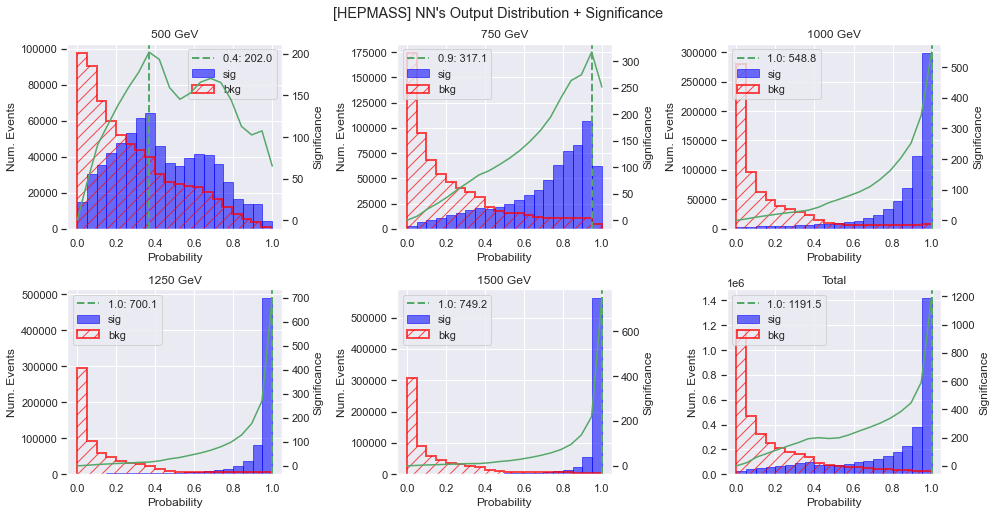

In [12]:
plot_significance_hep(nn, data, name='NN')

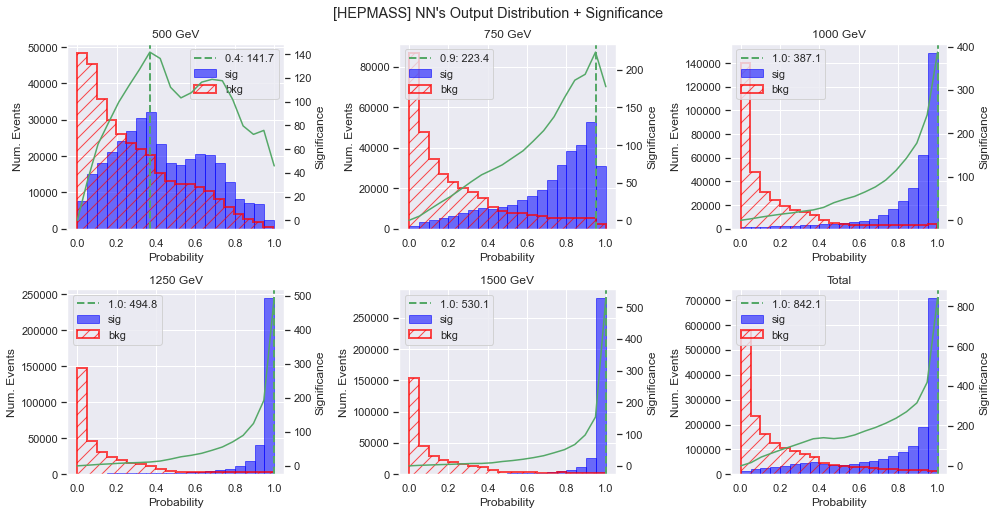

In [13]:
plot_significance_hep(nn, test_data, name='NN')

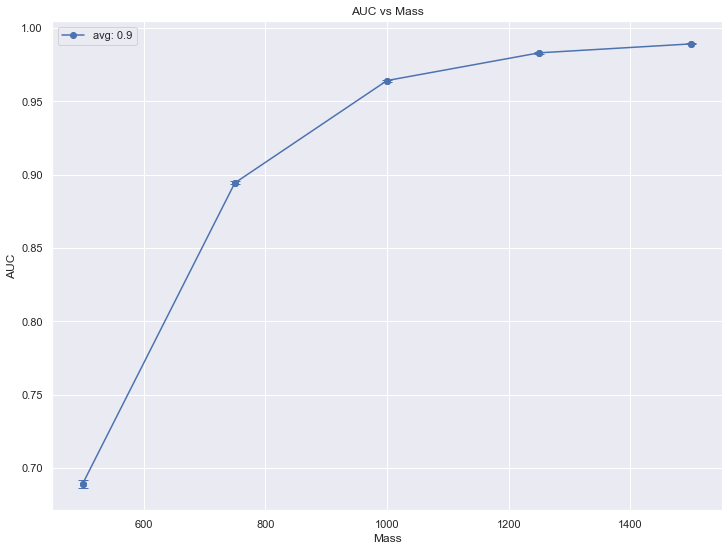

array([0.68926, 0.89443, 0.9642 , 0.98312, 0.98918])

In [13]:
hepmass_eval.auc_with_error(nn, data, silent=True)

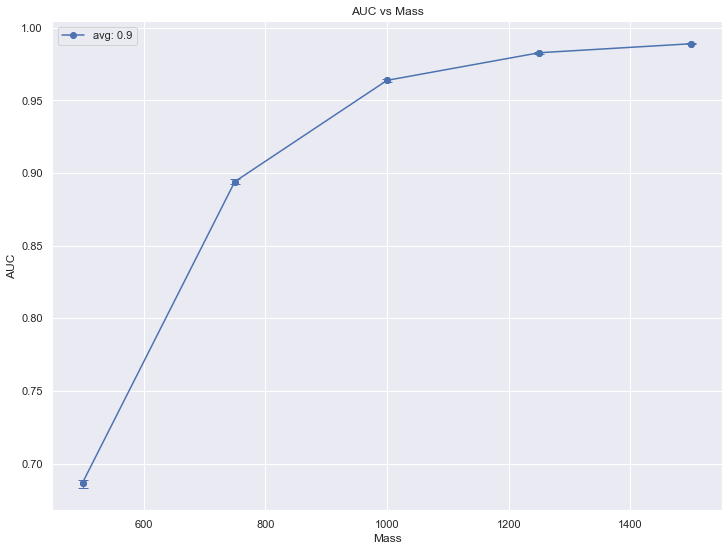

array([0.68703, 0.8941 , 0.96384, 0.98281, 0.98901])

In [14]:
hepmass_eval.auc_with_error(nn, test_data, silent=True)

---

In [32]:
nn, checkpoint = get_compiled_non_parametric(save='hepmass/baseline-nn-robust')

In [15]:
nn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
       epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.52, AUC: 95.48

Epoch 1/20
41016/41016 [==============================] - 191s 5ms/step - loss: 0.2716 - binary_accuracy: 0.8494 - auc: 0.9220 - precision: 0.9112 - recall: 0.7743 - lr: 0.0010 - grad-norm: 1.4980 - weight-norm: 31.1993 - reg-losses: 0.0000e+00 - val_loss: 0.2908 - val_binary_accuracy: 0.8679 - val_auc: 0.9404 - val_precision: 0.9364 - val_recall: 0.7895
Epoch 2/20
41016/41016 [==============================] - 195s 5ms/step - loss: 0.2121 - binary_accuracy: 0.8608 - auc: 0.9321 - precision: 0.9251 - recall: 0.7853 - lr: 0.0010 - grad-norm: 2.0893 - weight-norm: 42.2417 - reg-losses: 0.0000e+00 - val_loss: 0.3267 - val_binary_accuracy: 0.8504 - val_auc: 0.9211 - val_precision: 0.9420 - val_recall: 0.7467
Epoch 3/20
41016/41016 [==============================] - 192s 5ms/step - loss: 0.2681 - binary_accuracy: 0.8642 - auc: 0.9350 - precision: 0.9283 - recall: 0.7894 - lr: 0.0010 - grad-norm: 2.1162 - weight-norm: 48.6224 - reg-losses: 0.0000e+00 - val_loss: 0.2706 - val_binary_accuracy:

In [33]:
utils.load_from_checkpoint(nn, path='hepmass/baseline-nn-robust')

Loaded from "weights\hepmass/baseline-nn-robust\weights-16-0.955"


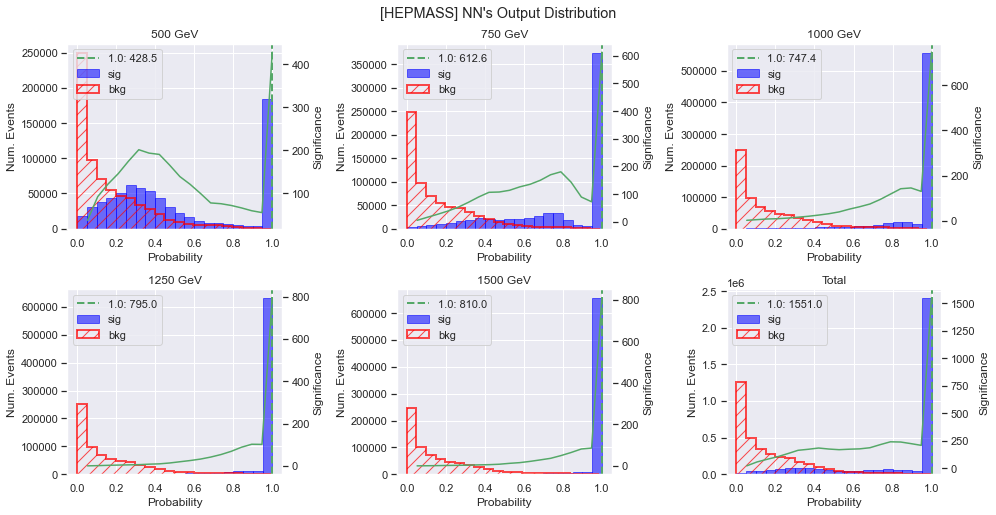

In [100]:
plot_significance_hep(nn, data, name='NN')

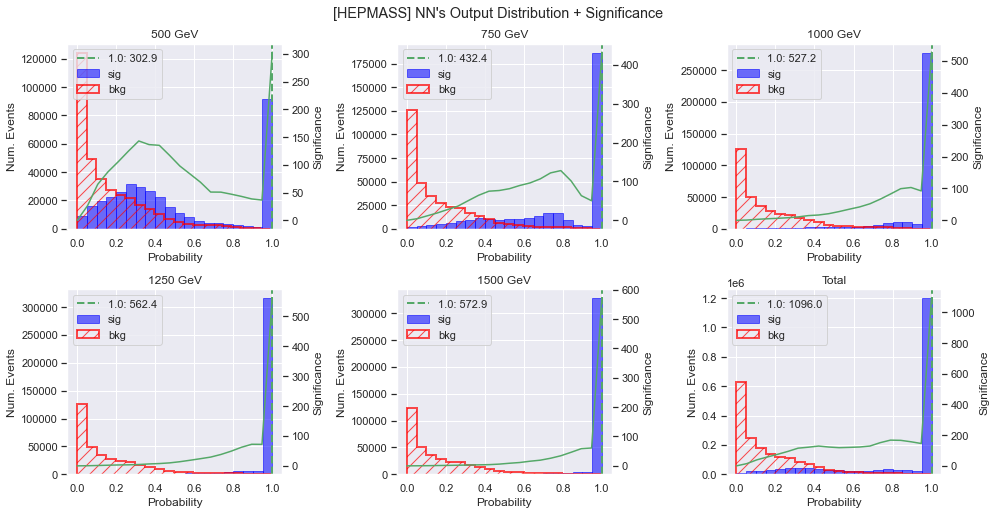

In [34]:
plot_significance_hep(nn, test_data, name='NN')

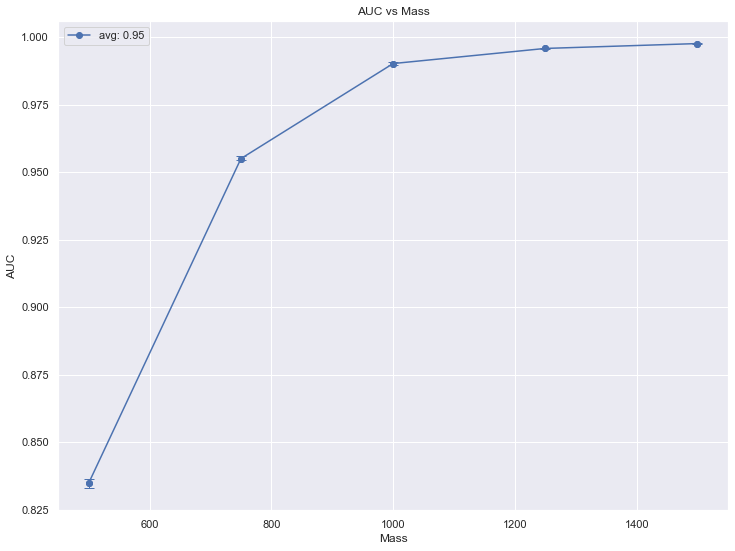

array([0.83494, 0.95504, 0.99019, 0.99578, 0.99759])

In [35]:
hepmass_eval.auc_with_error(nn, data, silent=True)

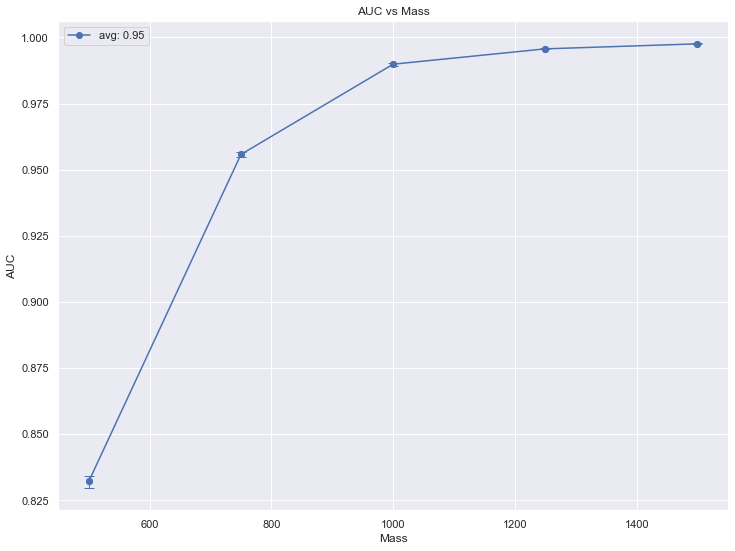

array([0.8322 , 0.95583, 0.98989, 0.9957 , 0.9976 ])

In [36]:
hepmass_eval.auc_with_error(nn, test_data, silent=True)

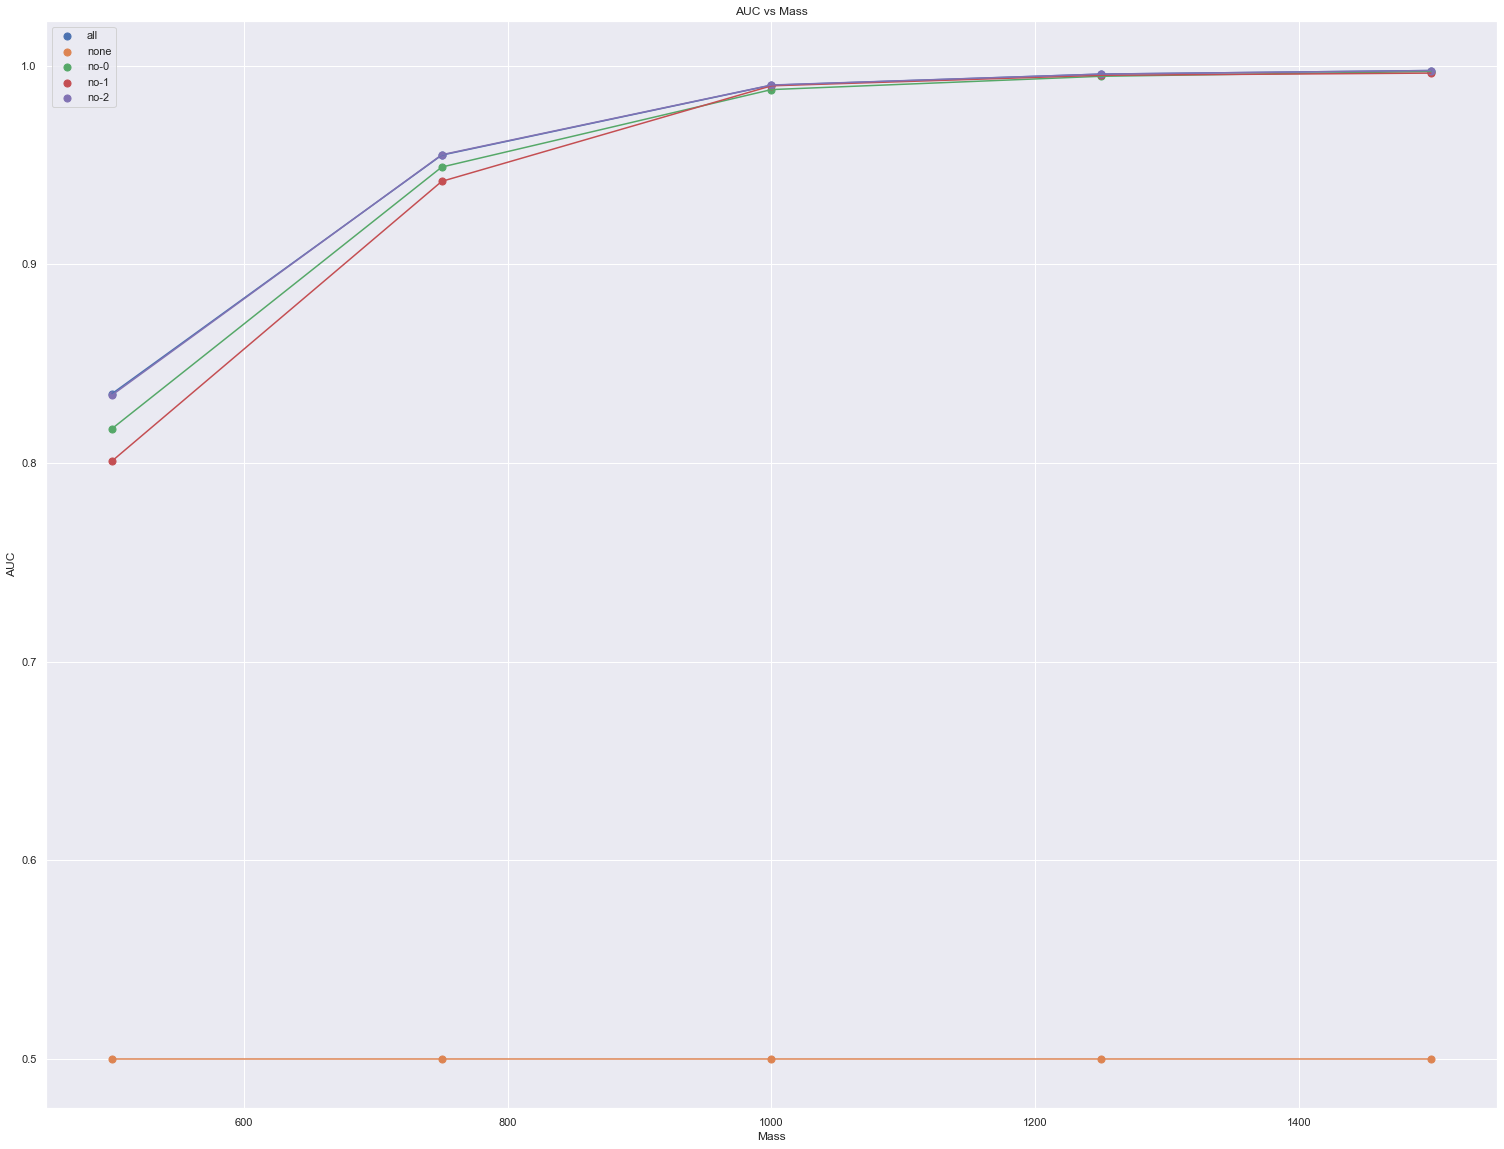

In [28]:
_ = hepmass_eval.auc_vs_mass_no_features(nn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### PNN

In [15]:
pnn, checkpoint = get_compiled_pnn(save='hepmass/baseline-pnn-robust2')

In [14]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.79 (+4%), AUC: 98.51 (+3%)

Epoch 1/20
41016/41016 [==============================] - 147s 4ms/step - loss: 0.2543 - binary_accuracy: 0.8676 - auc: 0.9477 - precision_1: 0.8490 - recall_1: 0.8943 - lr: 0.0010 - grad-norm: 0.7009 - weight-norm: 31.3942 - reg-losses: 0.0000e+00 - val_loss: 0.2728 - val_binary_accuracy: 0.8758 - val_auc: 0.9531 - val_precision_1: 0.8544 - val_recall_1: 0.9061
Epoch 2/20
41016/41016 [==============================] - 141s 3ms/step - loss: 0.3089 - binary_accuracy: 0.8763 - auc: 0.9530 - precision_1: 0.8594 - recall_1: 0.8999 - lr: 0.0010 - grad-norm: 0.5530 - weight-norm: 44.8312 - reg-losses: 0.0000e+00 - val_loss: 0.2704 - val_binary_accuracy: 0.8775 - val_auc: 0.9543 - val_precision_1: 0.8731 - val_recall_1: 0.8834
Epoch 3/20
41016/41016 [==============================] - 142s 3ms/step - loss: 0.2810 - binary_accuracy: 0.8784 - auc: 0.9543 - precision_1: 0.8612 - recall_1: 0.9023 - lr: 0.0010 - grad-norm: 0.4891 - weight-norm: 54.7491 - reg-losses: 0.0000e+00 - val_loss: 0.2669 - 

In [16]:
utils.load_from_checkpoint(pnn, path='hepmass/baseline-pnn-robust2')

Loaded from "weights\hepmass/baseline-pnn-robust2\weights-13-0.957"


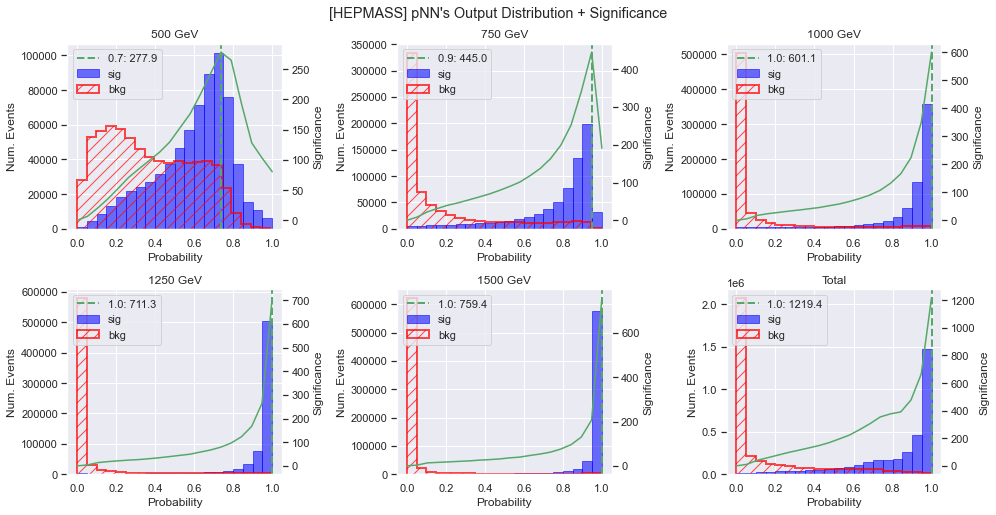

In [16]:
plot_significance_hep(pnn, data, name='pNN')

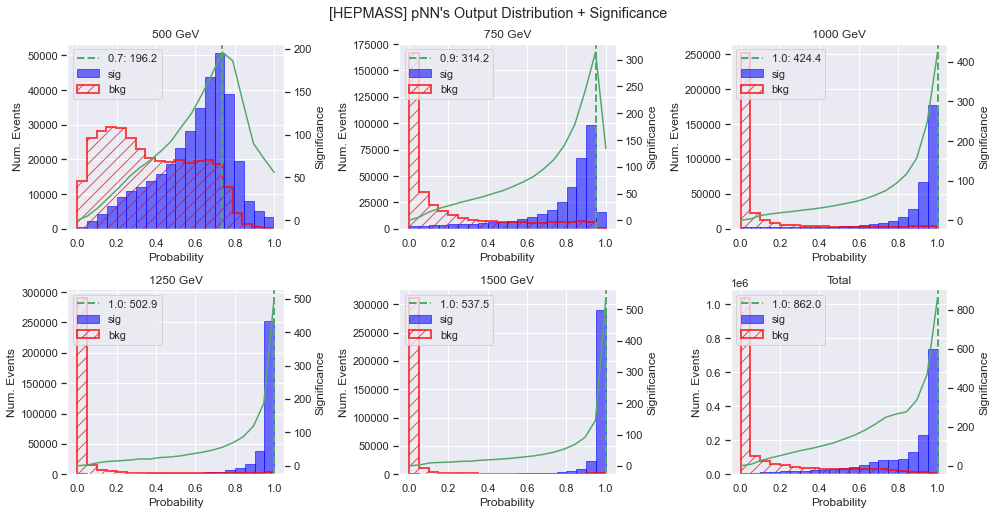

In [17]:
plot_significance_hep(pnn, test_data, name='pNN')

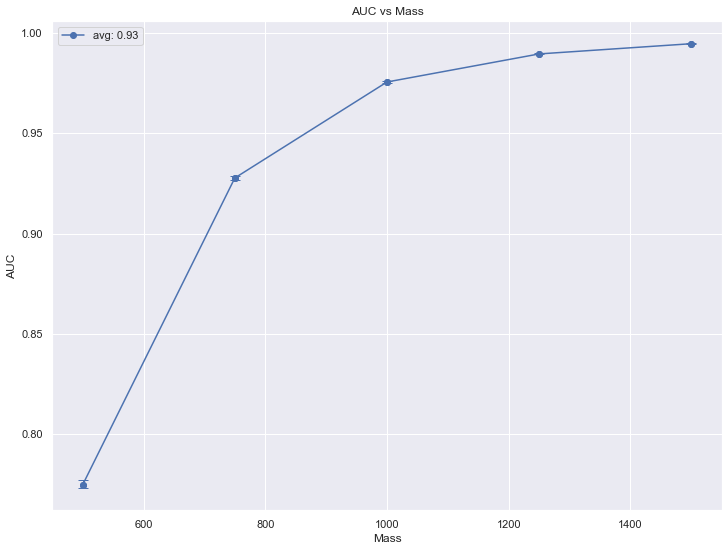

array([0.7746 , 0.92767, 0.97557, 0.98965, 0.99471])

In [17]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

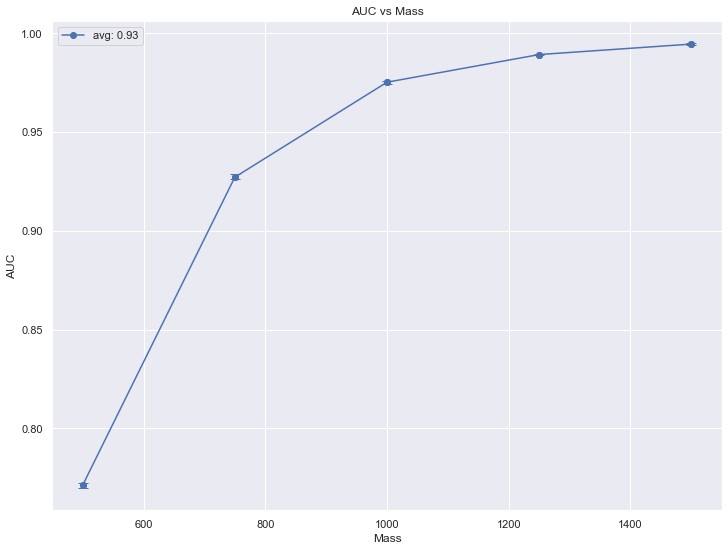

array([0.77118, 0.92721, 0.97528, 0.98933, 0.99461])

In [18]:
hepmass_eval.auc_with_error(pnn, test_data, silent=True)

In [ ]:
---

In [37]:
pnn, checkpoint = get_compiled_pnn(save='hepmass/baseline-pnn-robust')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 27)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 28)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 300)          8700        concatenate_2[0][0]   

In [9]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.79 (+4%), AUC: 98.51 (+3%)

Epoch 1/20
41016/41016 [==============================] - 178s 4ms/step - loss: 0.1725 - binary_accuracy: 0.8956 - auc: 0.9701 - precision: 0.8868 - recal: 0.9072 - lr: 0.0010 - grad-norm: 1.4130 - weight-norm: 34.0749 - reg-losses: 0.0000e+00 - val_loss: 0.1767 - val_binary_accuracy: 0.9159 - val_auc: 0.9800 - val_precision: 0.9063 - val_recal: 0.9278
Epoch 2/20
41016/41016 [==============================] - 189s 5ms/step - loss: 0.1114 - binary_accuracy: 0.9102 - auc: 0.9774 - precision: 0.9037 - recal: 0.9183 - lr: 0.0010 - grad-norm: 1.3324 - weight-norm: 48.9700 - reg-losses: 0.0000e+00 - val_loss: 0.1819 - val_binary_accuracy: 0.9117 - val_auc: 0.9785 - val_precision: 0.9115 - val_recal: 0.9119
Epoch 3/20
41016/41016 [==============================] - 183s 4ms/step - loss: 0.1557 - binary_accuracy: 0.9154 - auc: 0.9798 - precision: 0.9086 - recal: 0.9237 - lr: 0.0010 - grad-norm: 1.1916 - weight-norm: 59.9208 - reg-losses: 0.0000e+00 - val_loss: 0.1709 - val_binary_accuracy: 0.91

In [38]:
utils.load_from_checkpoint(pnn, path='hepmass/baseline-pnn-robust')

Loaded from "weights\hepmass/baseline-pnn-robust\weights-20-0.985"


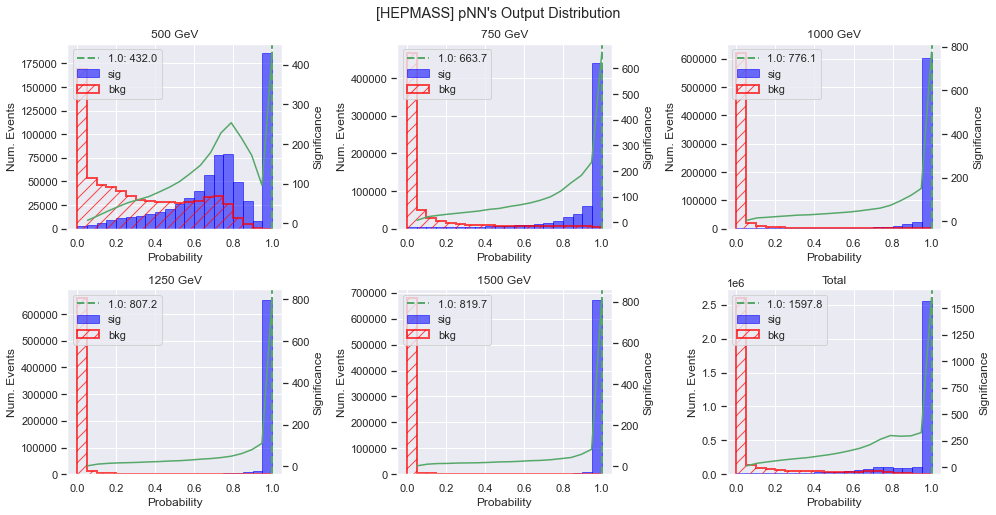

In [103]:
plot_significance_hep(pnn, data, name='pNN')

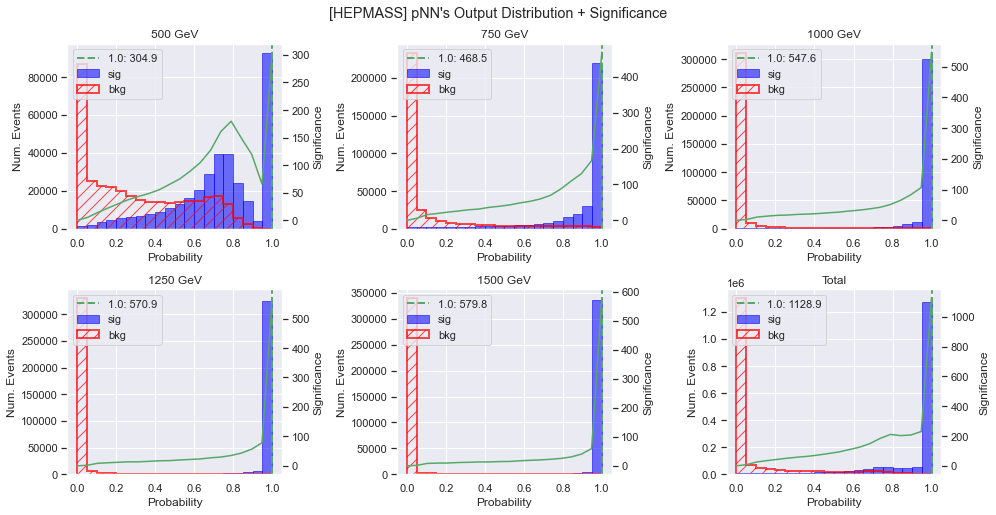

In [39]:
plot_significance_hep(pnn, test_data, name='pNN')

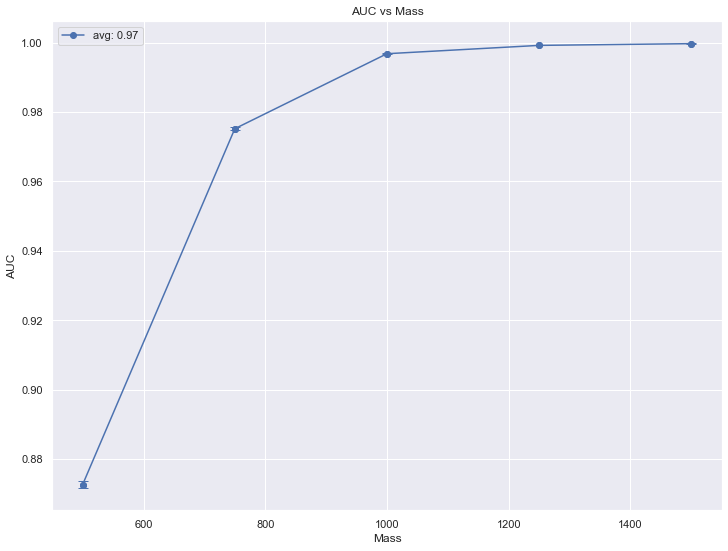

array([0.87271, 0.97517, 0.99681, 0.99921, 0.99972])

In [40]:
hepmass_eval.auc_with_error(pnn, data, silent=True)

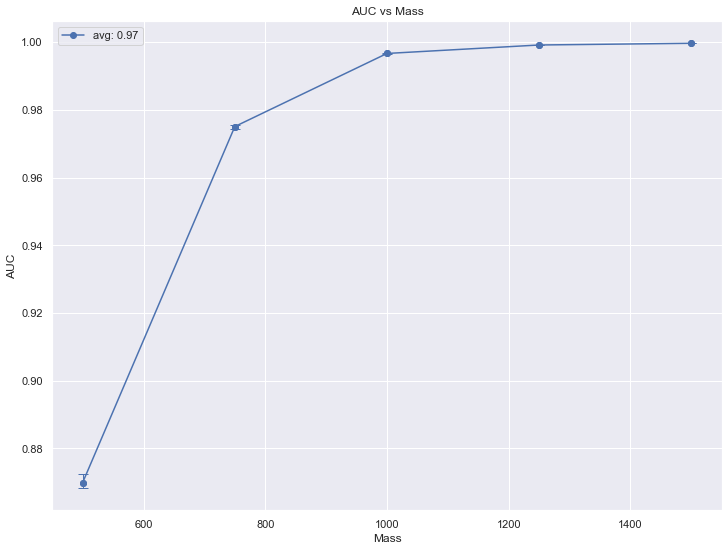

array([0.8699 , 0.97509, 0.99673, 0.99916, 0.9997 ])

In [41]:
hepmass_eval.auc_with_error(pnn, test_data, silent=True)

In [ ]:
_ = hepmass_eval.auc_vs_mass_no_features(pnn, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### AffinePNN

In [19]:
affine, checkpoint = get_compiled_affine_pnn(save='hepmass/baseline-affine-robust2',
                                             track_mass_reliance=True)

In [18]:
affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.72, AUC: 98.63

Epoch 1/20
41016/41016 [==============================] - 218s 5ms/step - loss: 0.2423 - binary_accuracy: 0.8605 - auc: 0.9438 - precision_2: 0.8401 - recall_2: 0.8906 - cls-loss: 0.2974 - lr: 0.0010 - grad-norm: 0.5253 - weight-norm: 42.6585 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0456 - val_loss: 0.2793 - val_binary_accuracy: 0.8722 - val_auc: 0.9512 - val_precision_2: 0.8444 - val_recall_2: 0.9126
Epoch 2/20
41016/41016 [==============================] - 204s 5ms/step - loss: 0.3349 - binary_accuracy: 0.8743 - auc: 0.9519 - precision_2: 0.8575 - recall_2: 0.8979 - cls-loss: 0.2760 - lr: 0.0010 - grad-norm: 0.5128 - weight-norm: 58.3605 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0486 - val_loss: 0.2746 - val_binary_accuracy: 0.8752 - val_auc: 0.9529 - val_precision_2: 0.8689 - val_recall_2: 0.8838
Epoch 3/20
41016/41016 [==============================] - 204s 5ms/step - loss: 0.2846 - binary_accuracy: 0.8775 - auc: 0.

In [20]:
utils.load_from_checkpoint(affine, path='hepmass/baseline-affine-robust2')

Loaded from "weights\hepmass/baseline-affine-robust2\weights-19-0.958"


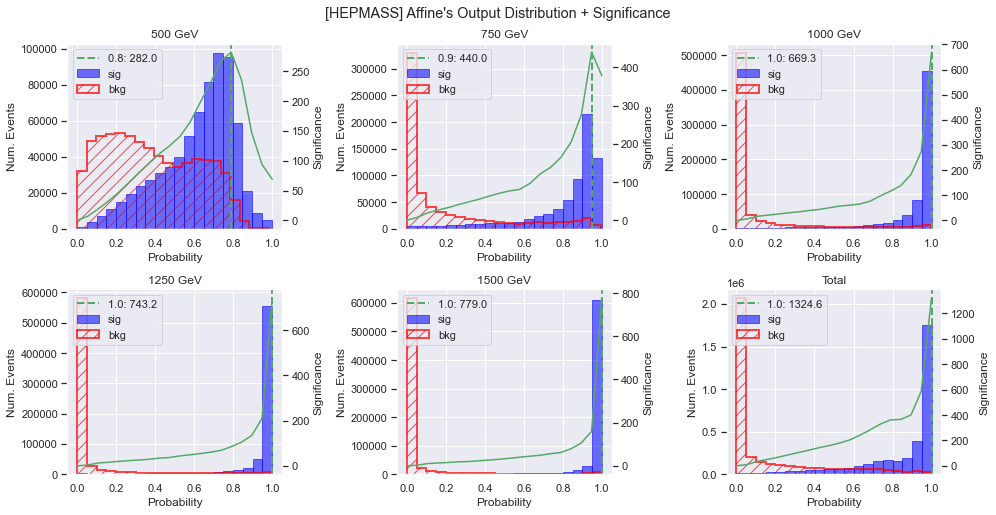

In [20]:
plot_significance_hep(affine, data, name='Affine')

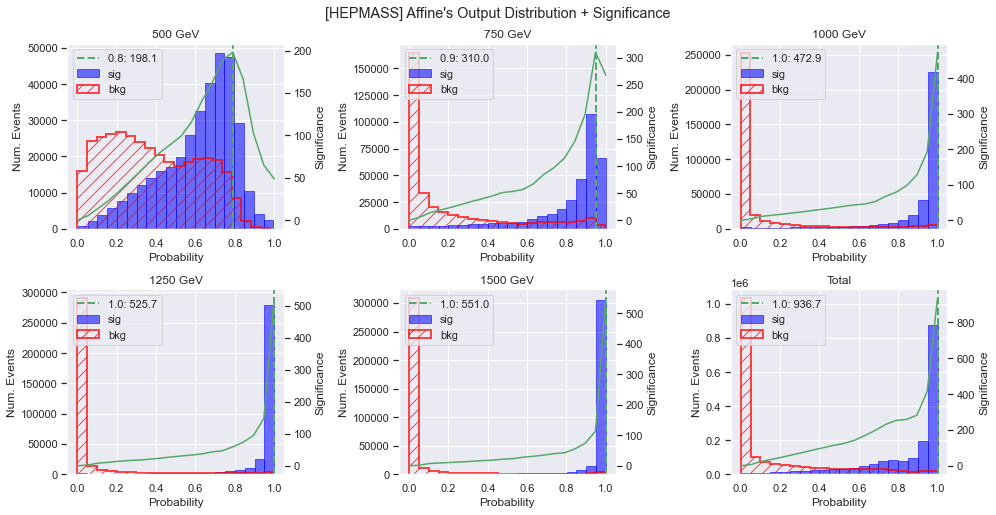

In [21]:
plot_significance_hep(affine, test_data, name='Affine')

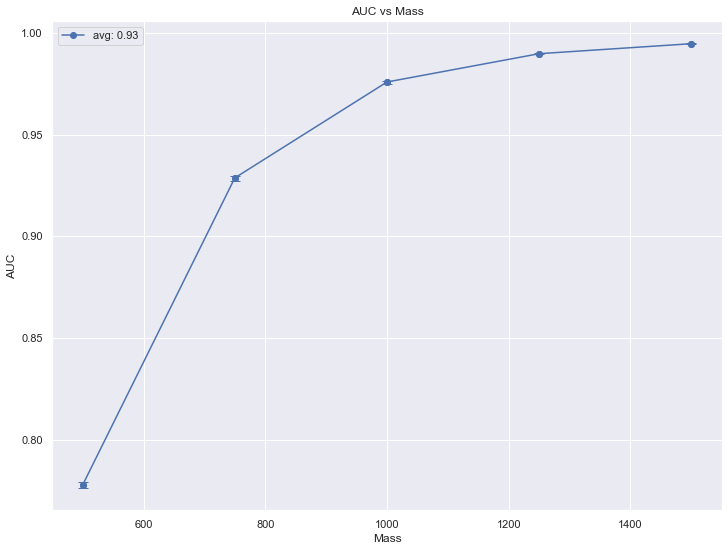

array([0.77793, 0.92874, 0.97585, 0.98972, 0.99463])

In [21]:
hepmass_eval.auc_with_error(affine, data, silent=True)

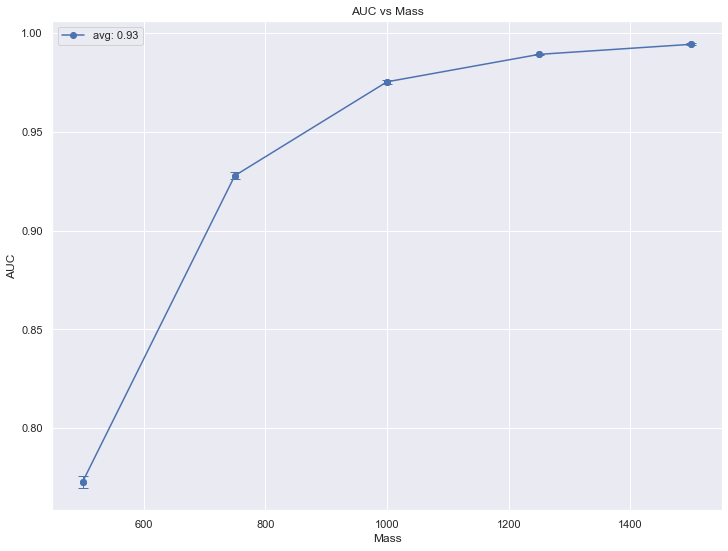

array([0.77291, 0.92793, 0.97536, 0.98931, 0.9944 ])

In [22]:
hepmass_eval.auc_with_error(affine, test_data, silent=True)

---

In [43]:
affine, checkpoint = get_compiled_affine_pnn(save='hepmass/baseline-affine-robust',
                                             track_mass_reliance=True)

In [21]:
affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 92.72, AUC: 98.63

Epoch 1/20
41016/41016 [==============================] - 203s 5ms/step - loss: 0.1379 - binary_accuracy: 0.8845 - auc: 0.9643 - precision_1: 0.8716 - recall_1: 0.9020 - cls-loss: 0.2340 - lr: 0.0010 - grad-norm: 1.5727 - weight-norm: 47.1910 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0589 - val_loss: 0.1880 - val_binary_accuracy: 0.9093 - val_auc: 0.9773 - val_precision_1: 0.9102 - val_recall_1: 0.9081
Epoch 2/20
41016/41016 [==============================] - 225s 5ms/step - loss: 0.1023 - binary_accuracy: 0.9084 - auc: 0.9769 - precision_1: 0.9028 - recall_1: 0.9155 - cls-loss: 0.1885 - lr: 0.0010 - grad-norm: 1.7129 - weight-norm: 67.6763 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0711 - val_loss: 0.1699 - val_binary_accuracy: 0.9182 - val_auc: 0.9815 - val_precision_1: 0.9220 - val_recall_1: 0.9138
Epoch 3/20
41016/41016 [==============================] - 229s 6ms/step - loss: 0.1391 - binary_accuracy: 0.9147 - auc: 0.

In [44]:
utils.load_from_checkpoint(affine, path='hepmass/baseline-affine-robust')

Loaded from "weights\hepmass/baseline-affine-robust\weights-19-0.986"


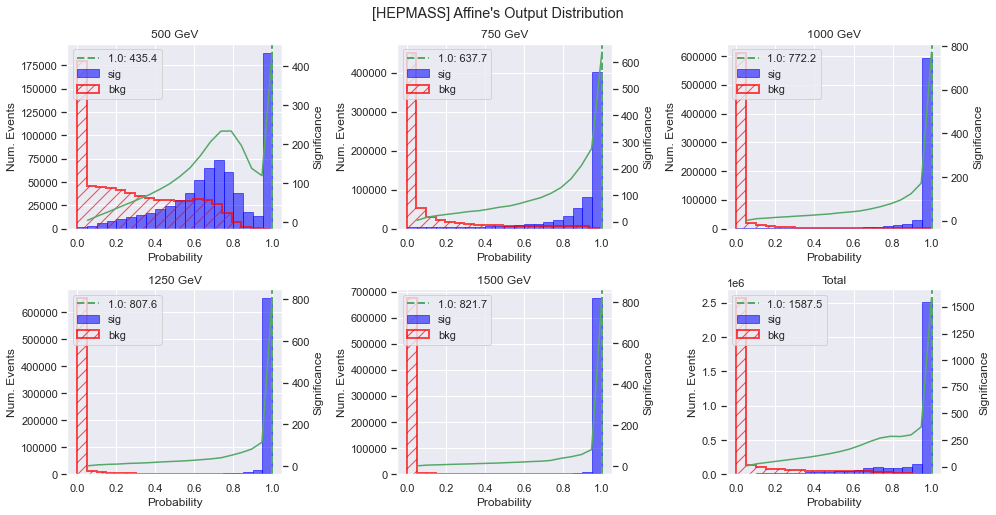

In [106]:
plot_significance_hep(affine, data, name='Affine')

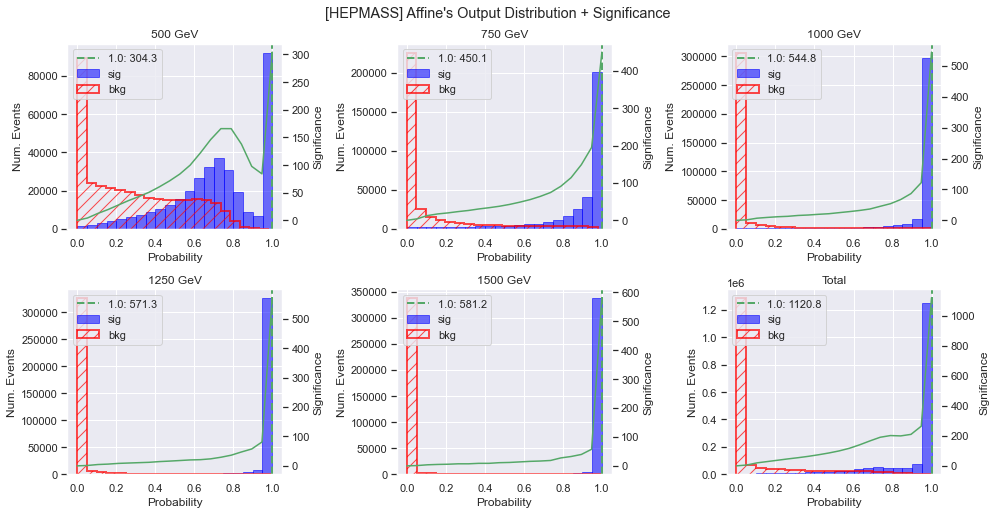

In [45]:
plot_significance_hep(affine, test_data, name='Affine')

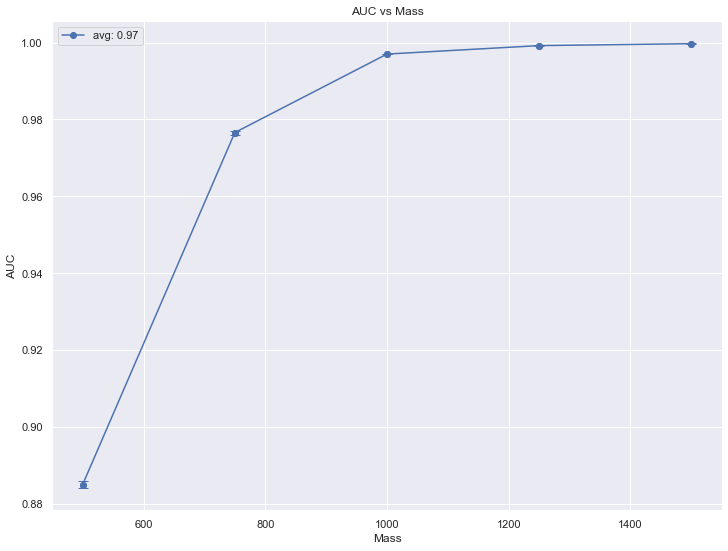

array([0.88508, 0.97656, 0.99701, 0.99922, 0.99971])

In [46]:
hepmass_eval.auc_with_error(affine, data, silent=True)

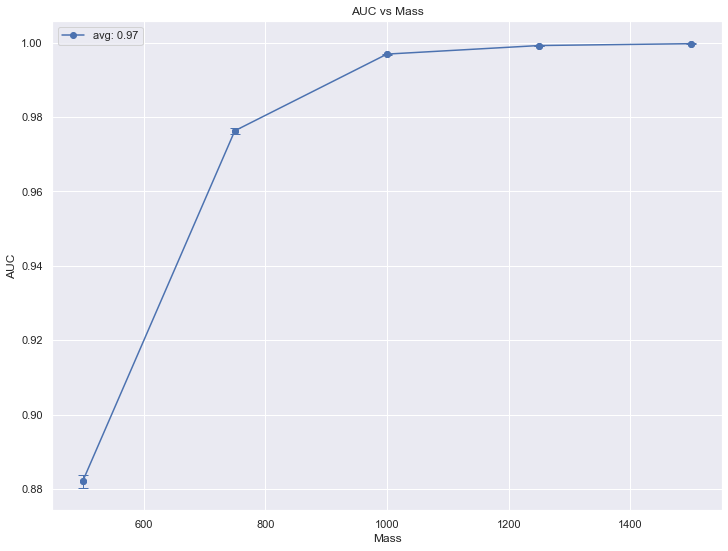

array([0.88211, 0.9763 , 0.99689, 0.99917, 0.99974])

In [47]:
hepmass_eval.auc_with_error(affine, test_data, silent=True)

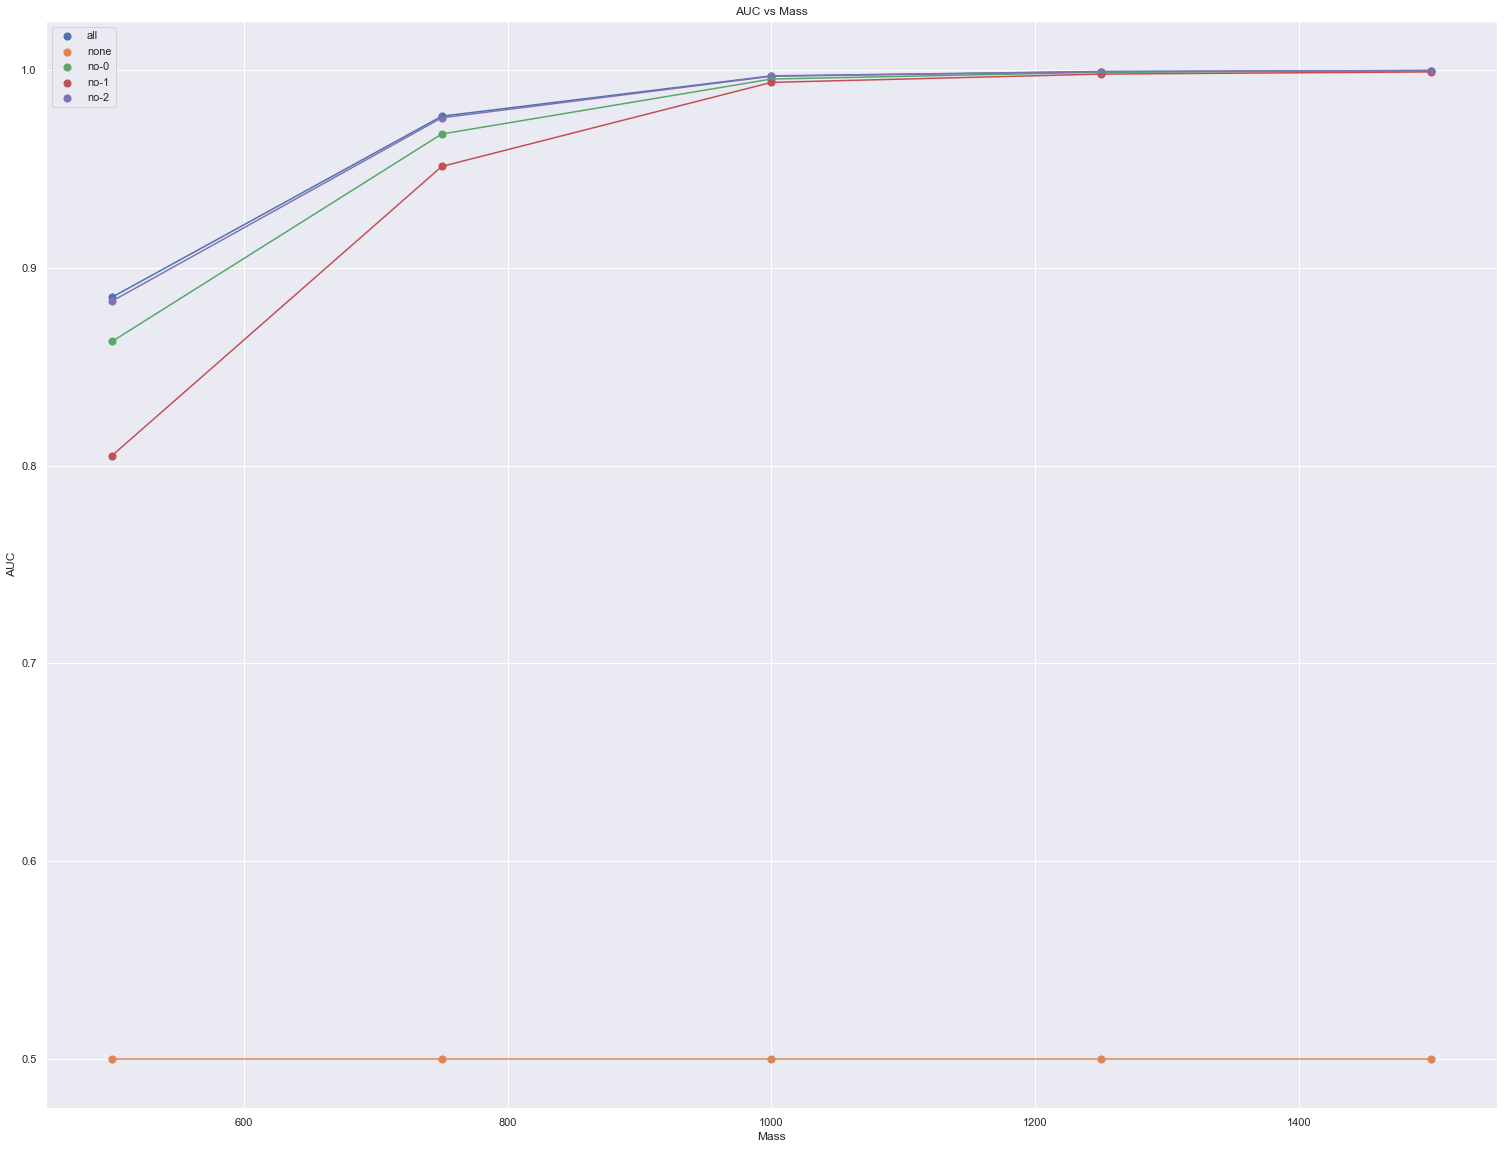

In [36]:
_ = hepmass_eval.auc_vs_mass_no_features(affine, data, features=hep_features[0], 
                                         auc_index=2, verbose=0, silent=True)

#### DC-PNN

In [23]:
model, checkpoint = utils.get_compiled_model(cls=DcPNN, data=data, track_mass_reliance=True,
                                             lr=3e-4, save='hepmass/baseline-dc-pnn-robust')

In [24]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 88.37, AUC: 95.76

Epoch 1/20
52500/52500 [==============================] - 270s 5ms/step - loss: 0.1858 - binary_accuracy: 0.8663 - auc: 0.9522 - precision: 0.8447 - recall: 0.8978 - cls-loss: 0.2697 - lr: 3.0000e-04 - grad-norm: 1.1444 - weight-norm: 36.1777 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0662 - val_loss: 0.2300 - val_binary_accuracy: 0.8936 - val_auc: 0.9676 - val_precision: 0.8867 - val_recall: 0.9025
Epoch 2/20
52500/52500 [==============================] - 267s 5ms/step - loss: 0.1545 - binary_accuracy: 0.9056 - auc: 0.9754 - precision: 0.8993 - recall: 0.9135 - cls-loss: 0.1953 - lr: 3.0000e-04 - grad-norm: 3.1180 - weight-norm: 47.1915 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0638 - val_loss: 0.2027 - val_binary_accuracy: 0.9009 - val_auc: 0.9736 - val_precision: 0.9116 - val_recall: 0.8878
Epoch 3/20
52500/52500 [==============================] - 269s 5ms/step - loss: 0.1634 - binary_accuracy: 0.9144 - auc: 0.9795 - p

Epoch 20/20
52500/52500 [==============================] - 349s 7ms/step - loss: 0.1092 - binary_accuracy: 0.9295 - auc: 0.9858 - precision: 0.9244 - recall: 0.9356 - cls-loss: 0.1482 - lr: 3.0000e-04 - grad-norm: 2.2554 - weight-norm: 100.1259 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0554 - val_loss: 0.1485 - val_binary_accuracy: 0.9290 - val_auc: 0.9859 - val_precision: 0.9148 - val_recall: 0.94623 -  - ETA: 4s - loss: 0.1067 - binary_accuracy: 0.9295 - auc: 0.9


In [25]:
utils.load_from_checkpoint(model, 'hepmass/baseline-dc-pnn-robust')

Loaded from "weights\hepmass/baseline-dc-pnn-robust\weights-19-0.986"


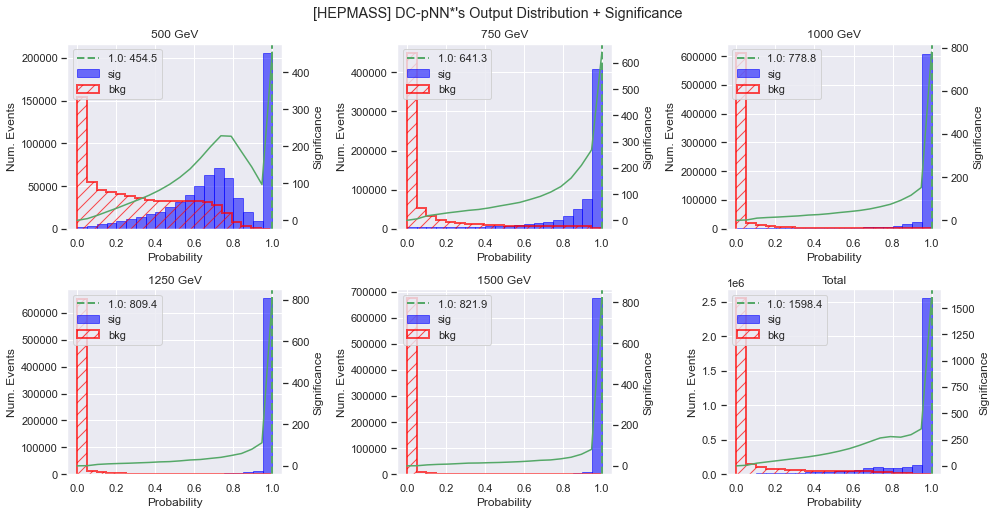

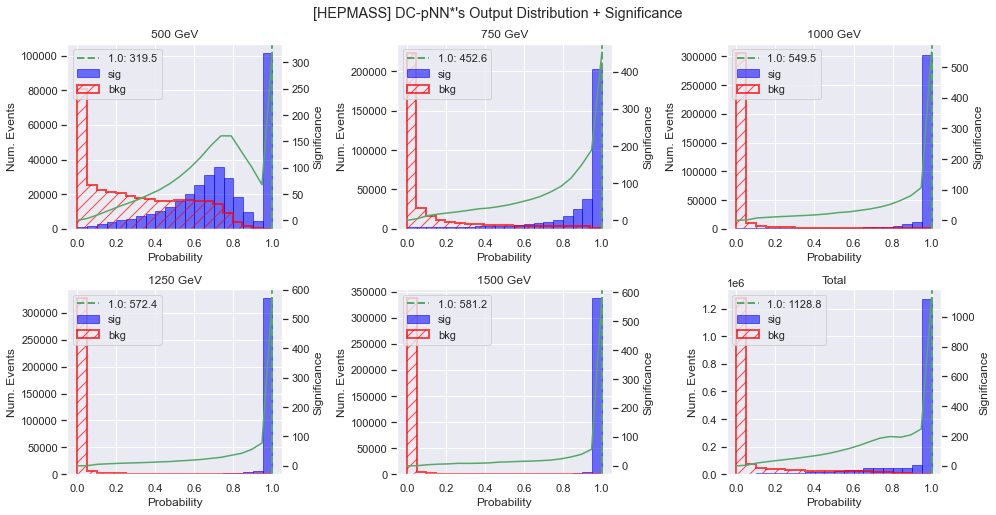

In [26]:
plot_significance_hep(model, data, name='DC-pNN*')
plot_significance_hep(model, test_data, name='DC-pNN*')

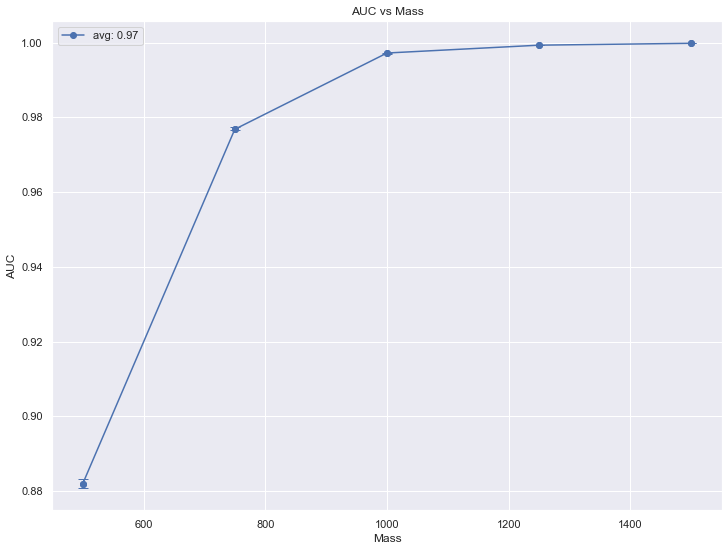

array([0.88185, 0.97684, 0.9972 , 0.99934, 0.9998 ])

In [27]:
hepmass_eval.auc_with_error(model, data, silent=True)

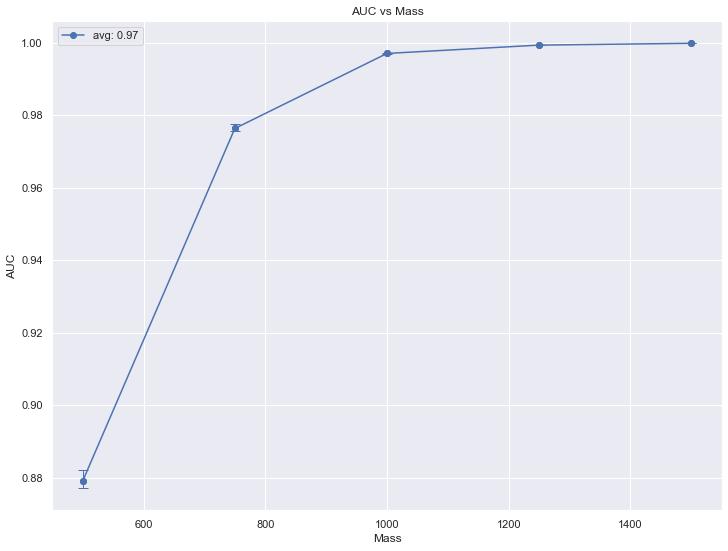

array([0.87903, 0.97631, 0.99699, 0.9993 , 0.9998 ])

In [28]:
hepmass_eval.auc_with_error(model, test_data, silent=True)

---
AUC comparison:

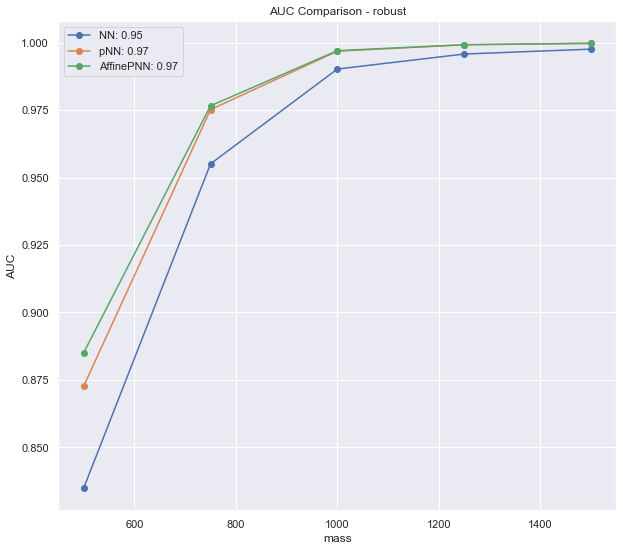

In [19]:
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             title='AUC Comparison - robust',
             NN=[0.83492, 0.95506, 0.9902 , 0.99576, 0.99758],
             pNN=[0.8727 , 0.97516, 0.99681, 0.9992 , 0.99972],
             AffinePNN=[0.88506, 0.97658, 0.99701, 0.99921, 0.99974])

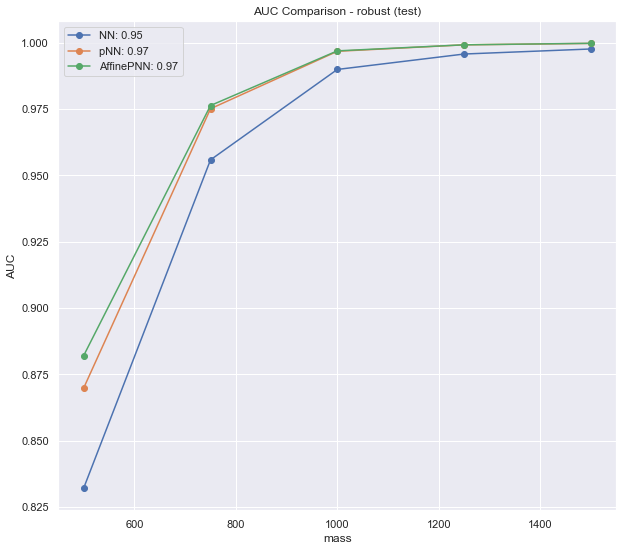

In [48]:
compare_plot(mass=[500, 750, 1000, 1250, 1500],
             title='AUC Comparison - robust (test)',
             NN=[0.8322 , 0.95583, 0.98989, 0.9957 , 0.9976],
             pNN=[0.8699 , 0.97509, 0.99673, 0.99916, 0.9997],
             AffinePNN=[0.88211, 0.9763 , 0.99689, 0.99917, 0.99974])

### Dataset

In [33]:
def plot_significance(model, dataset: Dataset, bins=20, name='Model', sample_frac=None, 
                      size=4, ams_eq=2):
    def safe_div(a, b):
        if b == 0.0:
            return 0.0
        
        return a / b

    fig, axes = plt.subplots(ncols=4, nrows=6)
    axes = np.reshape(axes, newshape=[-1])
    
    fig.set_figwidth(int(size * 5))
    fig.set_figheight(int(size * 5))
    
    plt.suptitle(f'[Dataset] {name}\'s Output Distribution + Significance', 
                 y=1.02, verticalalignment='top')
    
    for i, interval in enumerate(dataset.current_mass_intervals + [None]):
        ax = axes[i]
        
        if interval is None:
            x, y = dataset.get(sample=sample_frac)
            title = 'Total'
        else:
            x, y = dataset.get_by_mass(interval, sample=sample_frac)
            title = f'{int(np.mean(interval))} GeV'
            
        out = model.predict(x, batch_size=128, verbose=0)
        out = np.asarray(out)
        
        sig_mask = y == 1.0
        bkg_mask = y == 0.0
        
        cuts = np.linspace(0.0, 1.0, num=bins)
        ams = []
        
        bx = ax.twinx()
        
        ax.hist(out[sig_mask], bins=bins, alpha=0.55, label='sig', color='blue', edgecolor='blue')
        ax.hist(out[bkg_mask], bins=bins, alpha=0.7, label='bkg', color='red', histtype='step', 
                hatch='//', linewidth=2, edgecolor='red')
        
        for i in range(len(cuts) - 1):
            lo, up = cuts[i], cuts[i + 1]
            
            cut_mask = (out > lo) & (out <= up)
            
            # select signals and bkg
            s = out[sig_mask & cut_mask].shape[0]
            b = out[bkg_mask & cut_mask].shape[0]
        
            # compute approximate median significance (AMS)
            if ams_eq == 1:
                val = np.sqrt(2 * ((s + b) * np.log(1 + safe_div(s, b)) - s))
            elif ams_eq == 2:
                val = safe_div(s, np.sqrt(s + b))
            else:
                val = safe_div(s, np.sqrt(b))
        
        k = np.argmax(ams)
        
        bx.grid(False)
        bx.plot(cuts, [0.0] + ams, color='g', label='Significance')
        
        ax.axvline(x=cuts[k + 1], linestyle='--', linewidth=2, color='g',
                   label=f'{round(cuts[k + 1], 1)}: {round(ams[k], 1)}')
        
        bx.set_ylabel('Significance')
        ax.set_title(title)
        ax.set_xlabel('Probability')
        ax.set_ylabel('Num. Events')
        
        ax.legend(loc='best')
    
    fig.tight_layout()


In [34]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [9]:
num_features = len(data.columns['feature'])
features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [109]:
nn, checkpoint = get_compiled_non_parametric(save='tom/baseline-nn')
nn.summary()

Model: "NonParam-NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 150)          45150       dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 100)          15100       dense_25[0][0]                   
________________________________________________________________________________________

In [11]:
_ = nn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 83.60, AUC: 91.65

Epoch 1/10
27405/27405 [==============================] - 110s 4ms/step - loss: 0.4682 - binary_accuracy: 0.8346 - auc: 0.9147 - precision: 0.7886 - recall: 0.8474 - lr: 0.0010 - grad-norm: 0.7098 - weight-norm: 161.4235 - reg-losses: 0.0000e+00 - val_loss: 0.3609 - val_binary_accuracy: 0.8346 - val_auc: 0.9158 - val_precision: 0.7990 - val_recall: 0.8277
Epoch 2/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2991 - binary_accuracy: 0.8346 - auc: 0.9148 - precision: 0.7886 - recall: 0.8477 - lr: 0.0010 - grad-norm: 0.6937 - weight-norm: 169.8440 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accuracy: 0.8346 - val_auc: 0.9155 - val_precision: 0.7950 - val_recall: 0.8347
Epoch 3/10
27405/27405 [==============================] - 112s 4ms/step - loss: 0.2882 - binary_accuracy: 0.8348 - auc: 0.9149 - precision: 0.7893 - recall: 0.8469 - lr: 0.0010 - grad-norm: 0.6806 - weight-norm: 177.6617 - reg-losses: 0.0000e+00 - val_loss: 0.3610 - val_binary_accura

In [110]:
nn.load_weights('weights/tom/baseline-nn/weights-10-0.917')

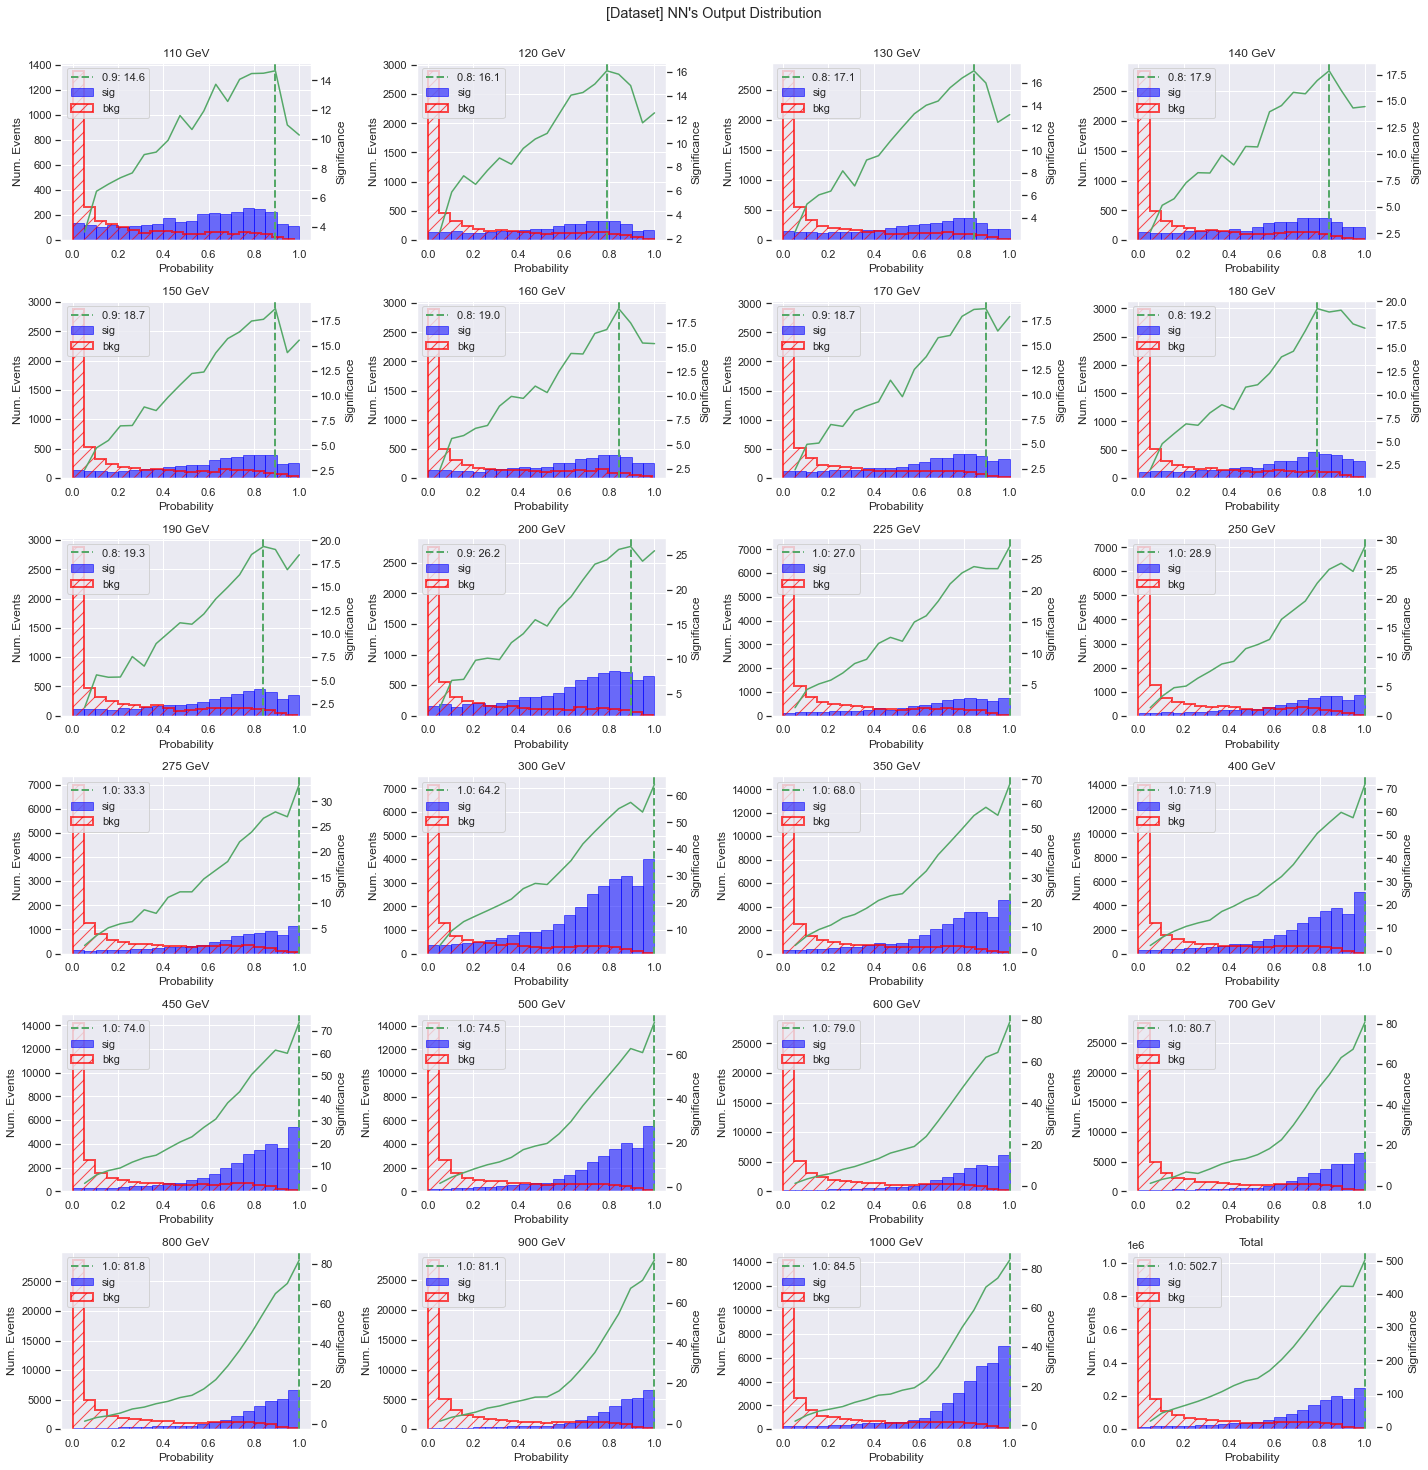

In [116]:
plot_significance(nn, data, name='NN')

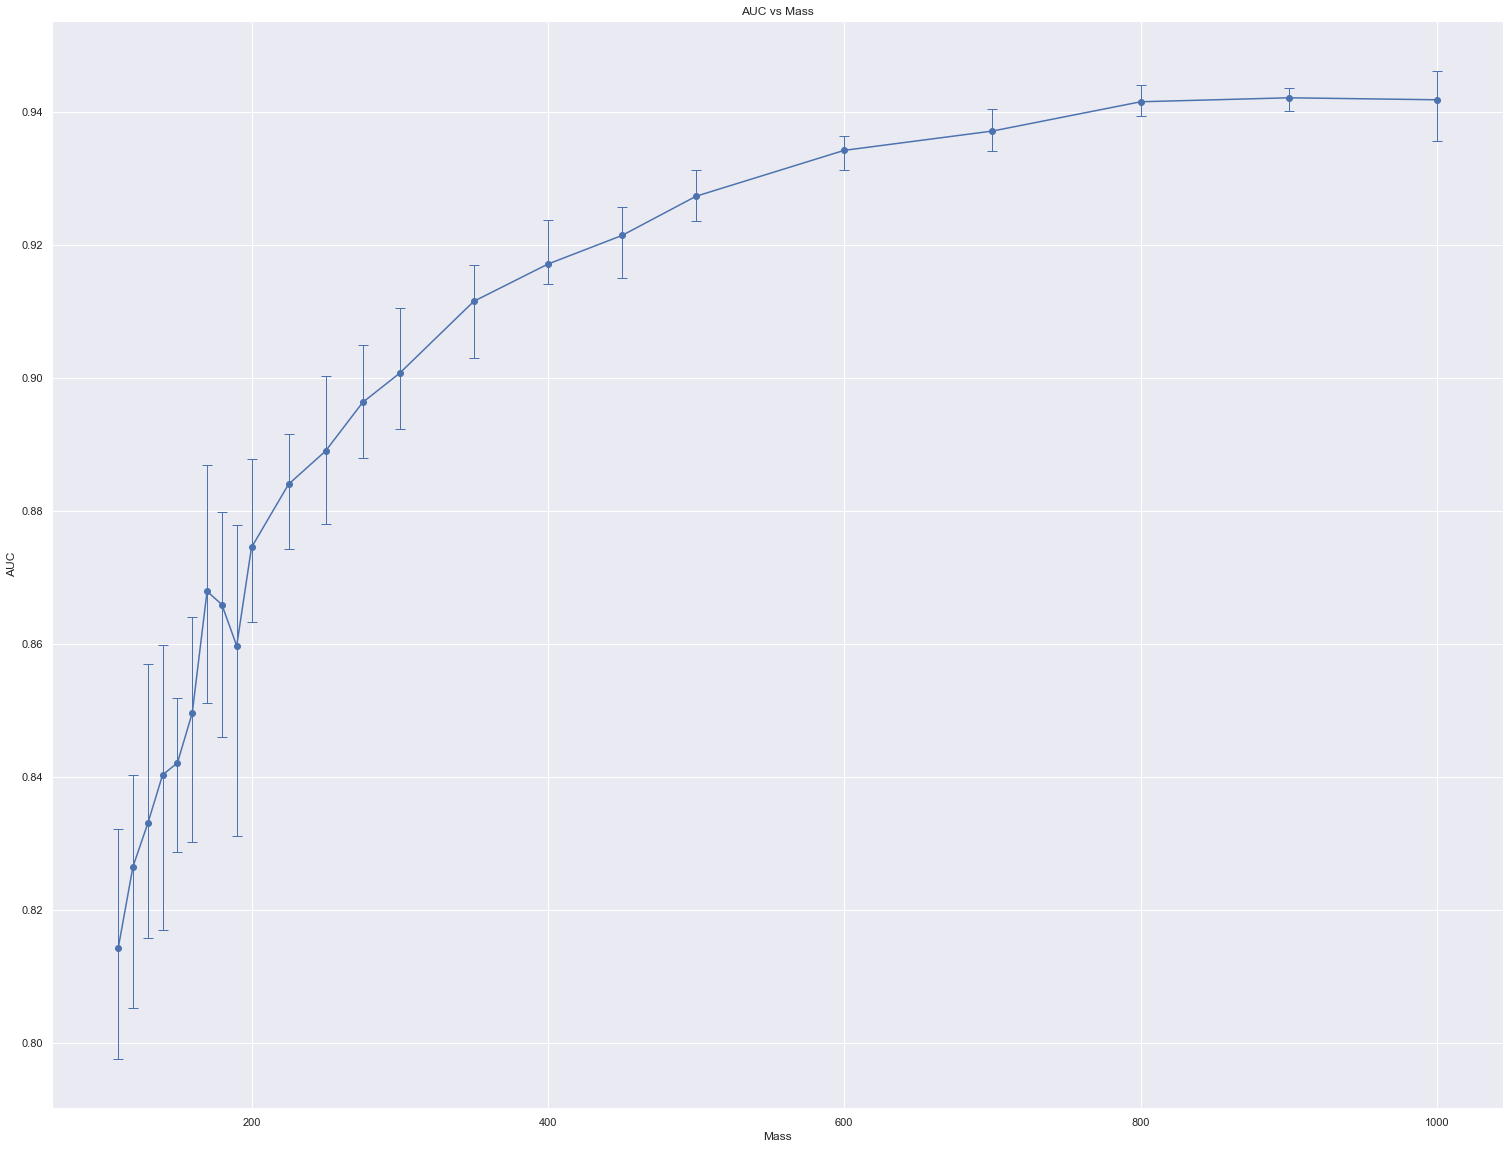

array([0.81422, 0.82654, 0.83298, 0.84028, 0.84209, 0.84958, 0.86791,
       0.86589, 0.85973, 0.87451, 0.88399, 0.88897, 0.89633, 0.90073,
       0.91154, 0.91708, 0.92143, 0.92729, 0.9342 , 0.93715, 0.94145,
       0.9421 , 0.94183])

In [12]:
auc_with_error(nn, data, silent=True)

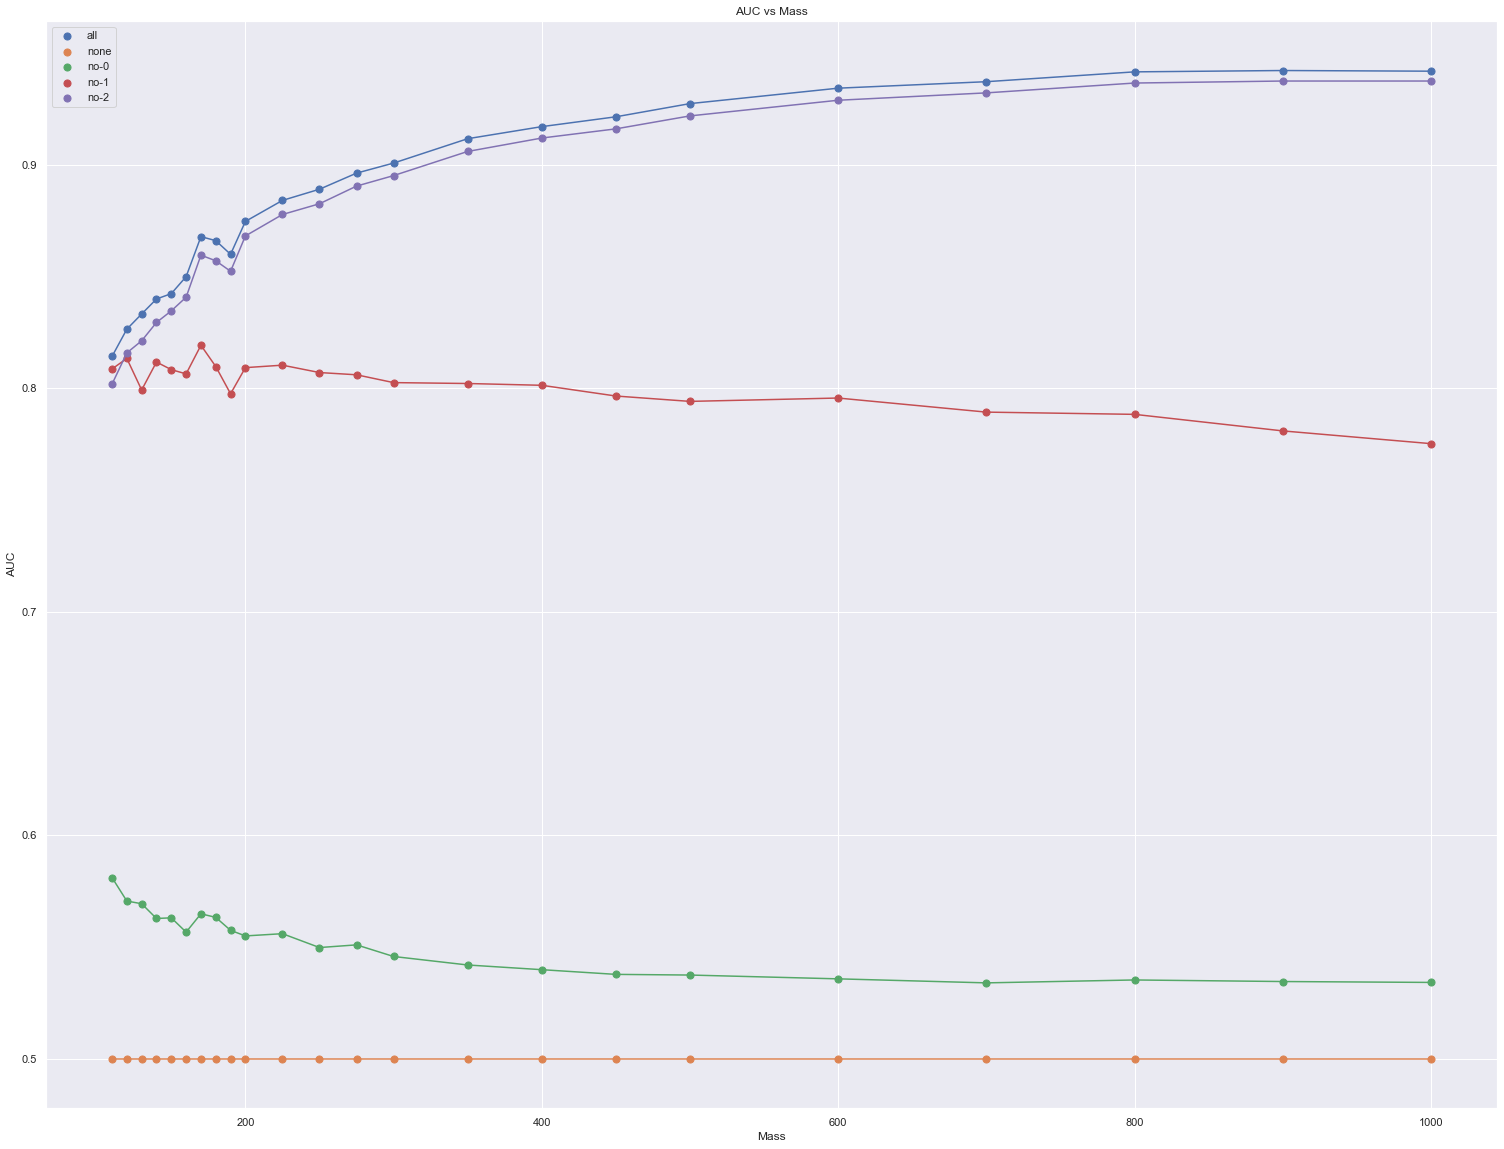

In [15]:
_ = auc_vs_mass_no_features(nn, data, features=features[0], verbose=0, silent=True)

#### PNN

In [35]:
pnn, checkpoint = get_compiled_pnn(save='tom/baseline-pnn', track_mass_reliance=True)

In [13]:
pnn.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
        epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 95.26 (+12%), AUC: 99.10 (+8%)

Epoch 1/20
27405/27405 [==============================] - 95s 3ms/step - loss: 0.2556 - binary_accuracy: 0.8411 - auc: 0.9192 - precision_1: 0.7901 - recall_1: 0.8649 - lr: 0.0010 - grad-norm: 1.8005 - weight-norm: 40.8257 - reg-losses: 0.0000e+00 - val_loss: 0.3291 - val_binary_accuracy: 0.8519 - val_auc: 0.9300 - val_precision_1: 0.7907 - val_recall_1: 0.8965
Epoch 2/20
27405/27405 [==============================] - 96s 4ms/step - loss: 0.3294 - binary_accuracy: 0.8548 - auc: 0.9315 - precision_1: 0.8064 - recall_1: 0.8774 - lr: 0.0010 - grad-norm: 2.4118 - weight-norm: 70.8826 - reg-losses: 0.0000e+00 - val_loss: 0.3337 - val_binary_accuracy: 0.8481 - val_auc: 0.9302 - val_precision_1: 0.8308 - val_recall_1: 0.8170
Epoch 3/20
27405/27405 [==============================] - 92s 3ms/step - loss: 0.3689 - binary_accuracy: 0.8609 - auc: 0.9367 - precision_1: 0.8134 - recall_1: 0.8833 - lr: 0.0010 - grad-norm: 2.7885 - weight-norm: 89.7308 - reg-losses: 0.0000e+00 - val_loss: 0.3092 - val

In [36]:
pnn.load_weights('weights/tom/baseline-pnn/weights-17-0.991')

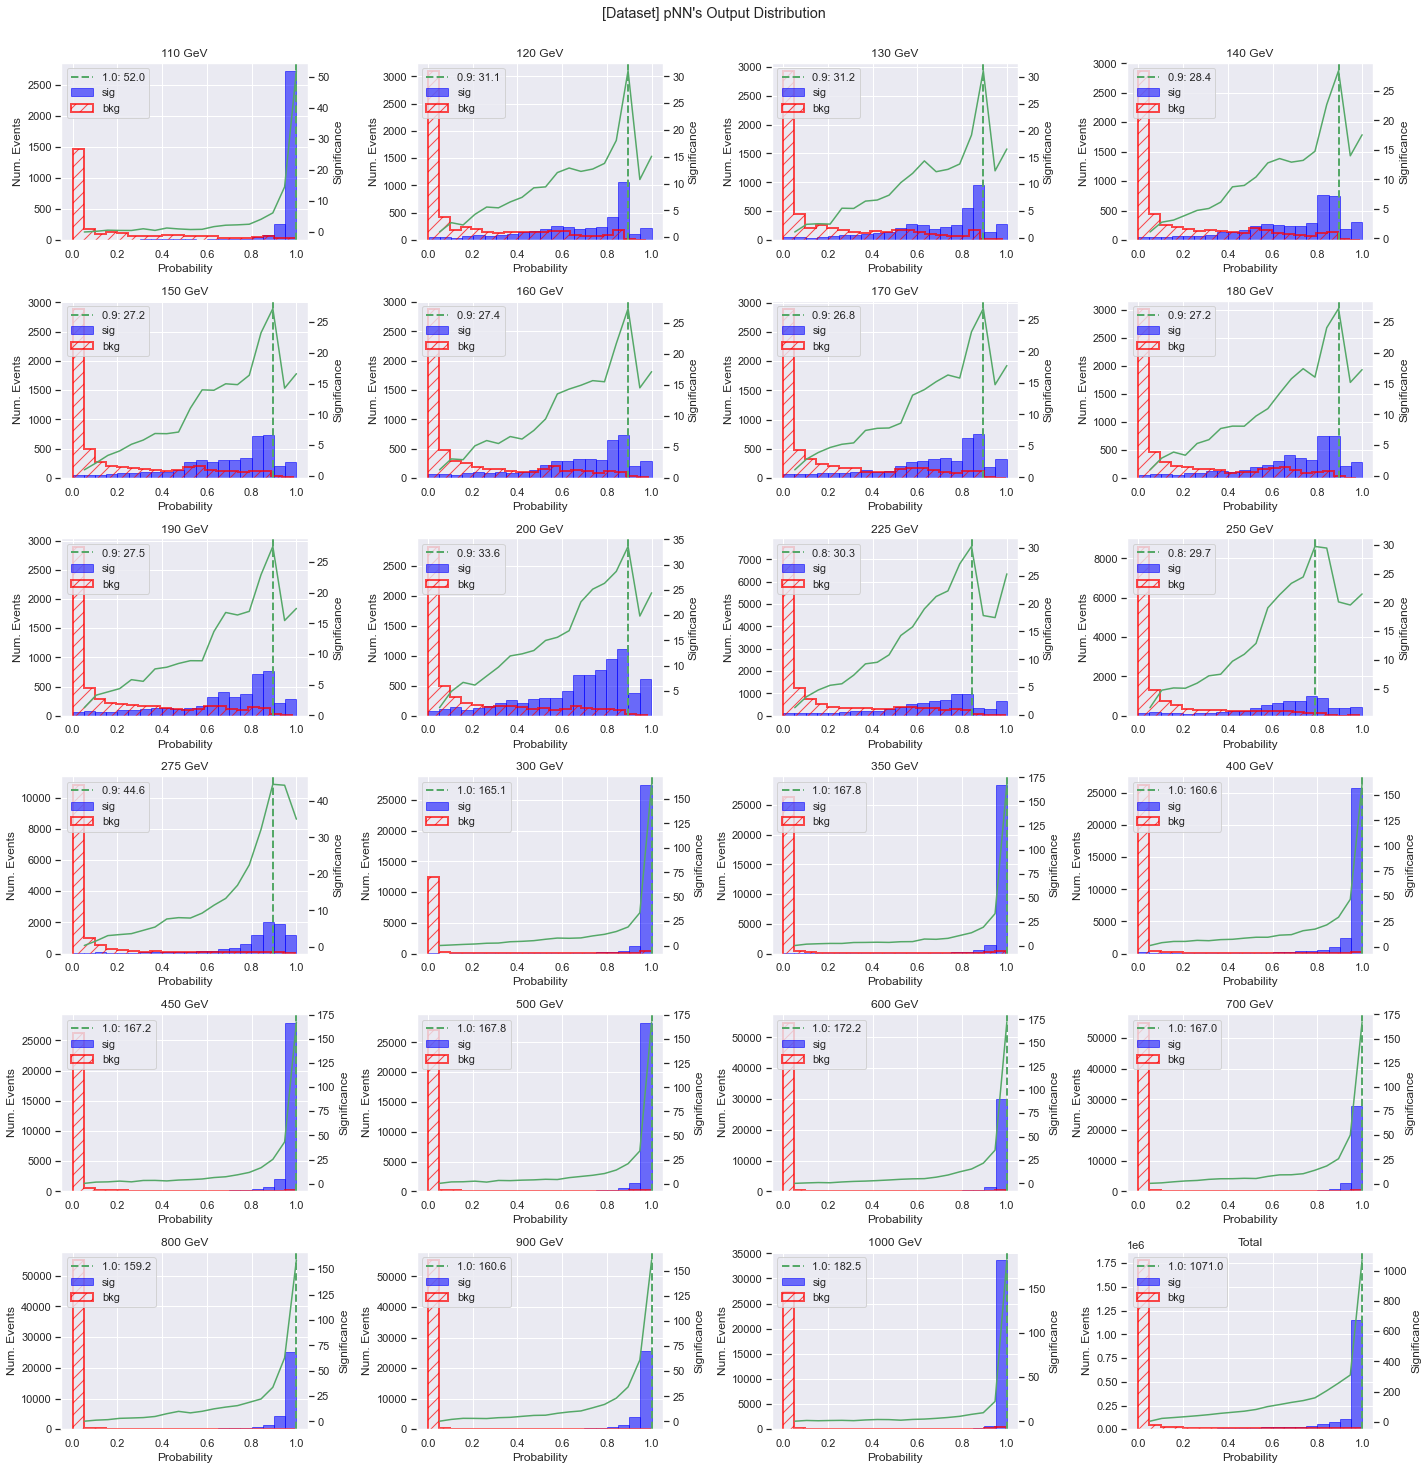

In [119]:
plot_significance(pnn, data, name='pNN')

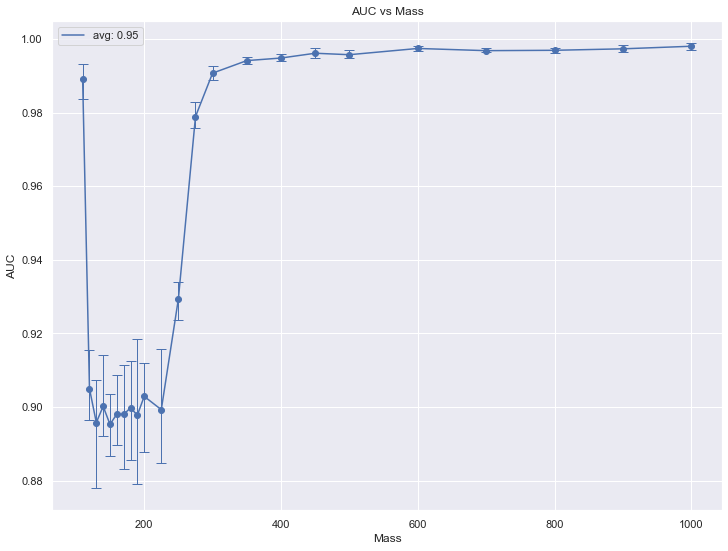

array([0.9891 , 0.90505, 0.89579, 0.90024, 0.89526, 0.89814, 0.89796,
       0.89977, 0.89783, 0.90288, 0.89928, 0.92945, 0.97893, 0.99073,
       0.99407, 0.99482, 0.99611, 0.99574, 0.99736, 0.99675, 0.99688,
       0.99729, 0.99795])

In [37]:
auc_with_error(pnn, data, silent=True)

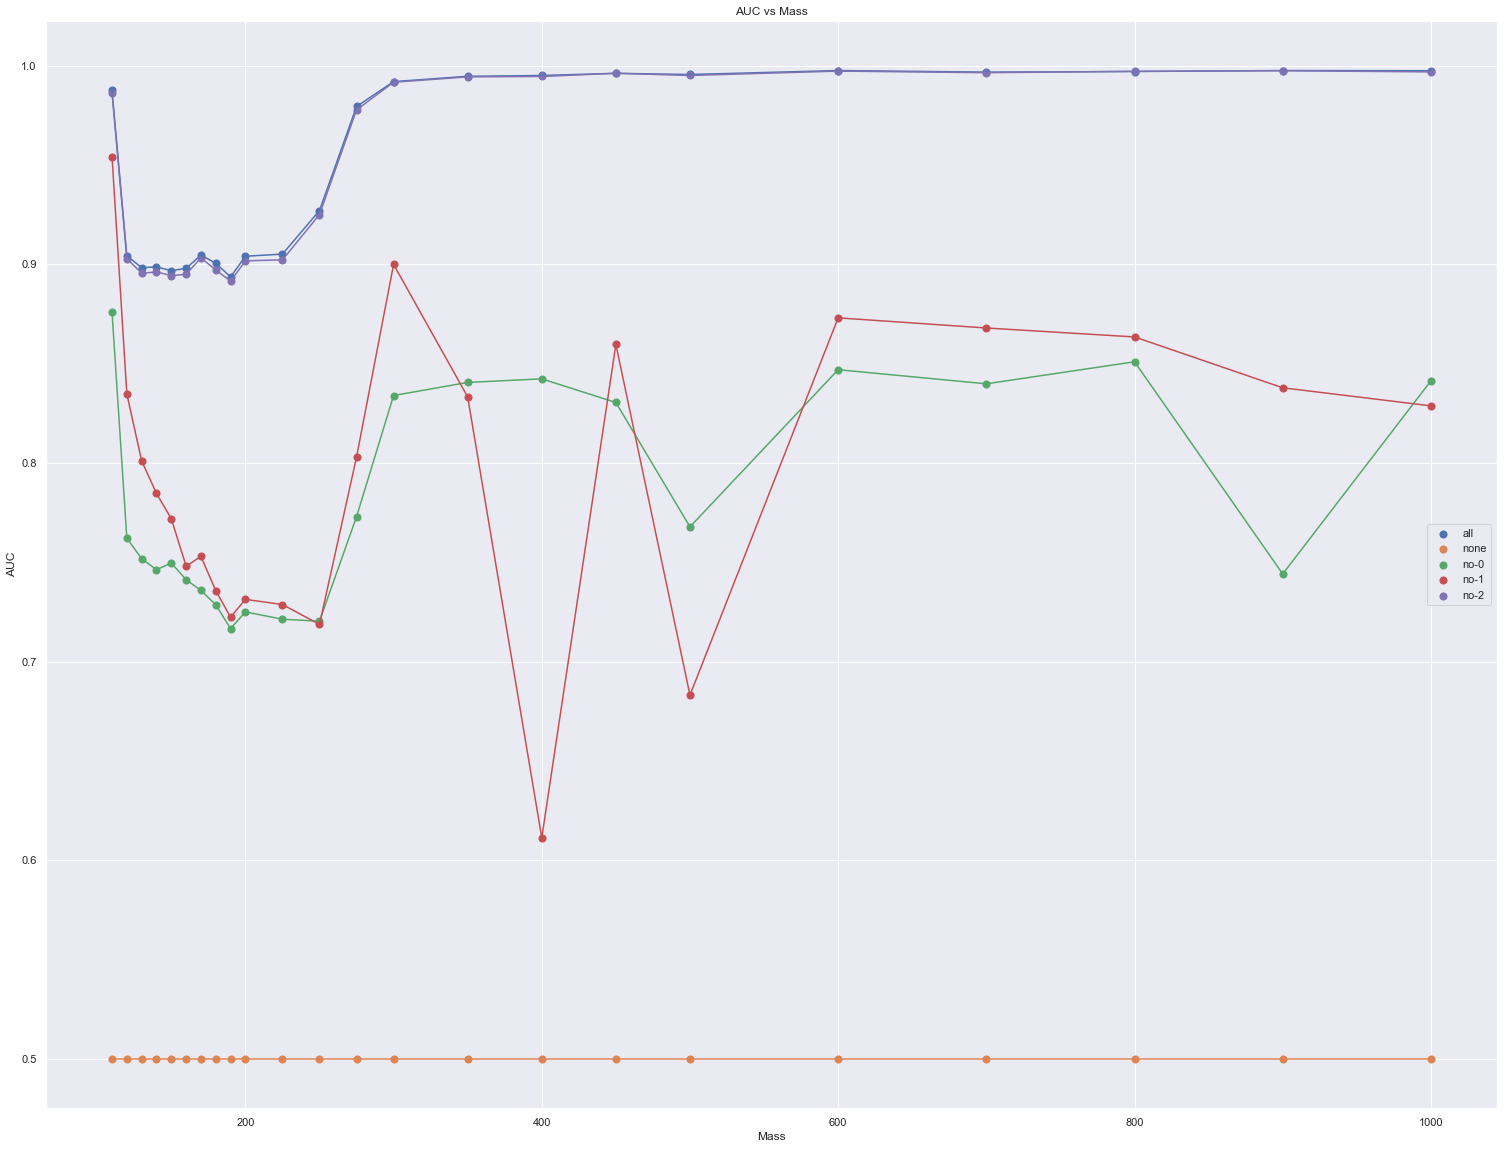

In [17]:
_ = auc_vs_mass_no_features(pnn, data, features=features[0], verbose=0, silent=True)

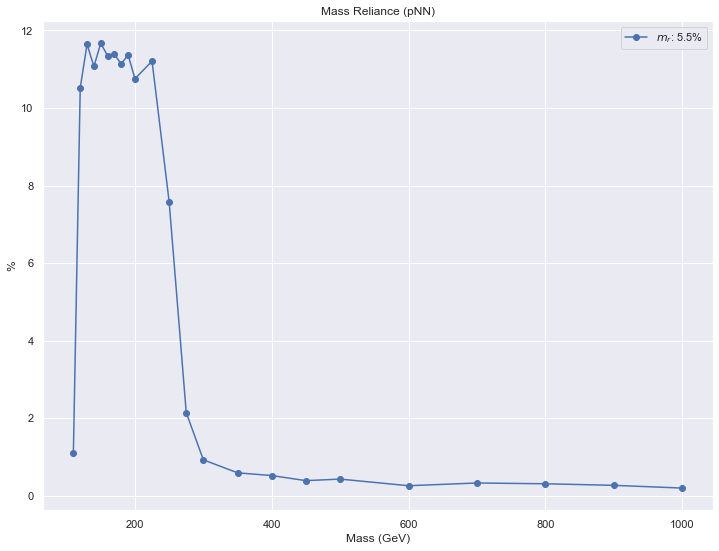

array([ 1.11223458, 10.52166225, 11.64452384, 11.07408642, 11.6694584 ,
       11.34617526, 11.3833816 , 11.13580796, 11.37097672, 10.75423635,
       11.20996441,  7.58472297,  2.14504597,  0.92854259,  0.59350166,
        0.52271813,  0.39152696,  0.43185699,  0.26067776,  0.33109261,
        0.31096399,  0.27073097,  0.2004008 ])

In [40]:
plot_mass_reliance(pnn, data)

#### AffinePNN

In [41]:
affine, checkpoint = get_compiled_affine_pnn(save='tom/baseline-affine',
                                             track_mass_reliance=True)

In [16]:
affine.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT,
           epochs=NUM_EPOCHS, callbacks=[checkpoint])

# accuracy: 96.91 (+1.7%), AUC: 99.48 (+0.4%)

Epoch 1/20
27405/27405 [==============================] - 123s 4ms/step - loss: 0.2109 - binary_accuracy: 0.8430 - auc: 0.9222 - precision_2: 0.7983 - recall_2: 0.8559 - cls-loss: 0.3456 - lr: 0.0010 - grad-norm: 3.5552 - weight-norm: 64.7083 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.1257 - val_loss: 0.2855 - val_binary_accuracy: 0.8758 - val_auc: 0.9466 - val_precision_2: 0.8341 - val_recall_2: 0.8917
Epoch 2/20
27405/27405 [==============================] - 122s 4ms/step - loss: 0.0919 - binary_accuracy: 0.9093 - auc: 0.9695 - precision_2: 0.8720 - recall_2: 0.9280 - cls-loss: 0.2171 - lr: 0.0010 - grad-norm: 12.1408 - weight-norm: 118.9378 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.4285 - val_loss: 0.1779 - val_binary_accuracy: 0.9293 - val_auc: 0.9791 - val_precision_2: 0.9004 - val_recall_2: 0.9416
Epoch 3/20
27405/27405 [==============================] - 123s 4ms/step - loss: 0.0827 - binary_accuracy: 0.9392 - auc: 

In [42]:
affine.load_weights('weights/tom/baseline-affine/weights-20-0.995')

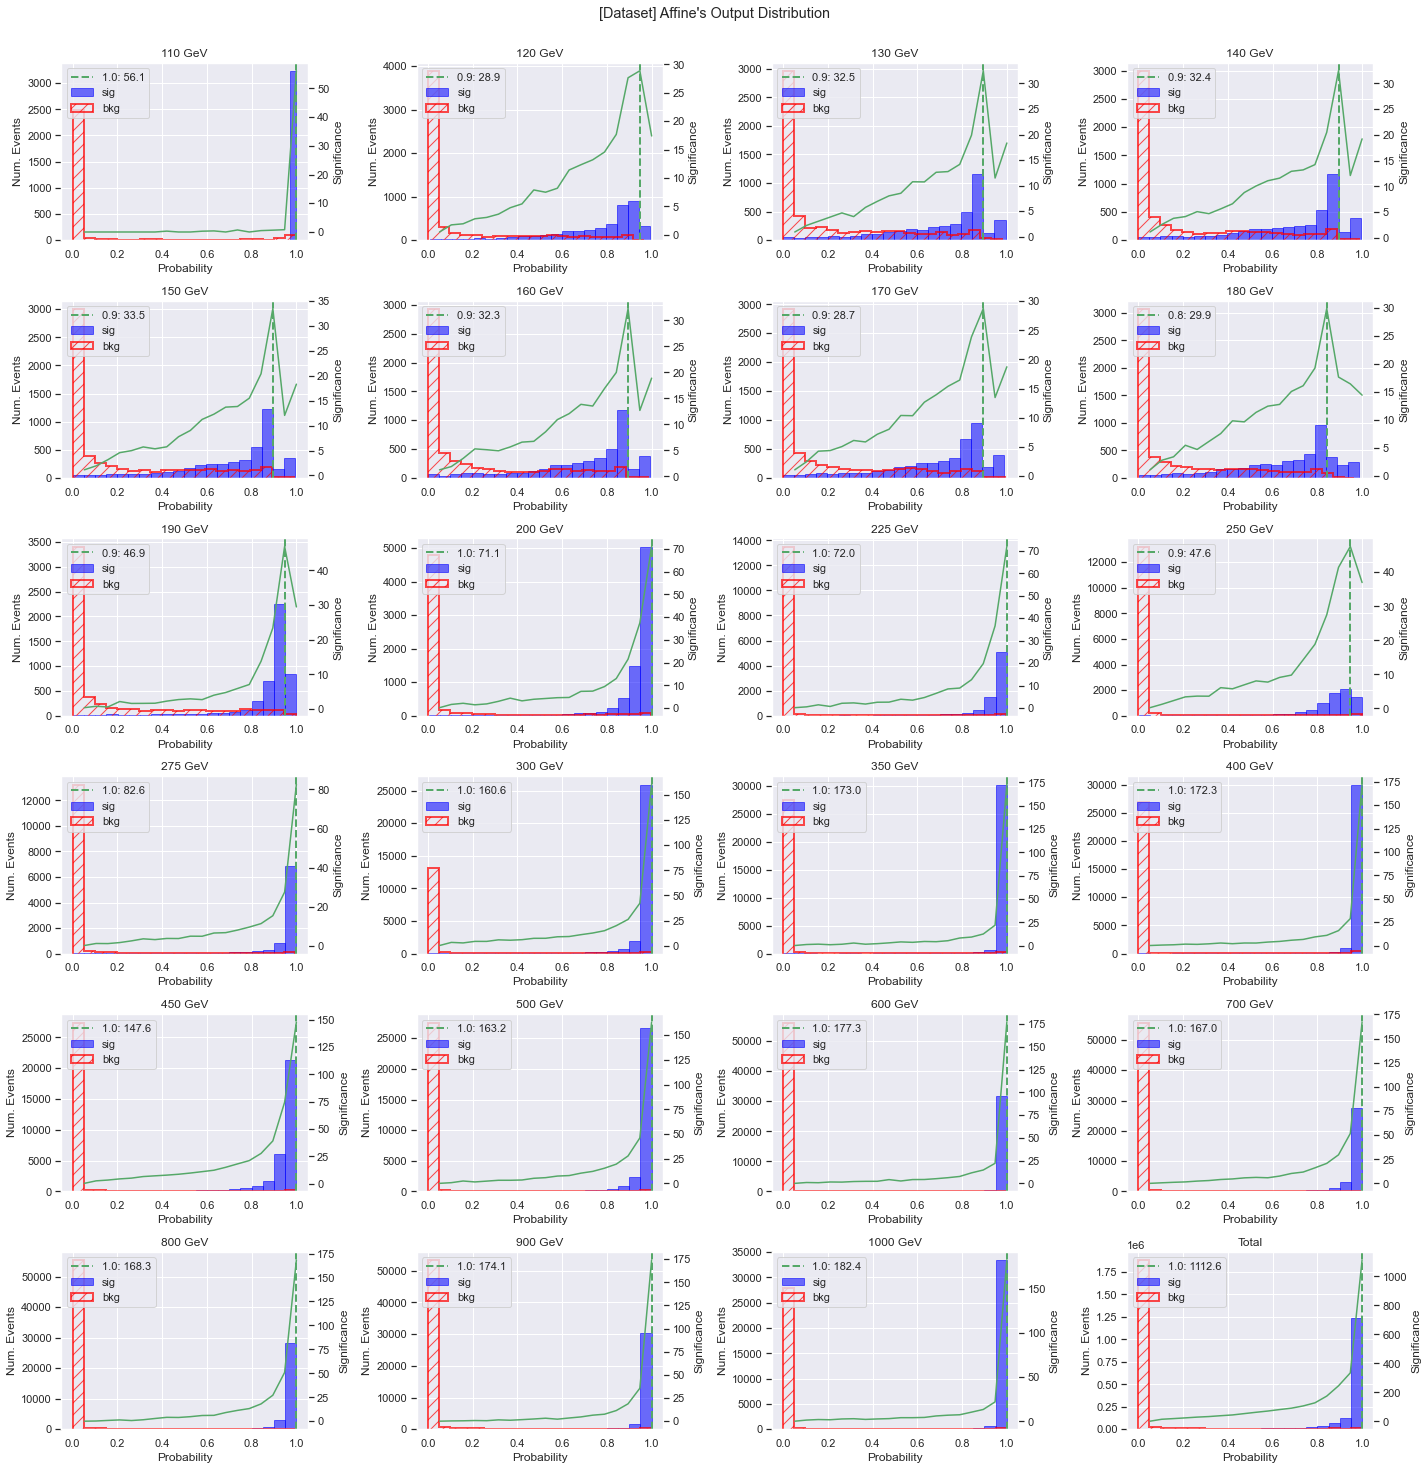

In [122]:
plot_significance(affine, data, name='Affine')

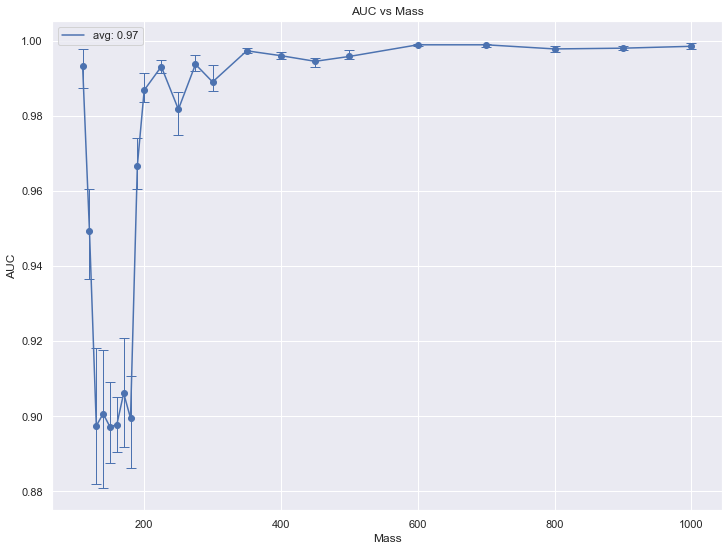

array([0.99333, 0.94928, 0.89751, 0.90071, 0.89718, 0.89784, 0.90624,
       0.89949, 0.96682, 0.98688, 0.99323, 0.98183, 0.99384, 0.98915,
       0.99741, 0.99607, 0.99464, 0.99588, 0.99903, 0.999  , 0.9979 ,
       0.99807, 0.99865])

In [13]:
auc_with_error(affine, data, silent=True)

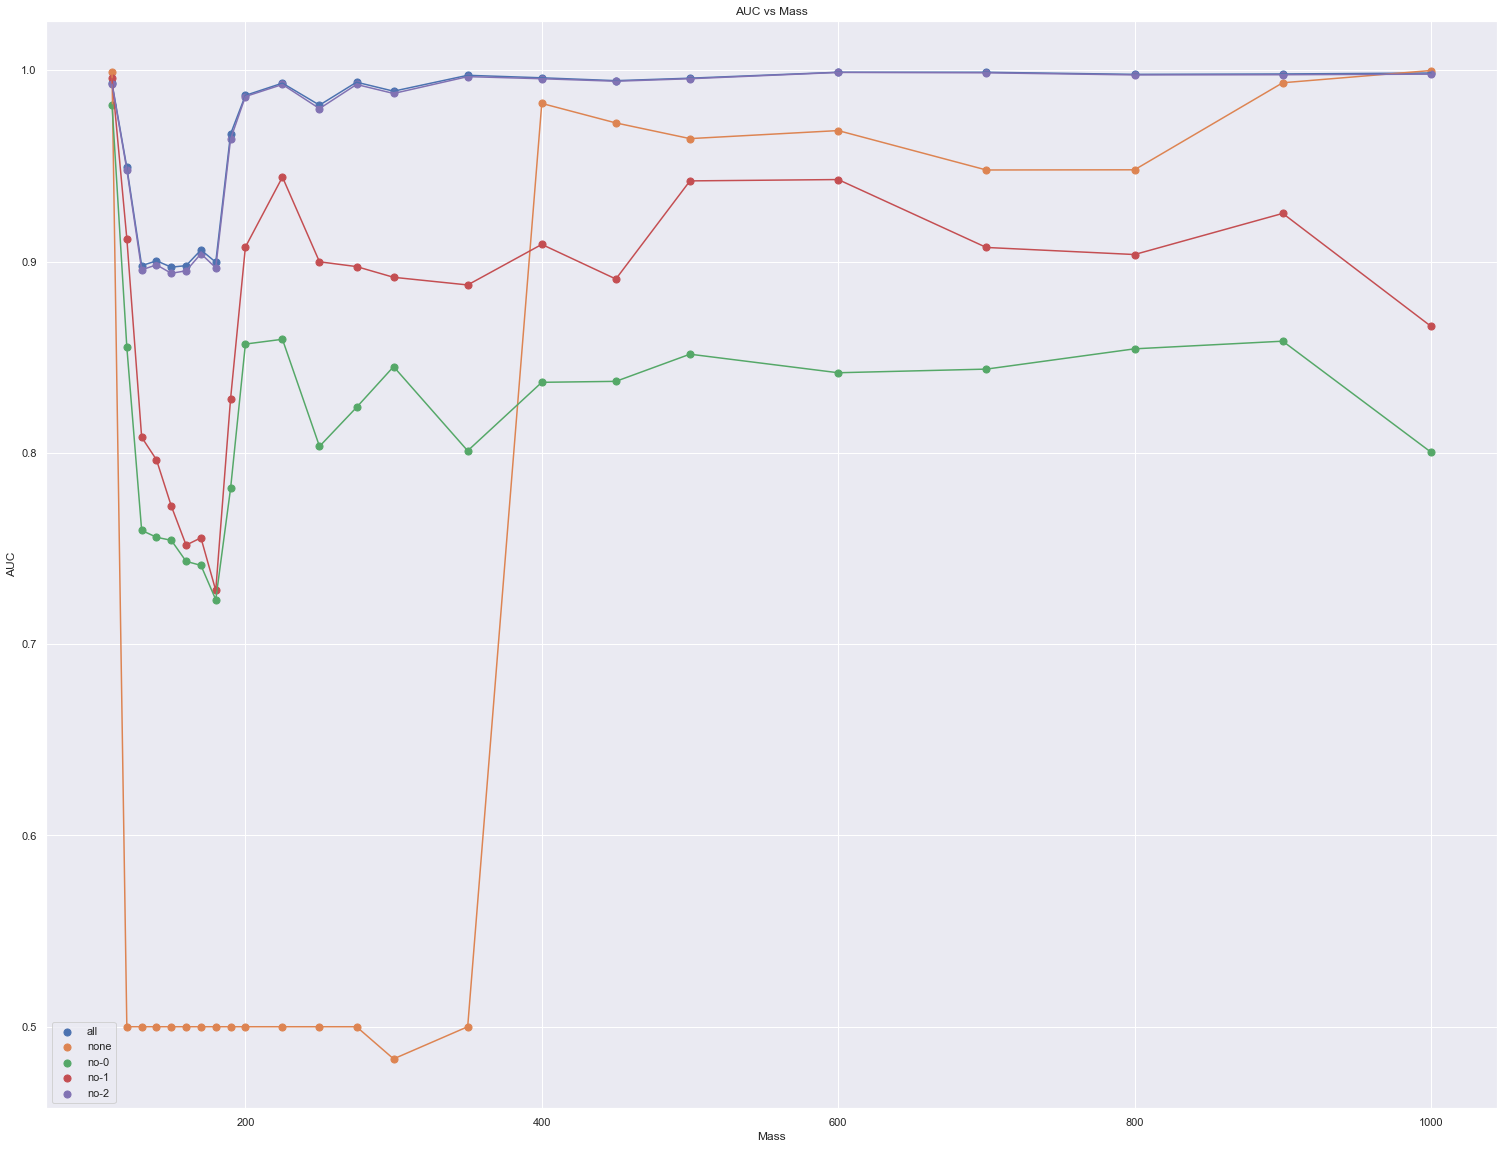

In [21]:
_ = auc_vs_mass_no_features(affine, data, features=features[0], verbose=0, silent=True)

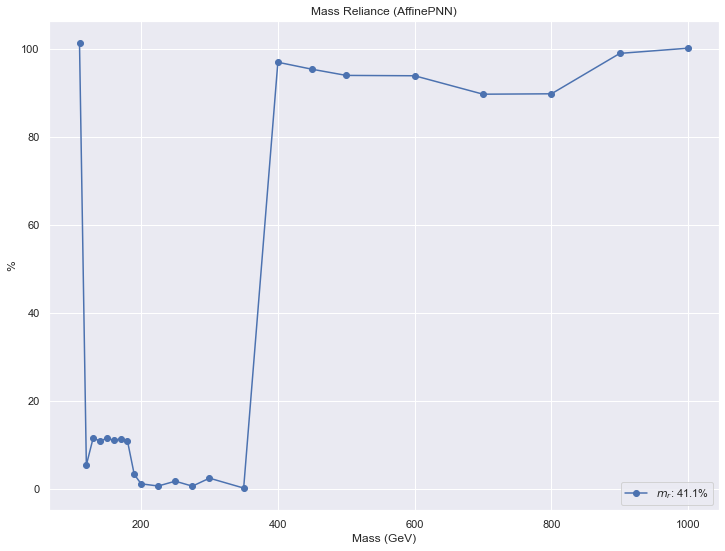

array([101.30890052,   5.51862404,  11.69440411,  10.93854005,
        11.64452384,  11.11111111,  11.45786893,  11.07408642,
         3.41261634,   1.25556906,   0.75566751,   1.85373803,
         0.7252216 ,   2.53868716,   0.29084345,  97.00713066,
        95.41524231,  94.01606426,  93.93332666,  89.7487236 ,
        89.83866119,  99.01803607, 100.20024029])

In [46]:
plot_mass_reliance(affine, data, name='AffinePNN')

---
AUC comparison:

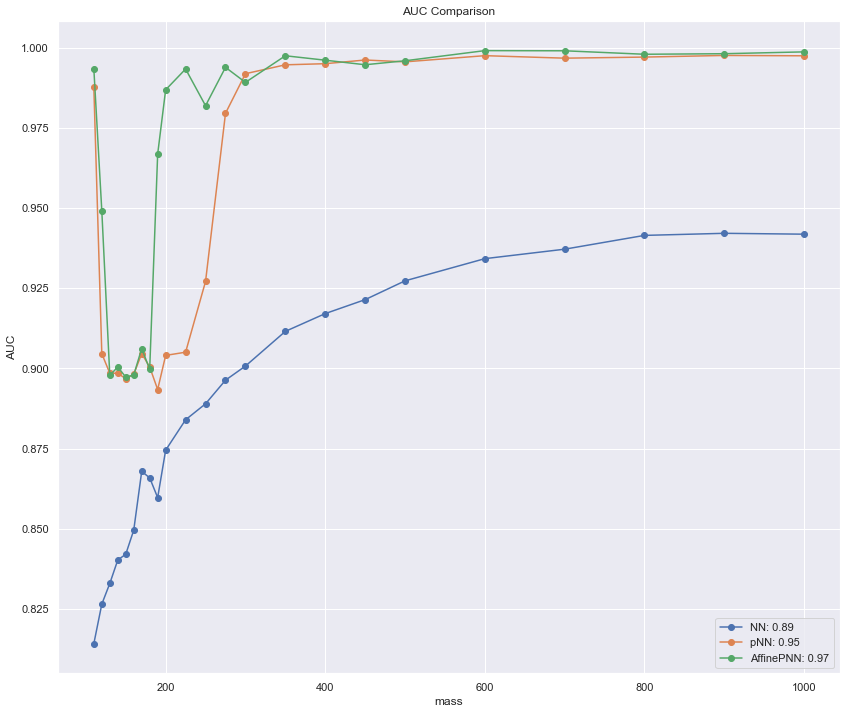

In [27]:
compare_plot(mass=data.unique_signal_mass,
         NN=[0.81422, 0.82654, 0.83298, 0.84028, 0.84209, 0.84958, 0.86791,
             0.86589, 0.85973, 0.87451, 0.88399, 0.88897, 0.89633, 0.90073,
             0.91154, 0.91708, 0.92143, 0.92729, 0.9342 , 0.93715, 0.94145,
             0.9421 , 0.94183],
         pNN=[0.98758, 0.90458, 0.8985 , 0.89849, 0.89678, 0.89815, 0.90462,
              0.90044, 0.89342, 0.90405, 0.90505, 0.9271 , 0.9795 , 0.99184,
              0.99461, 0.99496, 0.99611, 0.99553, 0.99746, 0.99668, 0.99702,
              0.99753, 0.99742],
         AffinePNN=[0.99339, 0.94906, 0.89779, 0.90047, 0.89726, 0.89793, 0.9062 ,
                    0.89971, 0.9668 , 0.98682, 0.9933 , 0.98187, 0.99382, 0.98914,
                    0.99743, 0.99605, 0.99463, 0.99587, 0.99903, 0.99898, 0.9979 ,
                    0.99807, 0.99864], size=(14, 12))

Mass reliance comparison:

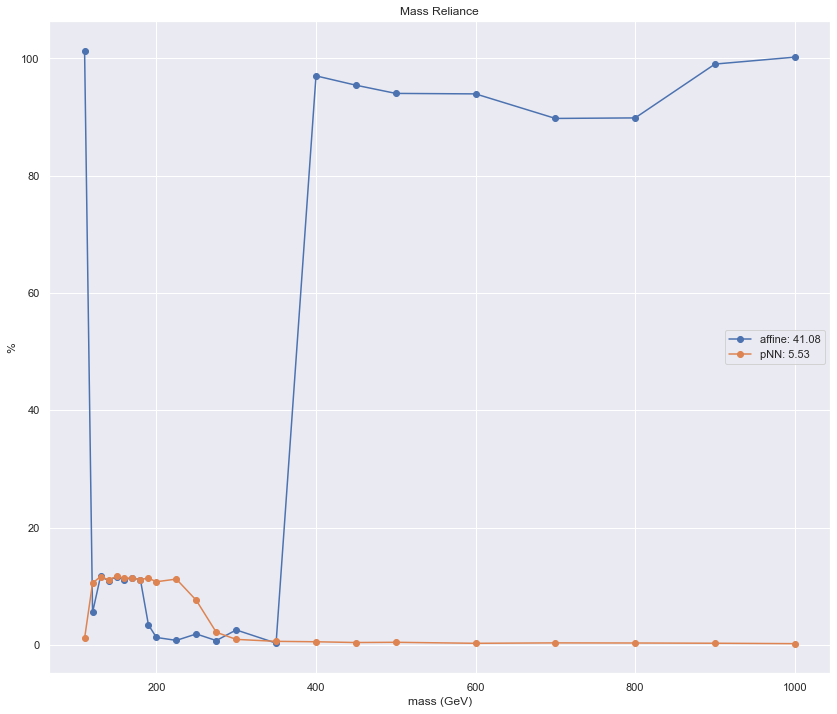

In [45]:
compare_plot(mass=data.unique_signal_mass, y_label='%', title='Mass Reliance',
             affine=[101.30890052,   5.51862404,  11.69440411,  10.93854005,
                     11.64452384,  11.11111111,  11.45786893,  11.07408642,
                     3.41261634,   1.25556906,   0.75566751,   1.85373803,
                     0.7252216 ,   2.53868716,   0.29084345,  97.00713066,
                     95.41524231,  94.01606426,  93.93332666,  89.7487236 ,
                     89.83866119,  99.01803607, 100.20024029],
             pNN=[1.11223458, 10.52166225, 11.64452384, 11.07408642, 11.6694584 ,
                  11.34617526, 11.3833816 , 11.13580796, 11.37097672, 10.75423635,
                  11.20996441,  7.58472297,  2.14504597,  0.92854259,  0.59350166,
                  0.52271813,  0.39152696,  0.43185699,  0.26067776,  0.33109261,
                  0.31096399,  0.27073097,  0.2004008],
             size=(14, 12))

### Robust
Clipped outliers.

In [123]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(robust=True)

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] clipping outliers..
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [24]:
num_features = len(data.columns['feature'])
features = []

j = -1
for i in range(num_features):
    # add an entry telling to drop only the i-th feature column
    if i % 3 == 0:
        features.append({'all': [], 'none': np.arange(0, num_features)})
        j += 1

    features[j][f'no-{i}'] = [i]

#### Non-parametric NN

In [124]:
nn, checkpoint = get_compiled_non_parametric(save='tom/baseline-nn-robust')

In [11]:
nn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
       epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 83.68, AUC: 91.75

Epoch 1/20
21410/21410 [==============================] - 99s 5ms/step - loss: 0.4222 - binary_accuracy: 0.8201 - auc: 0.9005 - precision: 0.7720 - recall: 0.8333 - lr: 0.0010 - grad-norm: 1.4313 - weight-norm: 33.5675 - reg-losses: 0.0000e+00 - val_loss: 0.3763 - val_binary_accuracy: 0.8289 - val_auc: 0.9096 - val_precision: 0.7939 - val_recall: 0.8189
Epoch 2/20
21410/21410 [==============================] - 97s 5ms/step - loss: 0.2915 - binary_accuracy: 0.8292 - auc: 0.9093 - precision: 0.7825 - recall: 0.8421 - lr: 0.0010 - grad-norm: 1.2881 - weight-norm: 55.3006 - reg-losses: 0.0000e+00 - val_loss: 0.3681 - val_binary_accuracy: 0.8311 - val_auc: 0.9120 - val_precision: 0.7879 - val_recall: 0.8368
Epoch 3/20
21410/21410 [==============================] - 99s 5ms/step - loss: 0.3751 - binary_accuracy: 0.8320 - auc: 0.9121 - precision: 0.7849 - recall: 0.8462 - lr: 0.0010 - grad-norm: 1.1885 - weight-norm: 70.1566 - reg-losses: 0.0000e+00 - val_loss: 0.3647 - val_binary_accuracy: 0.

In [125]:
nn.load_weights('weights/tom/baseline-nn-robust/weights-19-0.918')

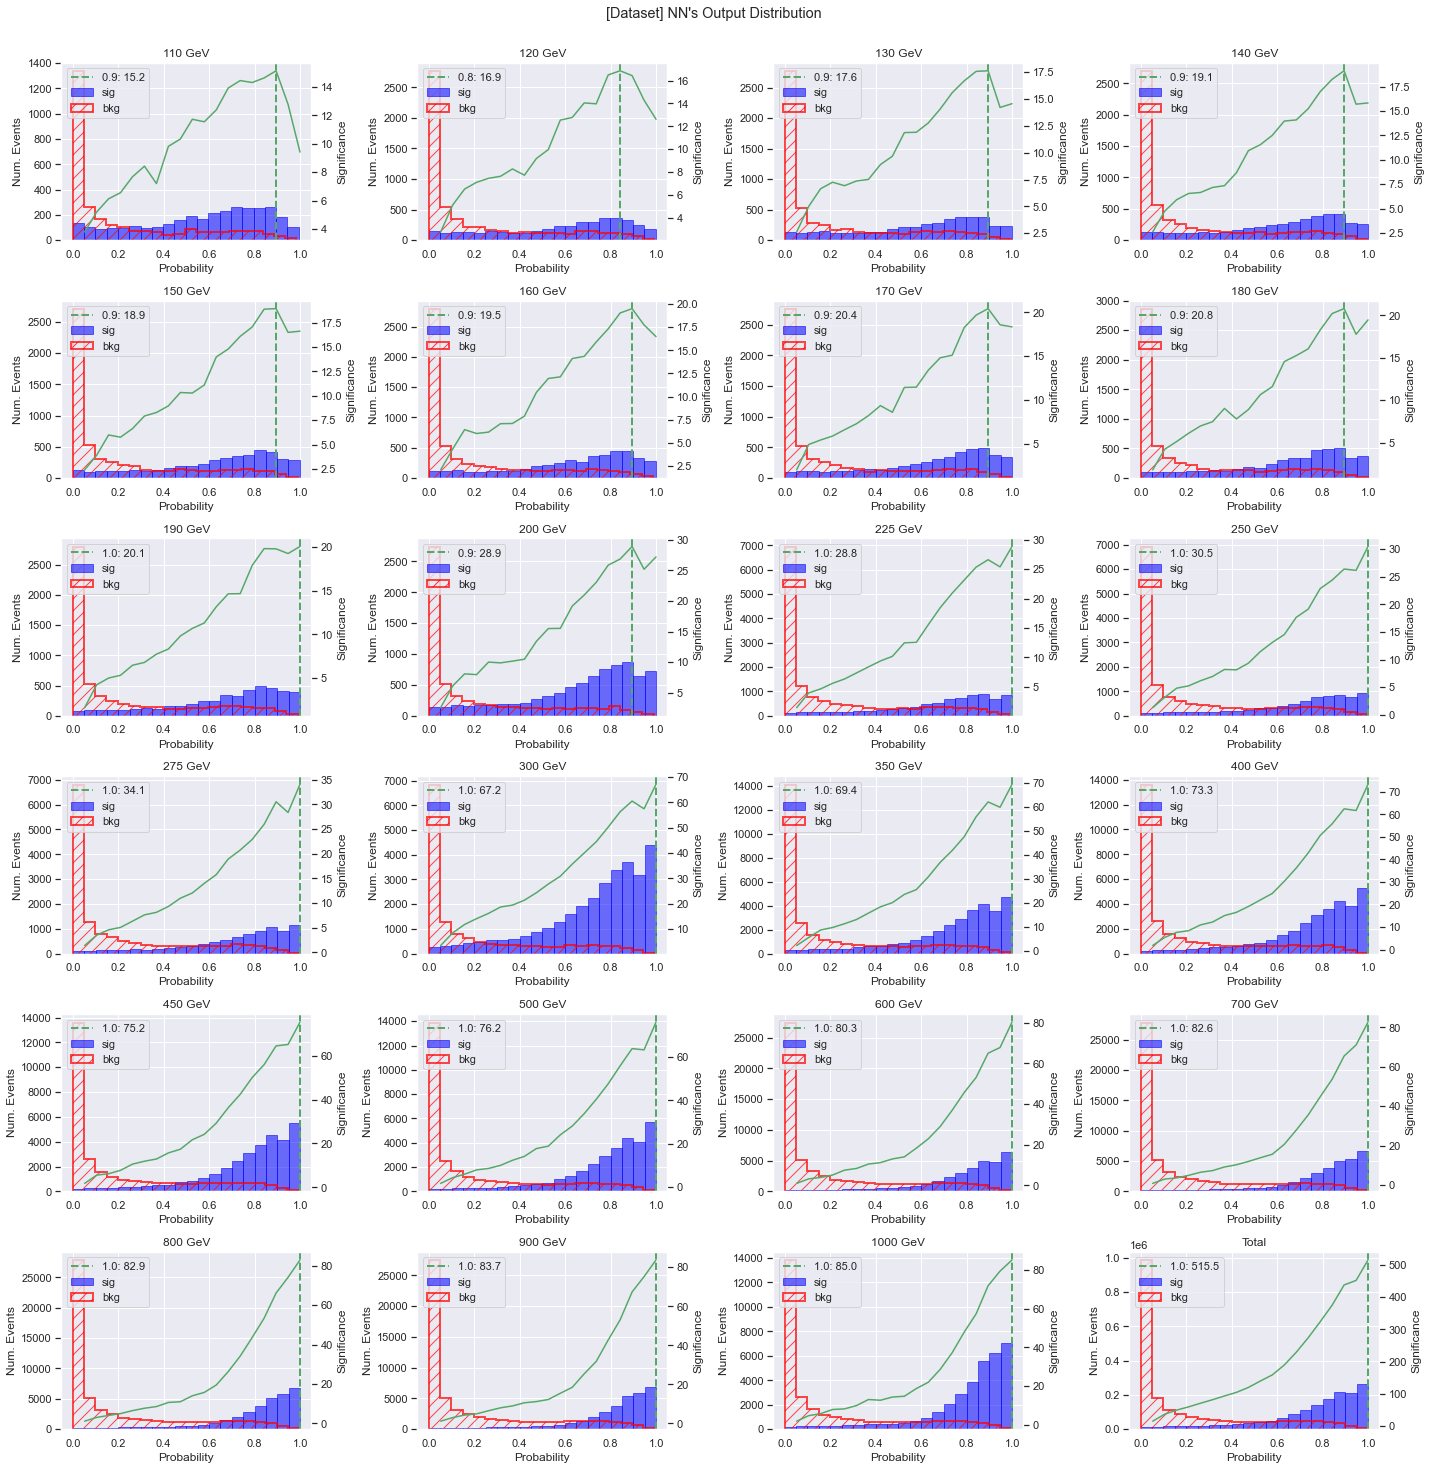

In [126]:
plot_significance(nn, data, name='NN')

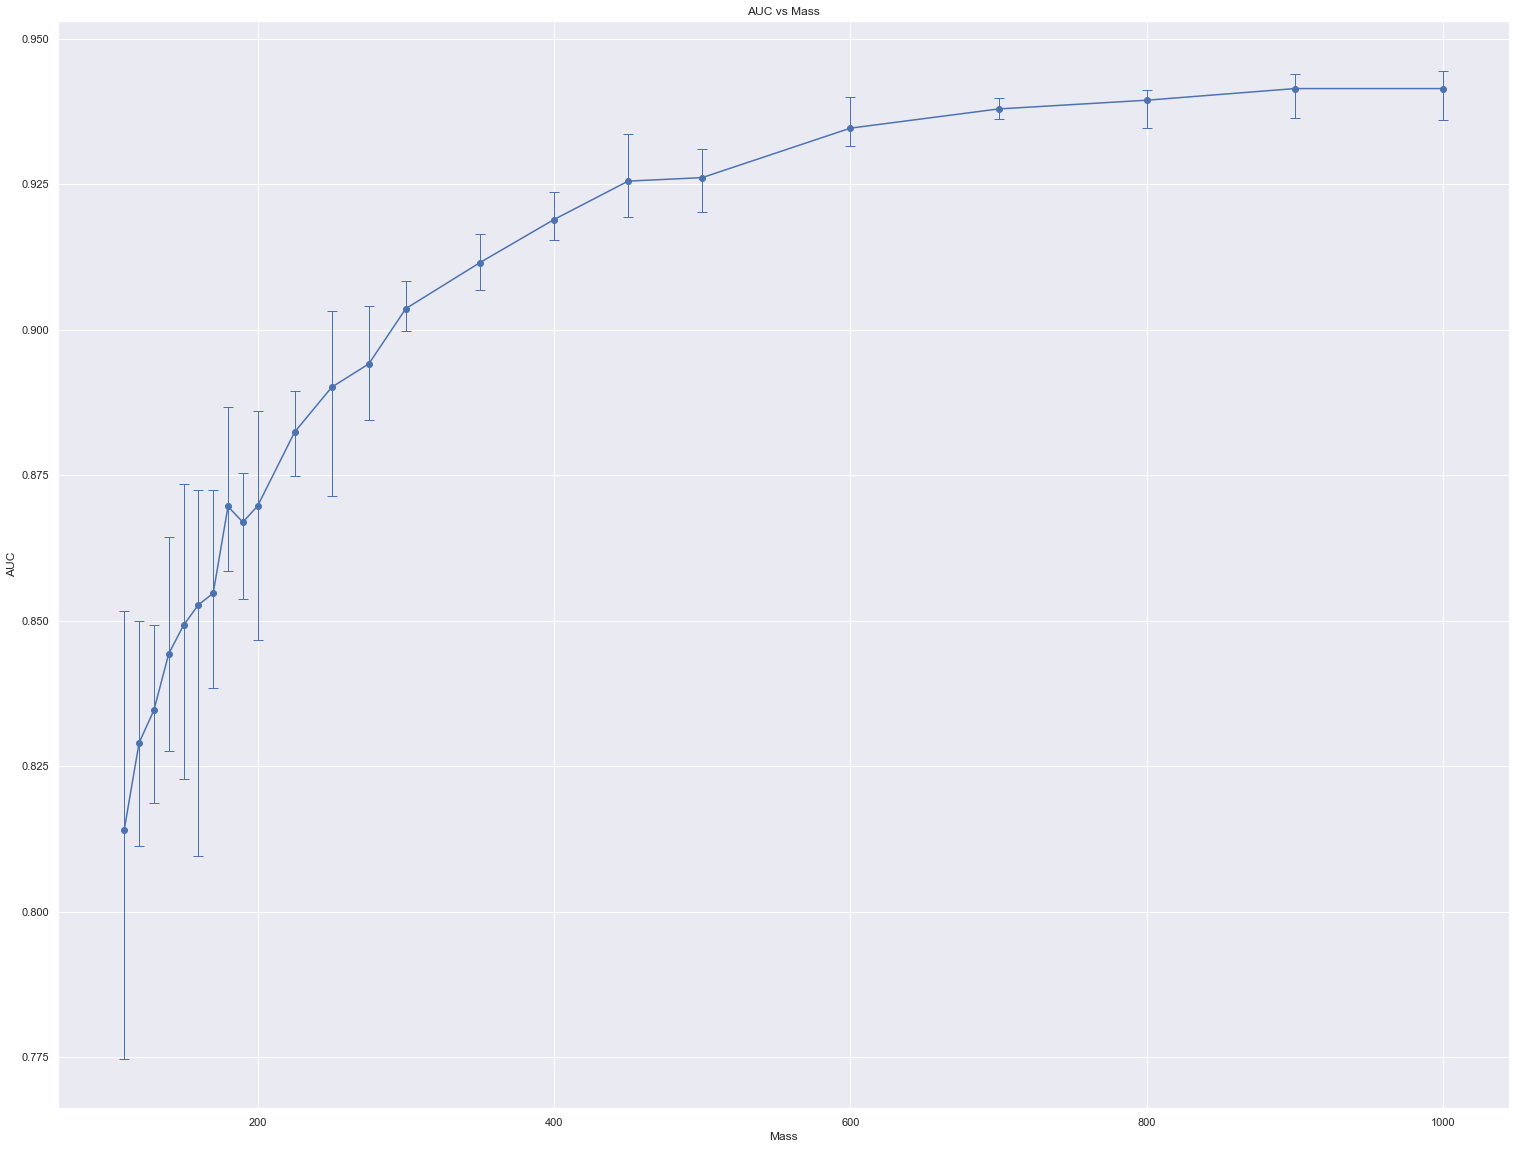

array([0.8141 , 0.82904, 0.83457, 0.84429, 0.84917, 0.85269, 0.85473,
       0.86963, 0.86691, 0.86973, 0.88241, 0.8901 , 0.89412, 0.90356,
       0.91149, 0.91894, 0.92546, 0.92609, 0.93465, 0.93788, 0.9394 ,
       0.94143, 0.94135])

In [27]:
auc_with_error(nn, data, silent=True)

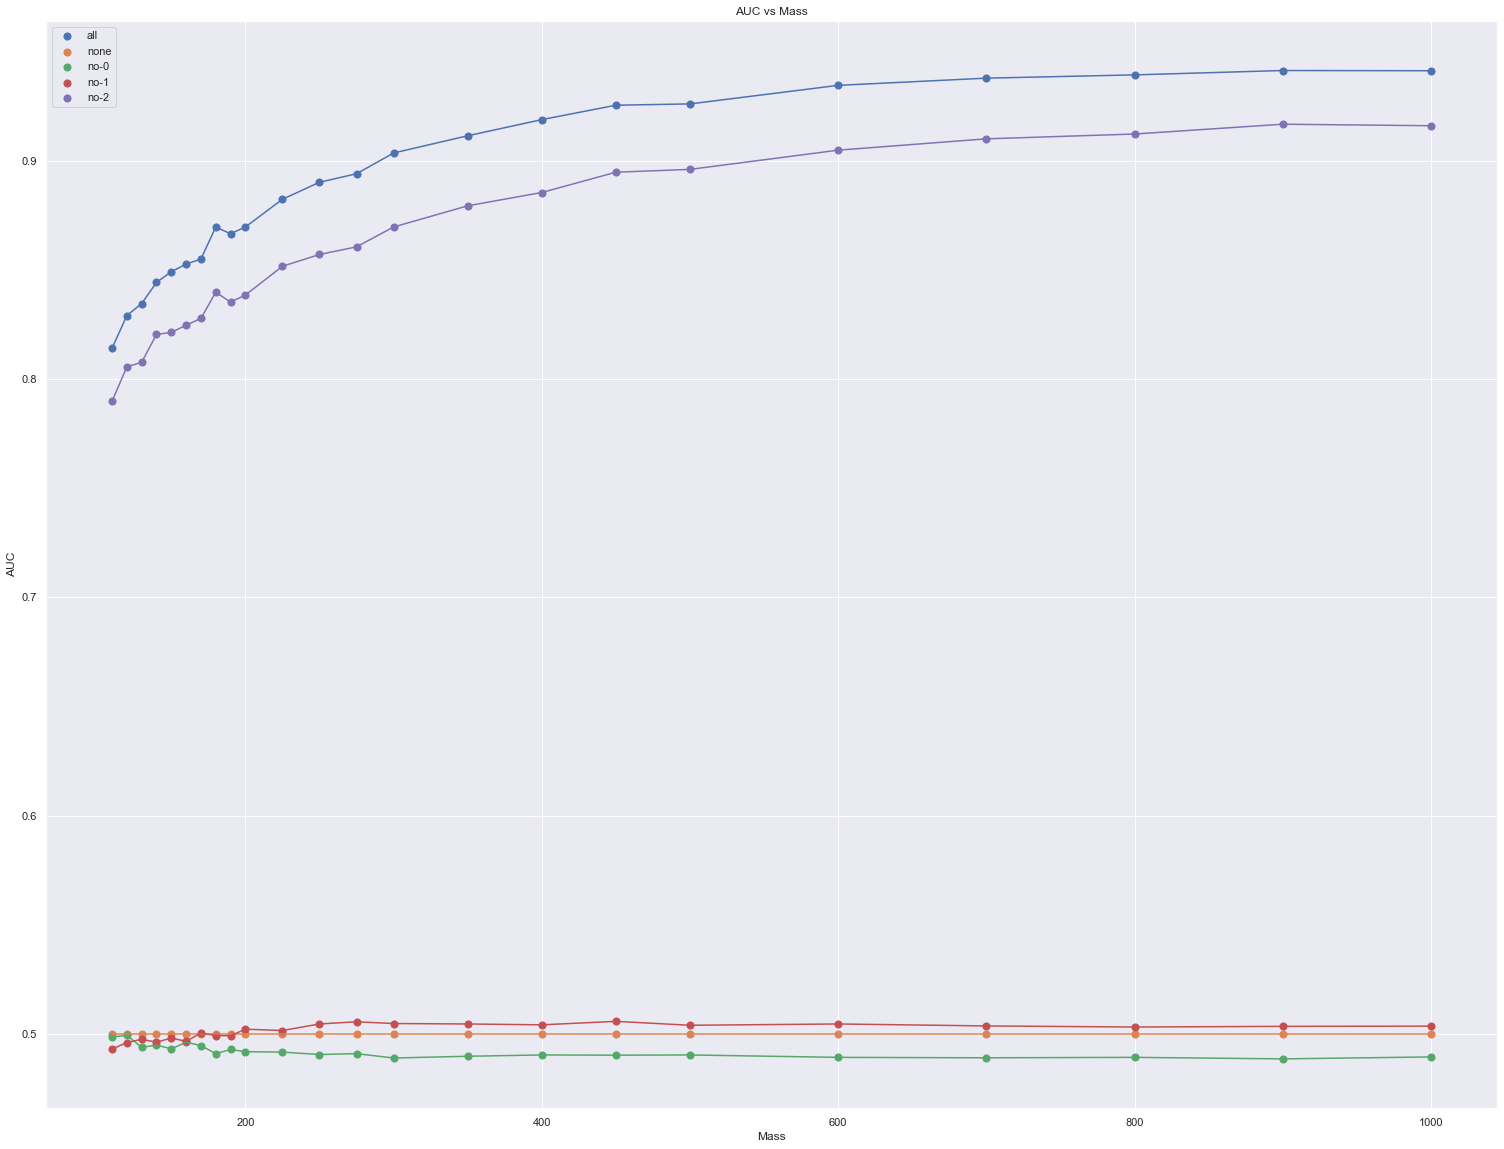

In [28]:
_ = auc_vs_mass_no_features(nn, data, features=features[0], verbose=0, silent=True)

#### PNN

In [127]:
pnn, checkpoint = get_compiled_pnn(save='tom/baseline-pnn-robust')
pnn.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 14)           0           m[0][0]                          
                                                                 x[0][0]                          
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 300)          4500        concatenate_3[0][0]   

In [8]:
h = pnn.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
            epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 95.85, AUC: 99.26

Epoch 1/20
21410/21410 [==============================] - 79s 4ms/step - loss: 0.3136 - binary_accuracy: 0.8402 - auc: 0.9186 - precision: 0.7896 - recal: 0.8632 - lr: 0.0010 - grad-norm: 1.9225 - weight-norm: 37.9460 - reg-losses: 0.0000e+00 - val_loss: 0.3383 - val_binary_accuracy: 0.8432 - val_auc: 0.9256 - val_precision: 0.8150 - val_recal: 0.8271
Epoch 2/20
21410/21410 [==============================] - 76s 4ms/step - loss: 0.2426 - binary_accuracy: 0.8558 - auc: 0.9324 - precision: 0.8077 - recal: 0.8780 - lr: 0.0010 - grad-norm: 2.4675 - weight-norm: 63.9784 - reg-losses: 0.0000e+00 - val_loss: 0.3091 - val_binary_accuracy: 0.8601 - val_auc: 0.9378 - val_precision: 0.8161 - val_recal: 0.8755
Epoch 3/20
21410/21410 [==============================] - 77s 4ms/step - loss: 0.3135 - binary_accuracy: 0.8624 - auc: 0.9381 - precision: 0.8158 - recal: 0.8837 - lr: 0.0010 - grad-norm: 2.7432 - weight-norm: 80.2816 - reg-losses: 0.0000e+00 - val_loss: 0.3029 - val_binary_accuracy: 0.8660 

In [128]:
pnn.load_weights('weights/tom/baseline-pnn-robust/weights-17-0.993')

* With outliers clipping a PNN can gather **+2% in AUC**, thus matching an AffinePNN without its downsides.
* Accuracy is still 2% lower.

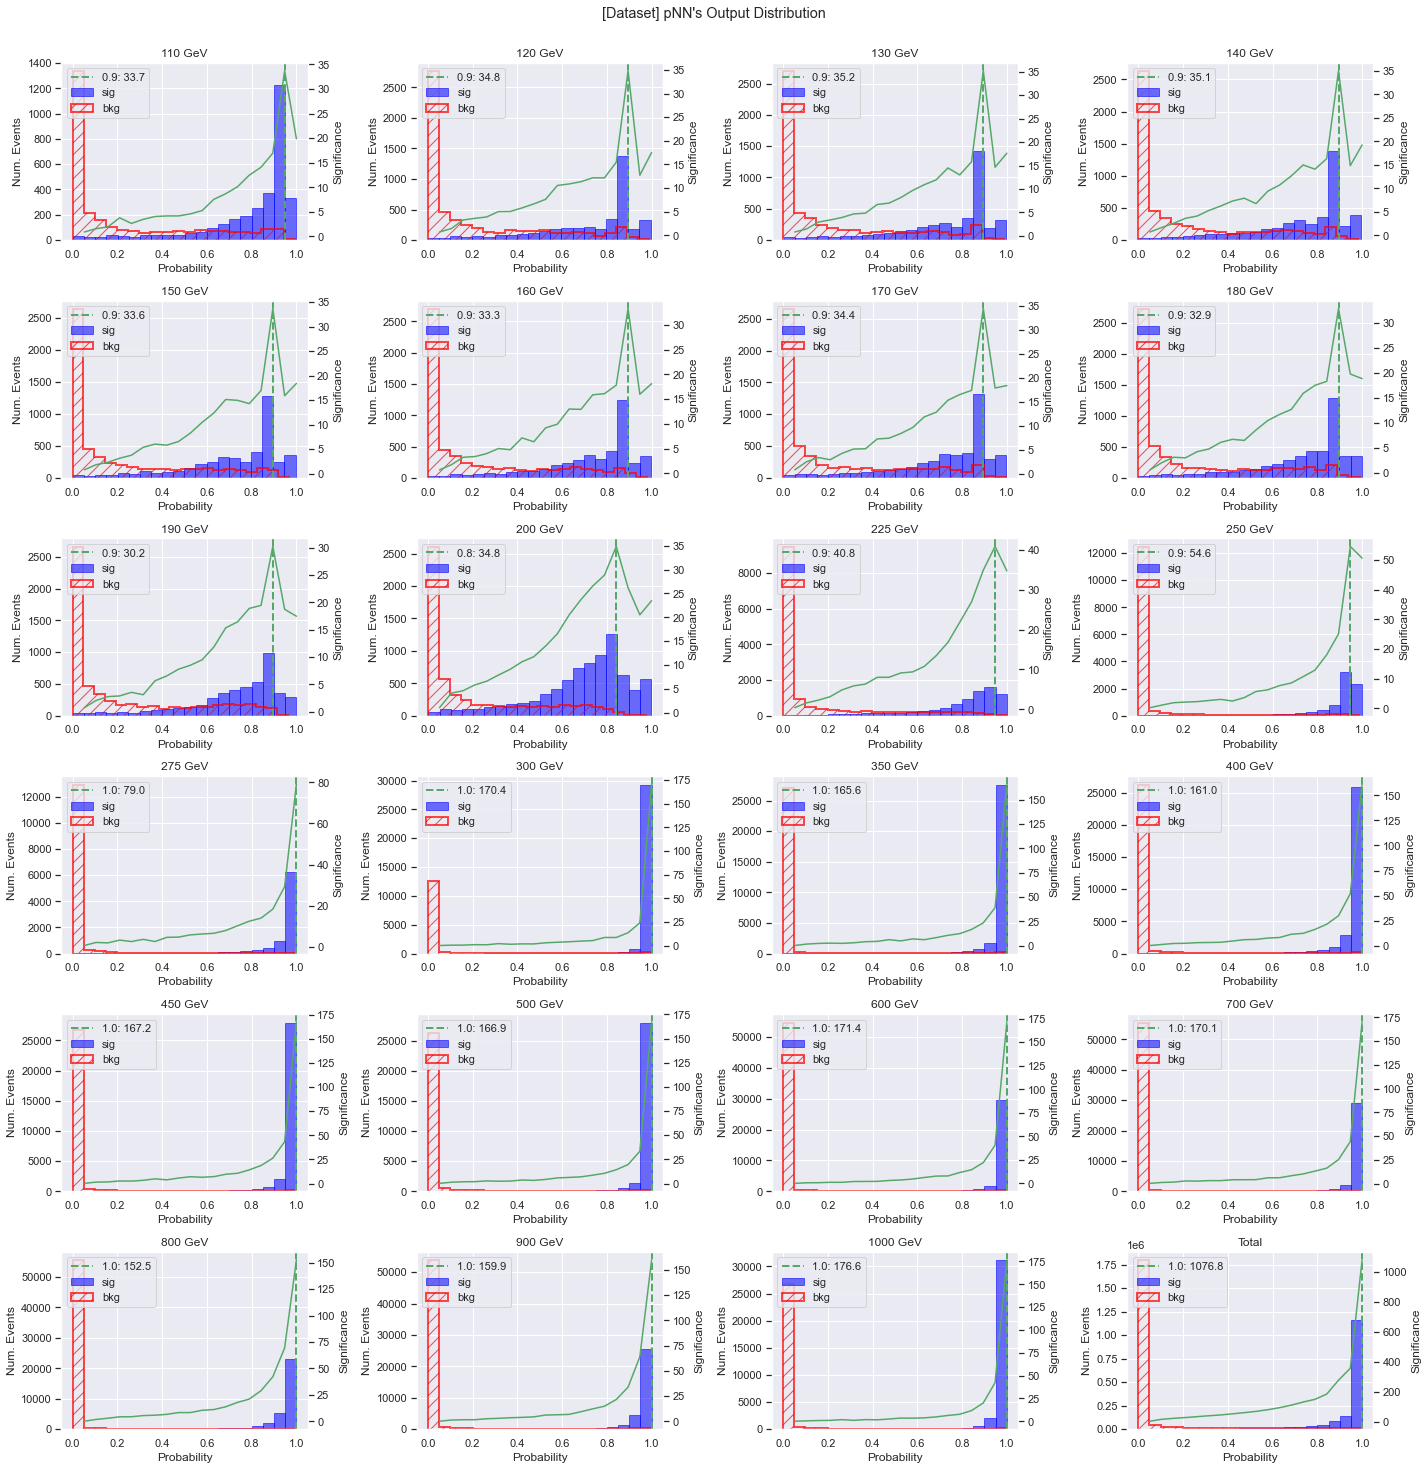

In [129]:
plot_significance(pnn, data, name='pNN')

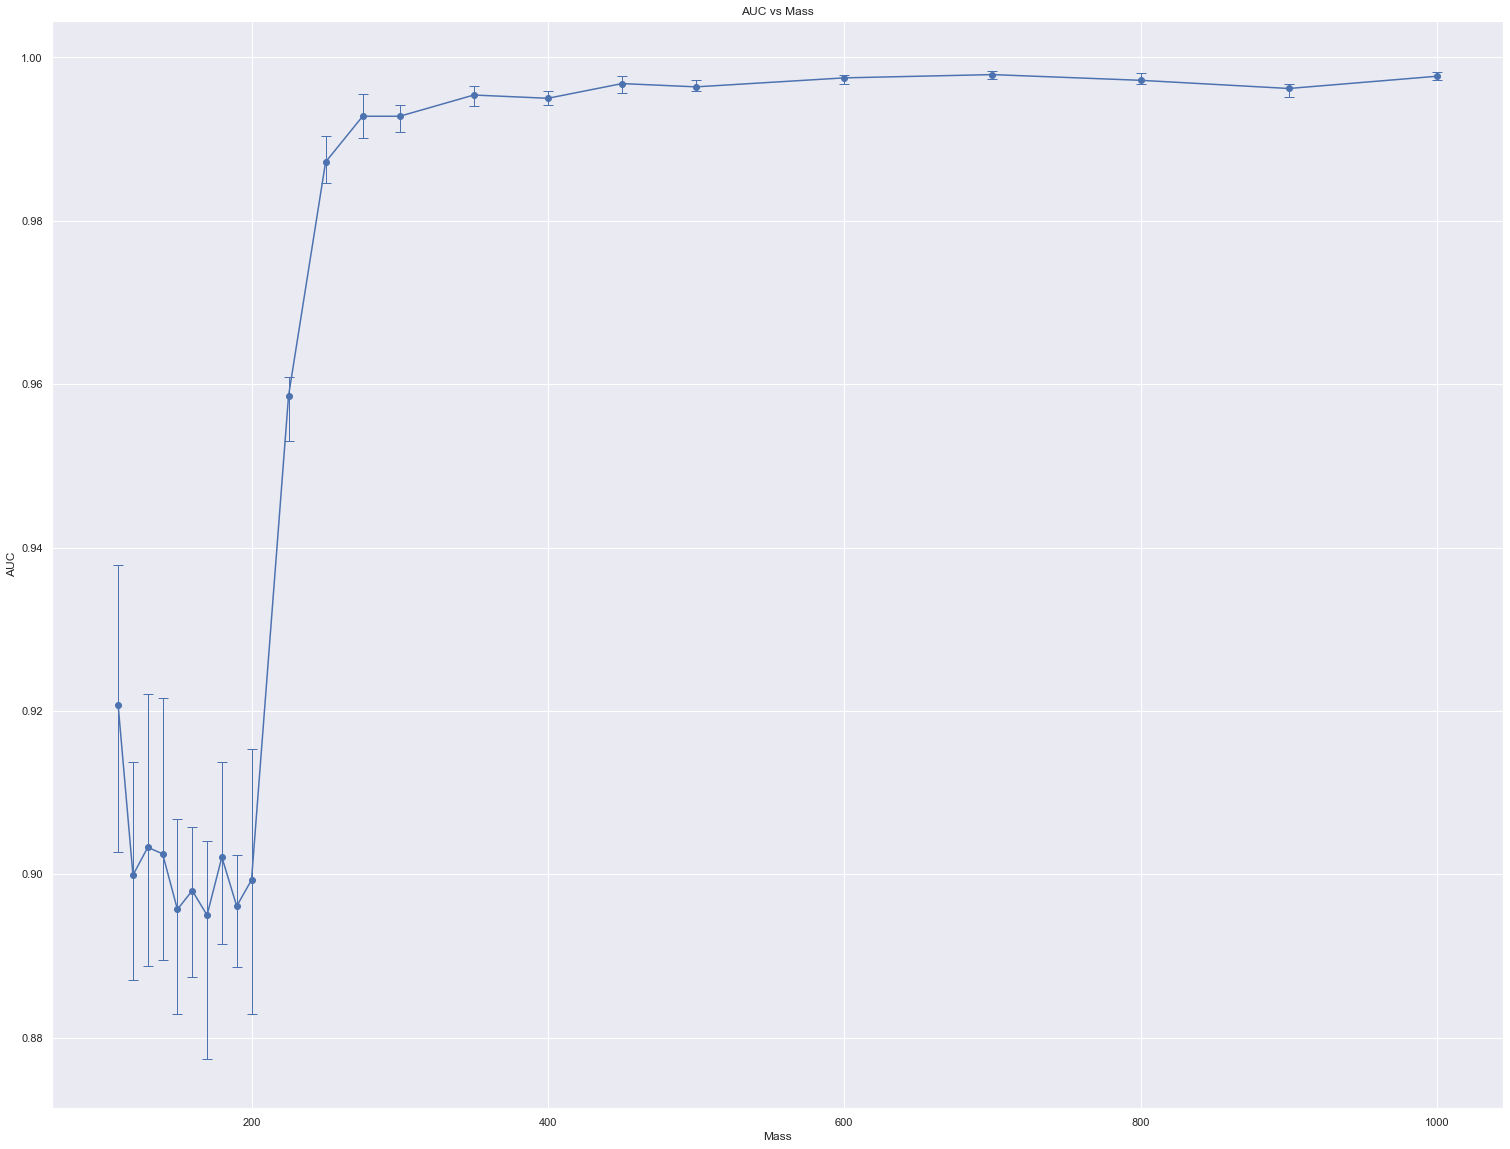

array([0.92071, 0.89985, 0.9033 , 0.90252, 0.89568, 0.89802, 0.895  ,
       0.90208, 0.89609, 0.89927, 0.95864, 0.9872 , 0.99275, 0.99276,
       0.99542, 0.99502, 0.99683, 0.99641, 0.99748, 0.99786, 0.99718,
       0.99615, 0.99766])

In [31]:
auc_with_error(pnn, data, silent=True)

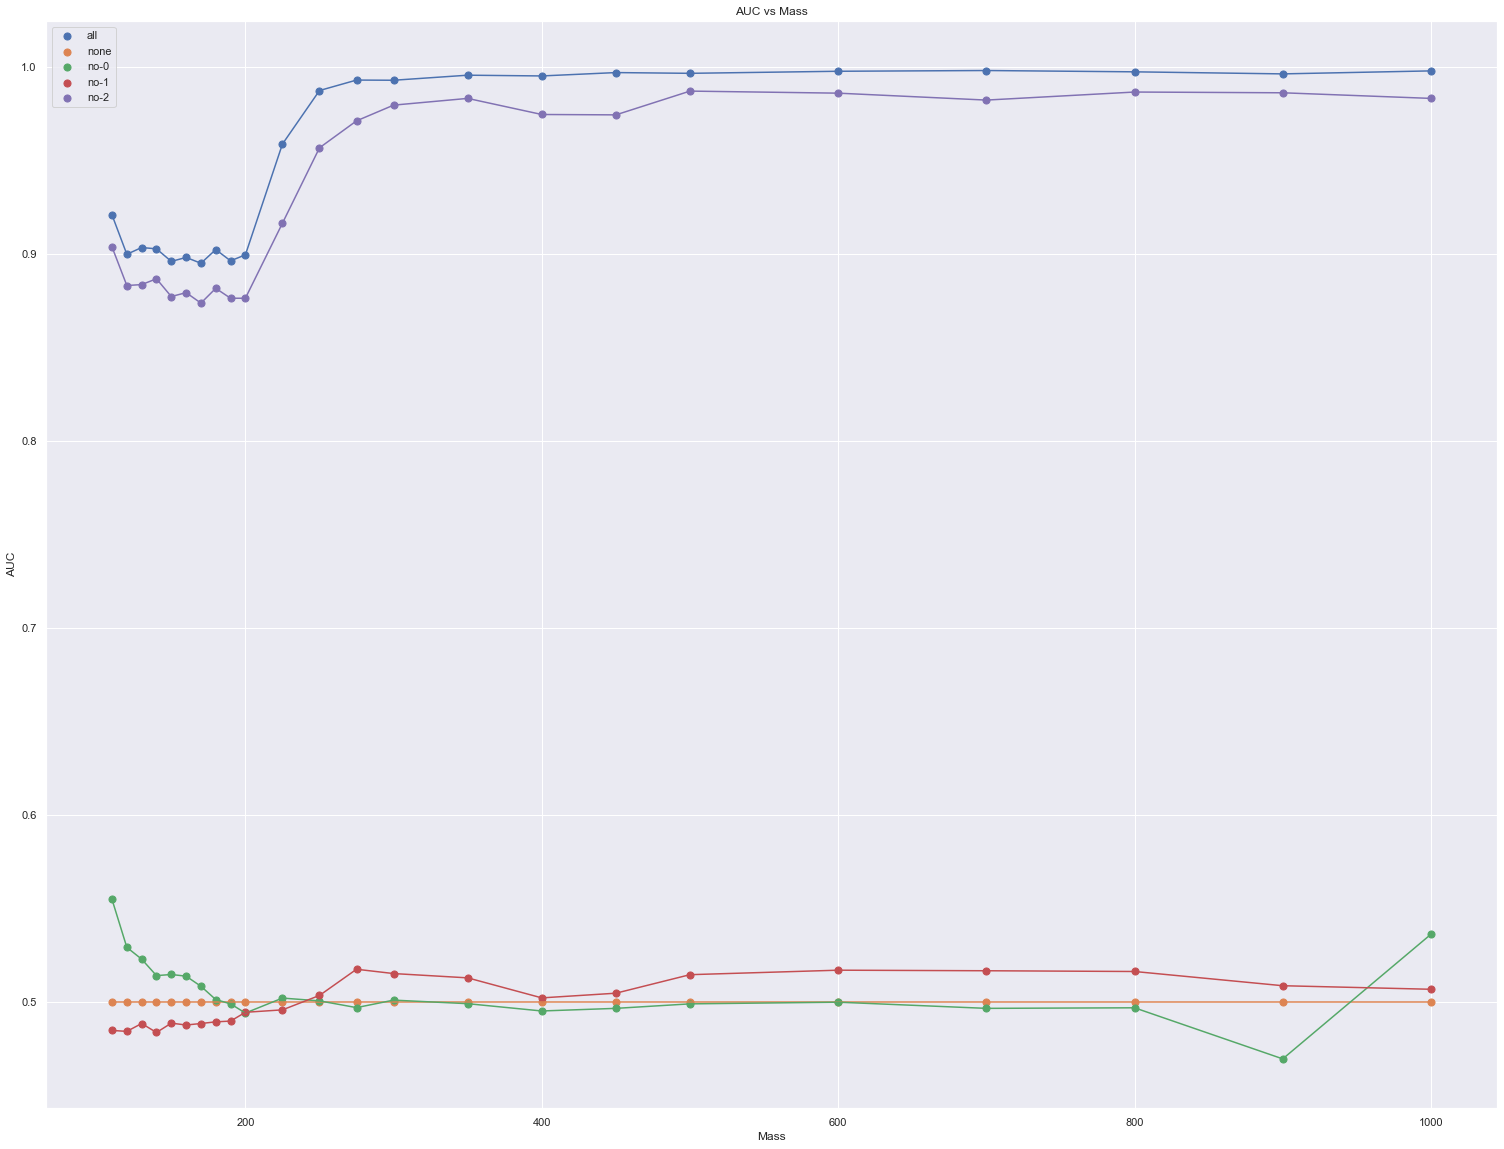

In [32]:
_ = auc_vs_mass_no_features(pnn, data, features=features[0], verbose=0, silent=True)

#### AffinePNN

In [130]:
affine, checkpoint = get_compiled_affine_pnn(save='tom/baseline-affine-robust',
                                             track_mass_reliance=True)
affine.summary()

Model: "ParametricNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 300)          4200        x[0][0]                          
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
affine-0 (AffineConditioning)   (None, 300)          1200        dense_44[0][0]                   
                                                                 m[0][0]               

In [9]:
h = affine.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
               epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 97.37, AUC: 99.51

Epoch 1/20
21410/21410 [==============================] - 95s 4ms/step - loss: 0.3248 - binary_accuracy: 0.8352 - auc: 0.9152 - precision: 0.7902 - recal: 0.8464 - cls-loss: 0.3604 - lr: 0.0010 - grad-norm: 1.2132 - weight-norm: 59.1565 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.3374 - val_binary_accuracy: 0.8428 - val_auc: 0.9271 - val_precision: 0.8224 - val_recal: 0.8142
Epoch 2/20
21410/21410 [==============================] - 94s 4ms/step - loss: 0.1237 - binary_accuracy: 0.8855 - auc: 0.9546 - precision: 0.8440 - recal: 0.9044 - cls-loss: 0.2653 - lr: 0.0010 - grad-norm: 8.2854 - weight-norm: 113.9863 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - val_loss: 0.1761 - val_binary_accuracy: 0.9269 - val_auc: 0.9802 - val_precision: 0.8936 - val_recal: 0.9443
Epoch 3/20
21410/21410 [==============================] - 92s 4ms/step - loss: 0.1375 - binary_accuracy: 0.9318 - auc: 0.9806 - precision: 0.9027 - recal: 0.9453 - cls-loss: 0.1699 - lr: 0.00

In [131]:
affine.load_weights('weights/tom/baseline-affine-robust/weights-20-0.995')

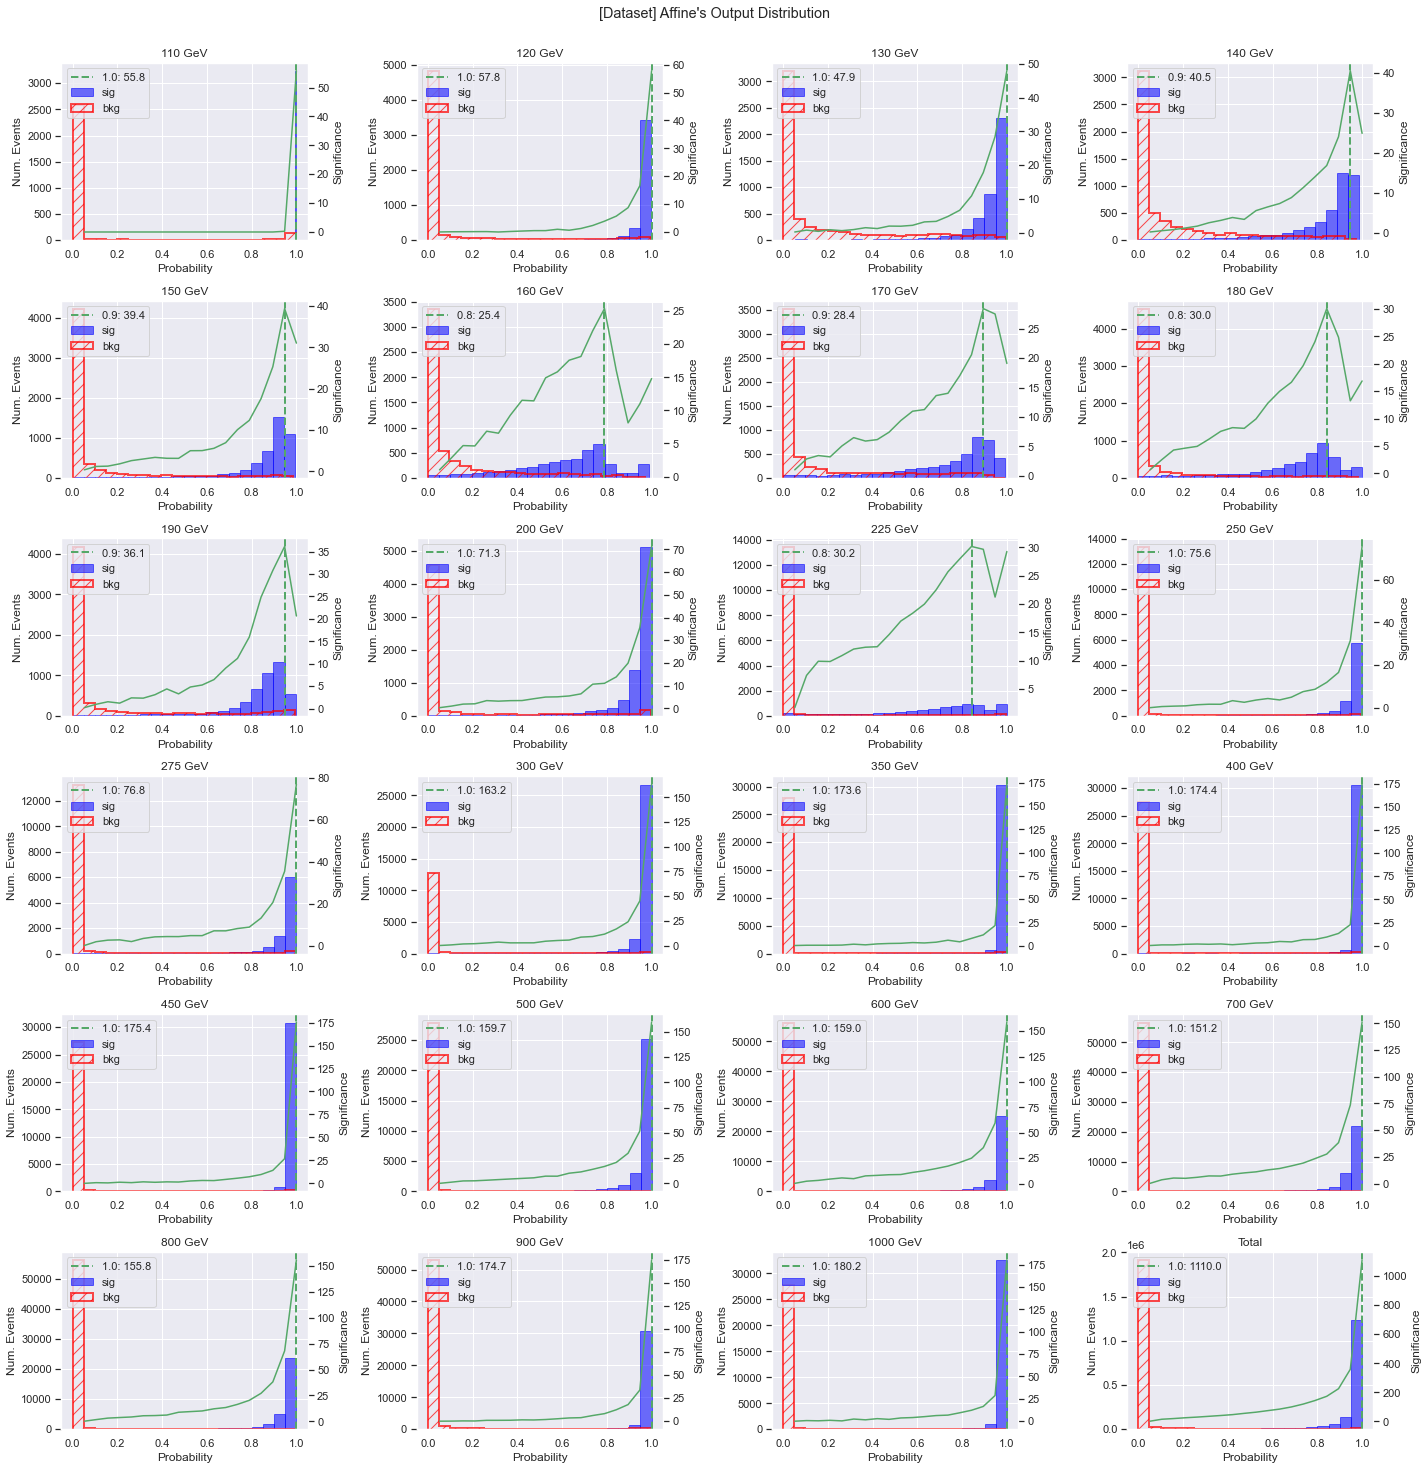

In [132]:
plot_significance(affine, data, name='Affine')

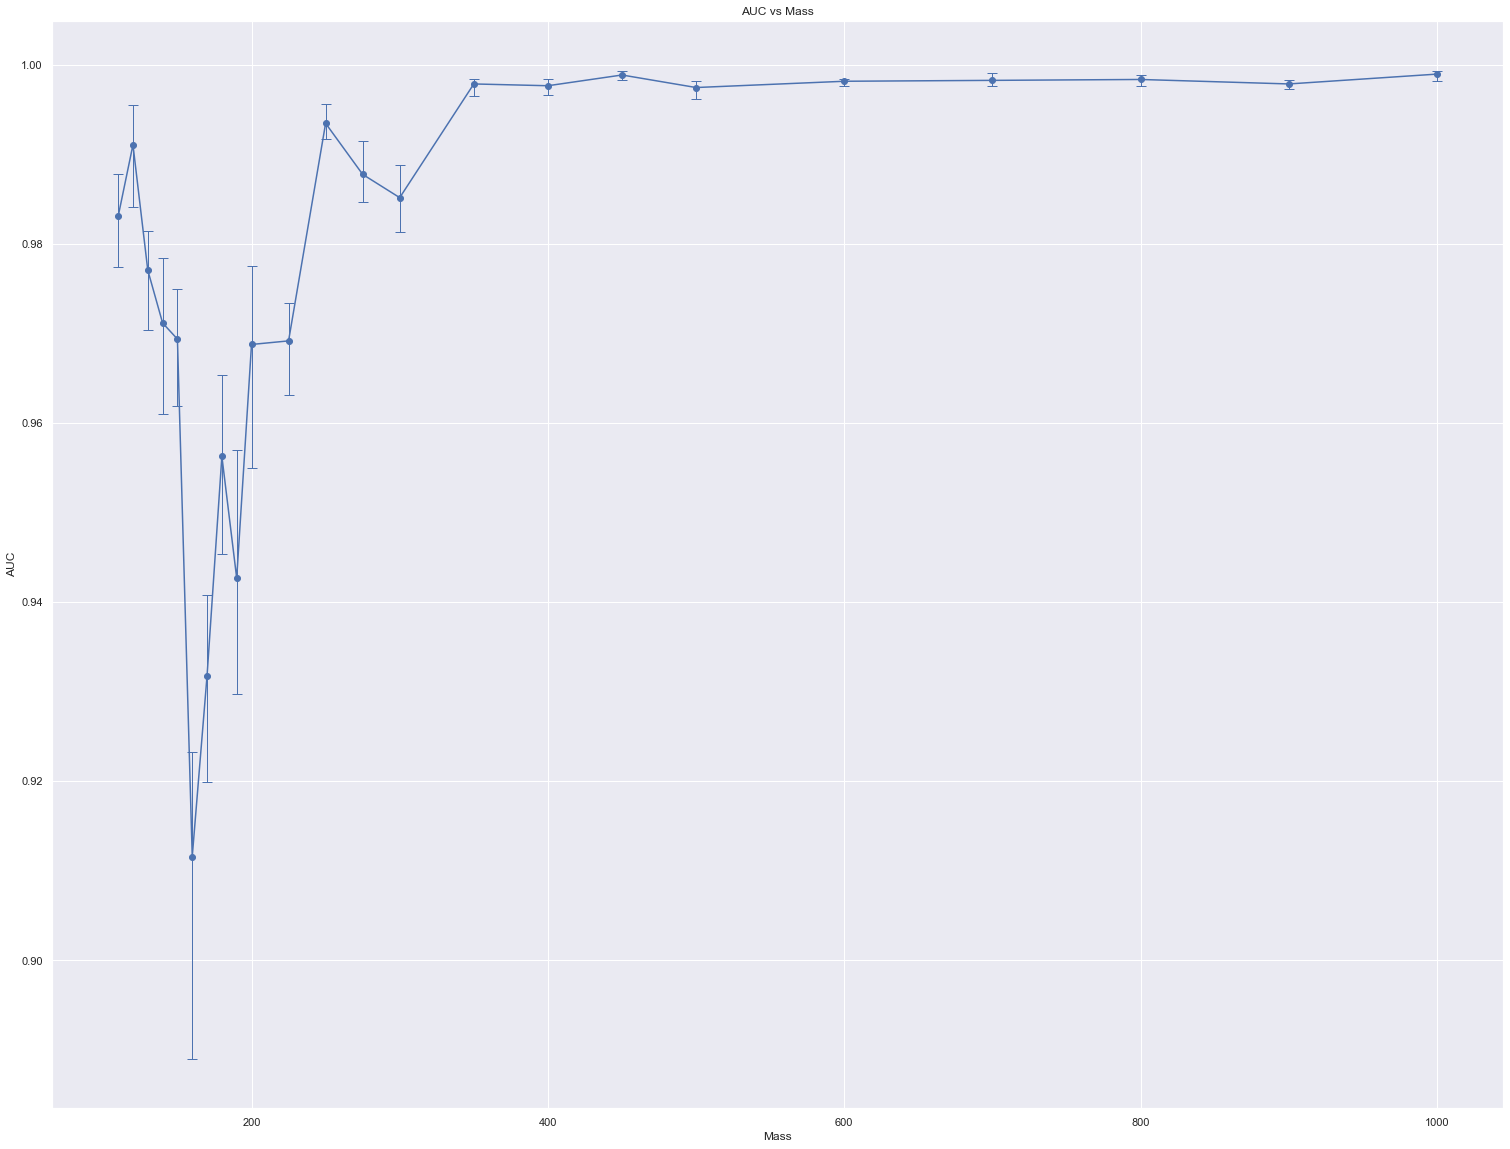

array([0.98309, 0.9911 , 0.97709, 0.97116, 0.96942, 0.91162, 0.93177,
       0.95634, 0.94267, 0.96882, 0.96917, 0.99349, 0.98785, 0.98522,
       0.99786, 0.99766, 0.99887, 0.99747, 0.99824, 0.9983 , 0.99838,
       0.99787, 0.999  ])

In [35]:
auc_with_error(affine, data, verbose=0, silent=True)

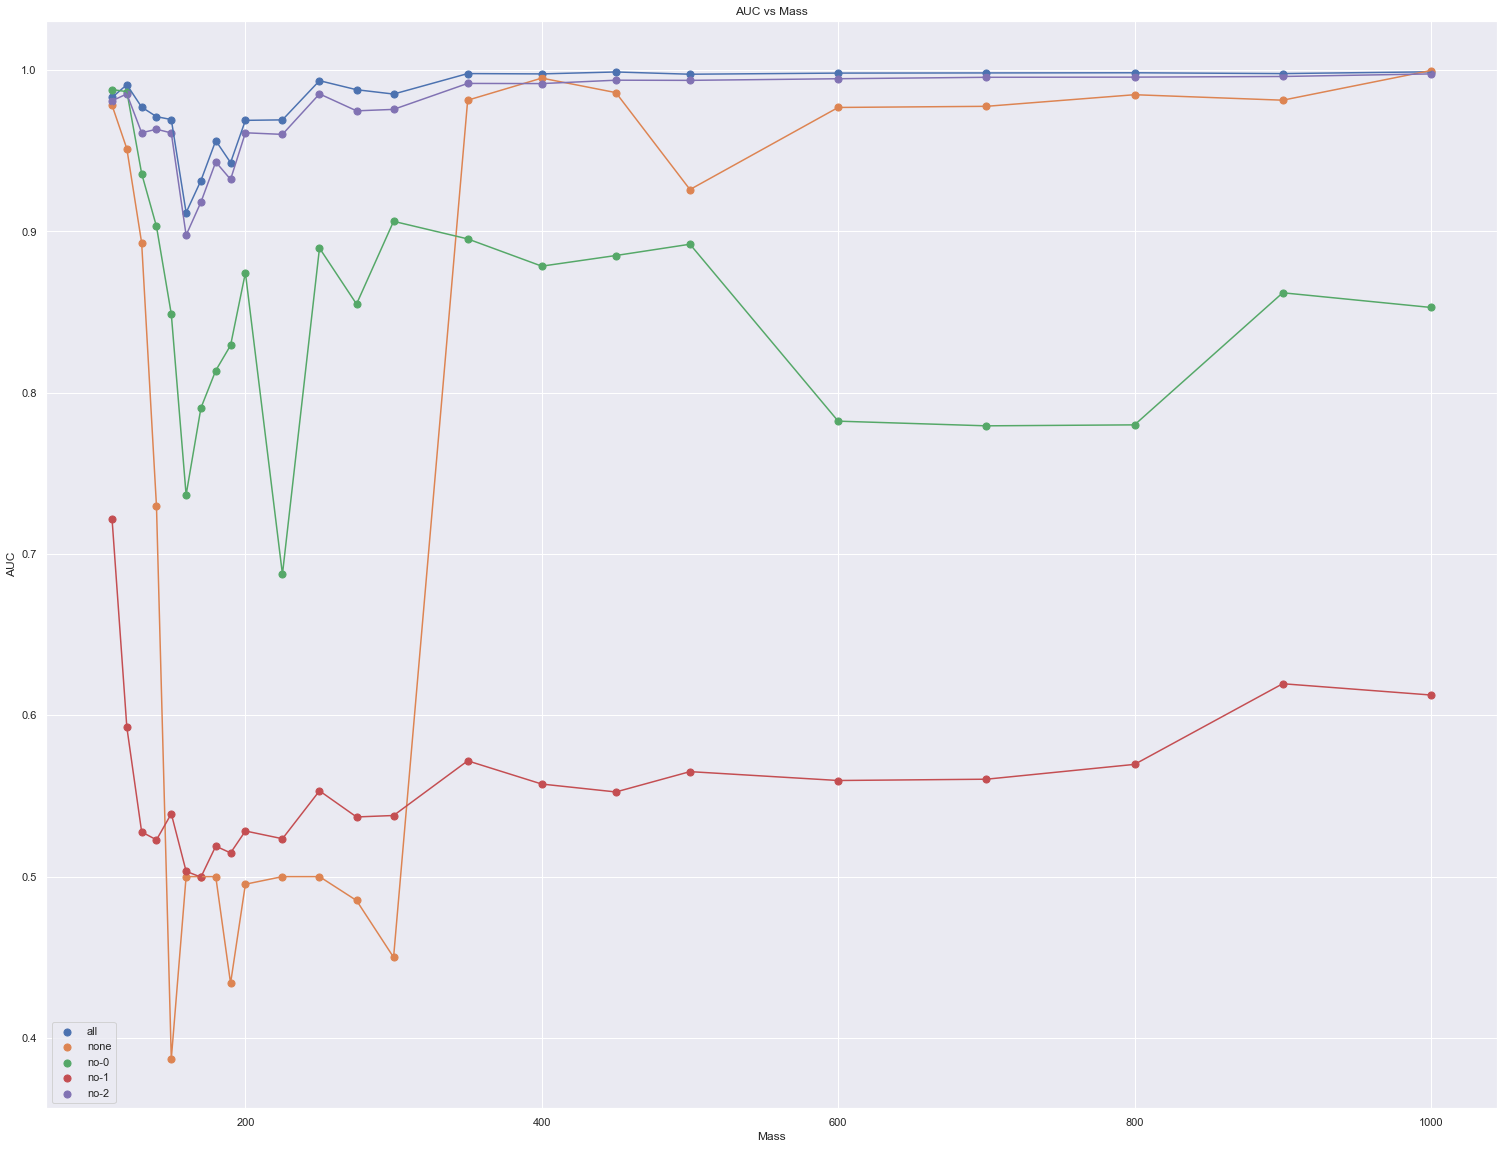

In [36]:
_ = auc_vs_mass_no_features(affine, data, features=features[0], verbose=0, silent=True)

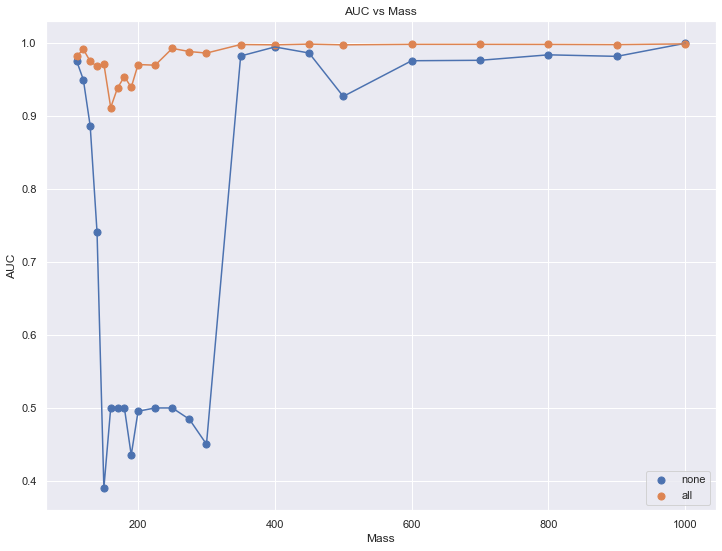

{'none': [0.9761,
  0.9499,
  0.8865,
  0.7412,
  0.3902,
  0.5,
  0.5,
  0.5,
  0.4354,
  0.4955,
  0.5,
  0.5,
  0.4845,
  0.4503,
  0.9824,
  0.9948,
  0.9865,
  0.927,
  0.9759,
  0.9765,
  0.984,
  0.9819,
  0.9998],
 'all': [0.9819,
  0.9915,
  0.9752,
  0.9681,
  0.9715,
  0.9118,
  0.9386,
  0.9542,
  0.9394,
  0.9707,
  0.9698,
  0.9928,
  0.9885,
  0.9864,
  0.9981,
  0.9977,
  0.9987,
  0.9977,
  0.9984,
  0.9984,
  0.9983,
  0.998,
  0.999]}

In [39]:
auc_vs_mass_no_features(affine, data, features=dict(none=features[0]['none'],
                                                        all=features[0]['all']), 
                        verbose=0, silent=True, figsize=(12, 9))

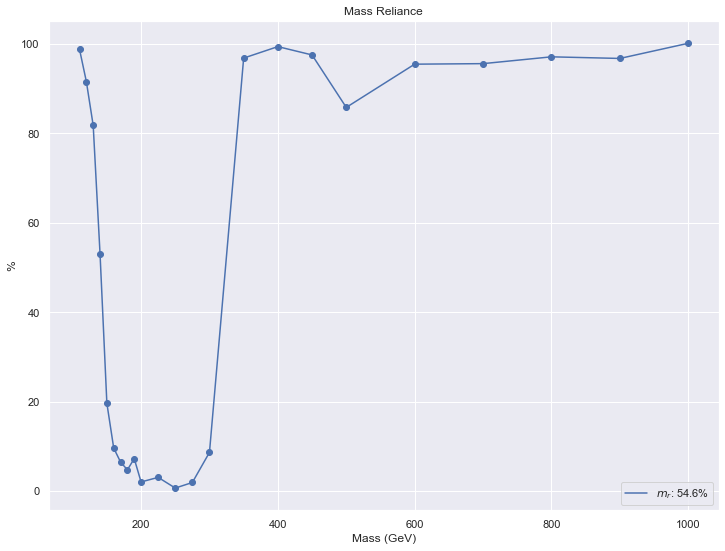

In [32]:
none = np.array([0.9761,0.9499,0.8865,0.7412,0.3902,0.5,0.5,0.5,0.4354,0.4955,0.5,0.5,
        0.4845,0.4503,0.9824,0.9948,0.9865,0.927,0.9759,0.9765,0.984,0.9819, 0.9998])

all = np.array([0.9819,0.9915,0.9752,0.9681,0.9715,0.9118,0.9386,0.9542,0.9394,0.9707,0.9698,
       0.9928,0.9885,0.9864,0.9981,0.9977,0.9987,0.9977,0.9984,0.9984,0.9983,0.998,0.999])

metric = 200 * np.abs(none / all - 0.5)

plt.figure(figsize=(12, 9))
plt.title('Mass Reliance')
plt.xlabel('Mass (GeV)')
plt.ylabel('%')

# plt.plot(data.unique_signal_mass, 200 * np.abs(none - 0.5), label='$m_{r1}$')

ax = plt.plot(data.unique_signal_mass, metric, label=r'$m_{r}$' + f': {np.round(np.mean(metric), 1)}%')
plt.scatter(data.unique_signal_mass, metric, color=ax[-1].get_color())


_ = plt.legend(loc='lower right')

---
AUC comparison: NN vs PNN vs AffinePNN

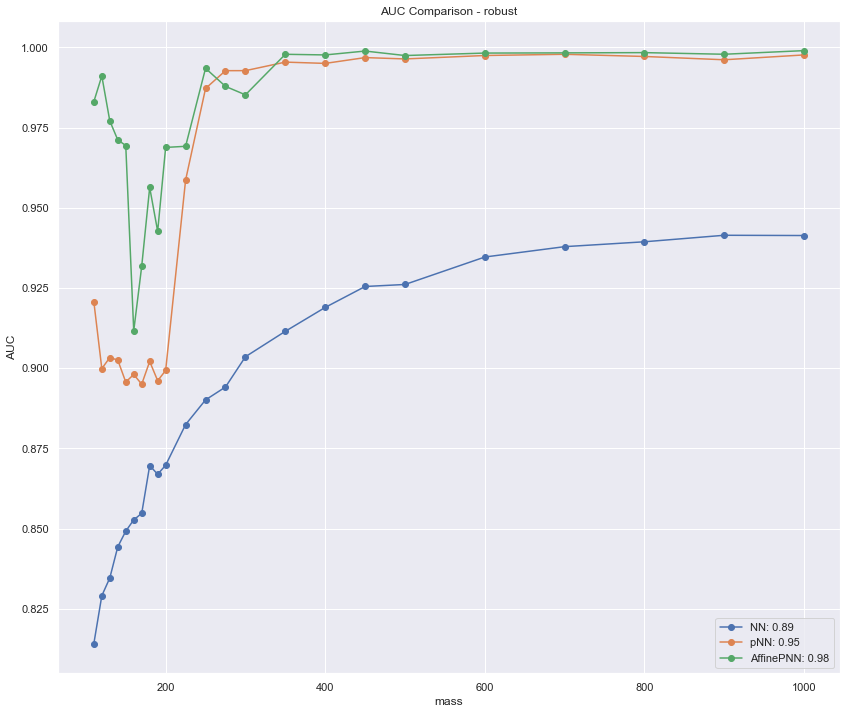

In [28]:
compare_plot(mass=data.unique_signal_mass,
             title='AUC Comparison - robust',
             NN=[0.8141 , 0.82904, 0.83457, 0.84429, 0.84917, 0.85269, 0.85473,
                 0.86963, 0.86691, 0.86973, 0.88241, 0.8901 , 0.89412, 0.90356,
                 0.91149, 0.91894, 0.92546, 0.92609, 0.93465, 0.93788, 0.9394 ,
                 0.94143, 0.94135],
             pNN=[0.92071, 0.89985, 0.9033 , 0.90252, 0.89568, 0.89802, 0.895  ,
                  0.90208, 0.89609, 0.89927, 0.95864, 0.9872 , 0.99275, 0.99276,
                  0.99542, 0.99502, 0.99683, 0.99641, 0.99748, 0.99786, 0.99718,
                  0.99615, 0.99766],
             AffinePNN=[0.98309, 0.9911 , 0.97709, 0.97116, 0.96942, 0.91162, 0.93177,
                        0.95634, 0.94267, 0.96882, 0.96917, 0.99349, 0.98785, 0.98522,
                        0.99786, 0.99766, 0.99887, 0.99747, 0.99824, 0.9983 , 0.99838,
                        0.99787, 0.999 ], size=(14, 12))

## Dataset [`bkg = sig`]

In [25]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load(change_bkg_mass=True)

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] setting bkg = sig...
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


In [ ]:
def plot_significance(model, dataset: Dataset, bins=20, name='Model', sample_frac=None, 
                      size=4, ams_eq=2):
    def safe_div(a, b):
        if b == 0.0:
            return 0.0
        
        return a / b

    fig, axes = plt.subplots(ncols=4, nrows=6)
    axes = np.reshape(axes, newshape=[-1])
    
    fig.set_figwidth(int(size * 5))
    fig.set_figheight(int(size * 5))
    
    plt.suptitle(f'[Dataset] {name}\'s Output Distribution + Significance', 
                 y=1.02, verticalalignment='top')
    
    for i, interval in enumerate(dataset.current_mass_intervals + [None]):
        ax = axes[i]
        
        if interval is None:
            x, y = dataset.get(sample=sample_frac)
            title = 'Total'
        else:
            x, y = dataset.get_by_mass(interval, sample=sample_frac)
            title = f'{int(np.mean(interval))} GeV'
            
        out = model.predict(x, batch_size=128, verbose=0)
        out = np.asarray(out)
        
        sig_mask = y == 1.0
        bkg_mask = y == 0.0
        
        cuts = np.linspace(0.0, 1.0 + 1e-7, num=bins)
        ams = []
        
        bx = ax.twinx()
        
        ax.hist(out[sig_mask], bins=bins, alpha=0.55, label='sig', color='blue', edgecolor='blue')
        ax.hist(out[bkg_mask], bins=bins, alpha=0.7, label='bkg', color='red', histtype='step', 
                hatch='//', linewidth=2, edgecolor='red')
        
        for i in range(len(cuts) - 1):
            lo, up = cuts[i], cuts[i + 1]
            
            cut_mask = (out >= lo) & (out < up)
            
            # select signals and bkg
            s = out[sig_mask & cut_mask].shape[0]
            b = out[bkg_mask & cut_mask].shape[0]
        
            # compute approximate median significance (AMS)
            if ams_eq == 1:
                val = np.sqrt(2 * ((s + b) * np.log(1 + safe_div(s, b)) - s))
            elif ams_eq == 2:
                val = safe_div(s, np.sqrt(s + b))
            else:
                val = safe_div(s, np.sqrt(b))
            
            ams.append(val)
            
        k = np.argmax(ams)
        
        bx.grid(False)
        bx.plot(cuts, [0.0] + ams, color='g', label='Significance')
        
        ax.axvline(x=cuts[k + 1], linestyle='--', linewidth=2, color='g',
                   label=f'{round(cuts[k + 1], 1)}: {round(ams[k], 1)}')
        
        bx.set_ylabel('Significance')
        ax.set_title(title)
        ax.set_xlabel('Probability')
        ax.set_ylabel('Num. Events')
        
        ax.legend(loc='best')
    
    fig.tight_layout()


### NN

In [50]:
model, checkpoint = utils.get_compiled_non_parametric(data, save='tom/baseline-nn-bkg', 
                                                      lr=3e-4)

In [51]:
model.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 83.57, AUC: 91.64

Epoch 1/20
21410/21410 [==============================] - 89s 4ms/step - loss: 0.4043 - binary_accuracy: 0.8170 - auc: 0.8974 - precision: 0.7687 - recall: 0.8291 - lr: 3.0000e-04 - grad-norm: 2.1376 - weight-norm: 24.8916 - reg-losses: 0.0000e+00 - val_loss: 0.3886 - val_binary_accuracy: 0.8221 - val_auc: 0.9072 - val_precision: 0.8098 - val_recall: 0.7727
Epoch 2/20
21410/21410 [==============================] - 86s 4ms/step - loss: 0.4388 - binary_accuracy: 0.8276 - auc: 0.9080 - precision: 0.7810 - recall: 0.8392 - lr: 3.0000e-04 - grad-norm: 2.3880 - weight-norm: 33.0777 - reg-losses: 0.0000e+00 - val_loss: 0.3879 - val_binary_accuracy: 0.8237 - val_auc: 0.9065 - val_precision: 0.7975 - val_recall: 0.7974
Epoch 3/20
21410/21410 [==============================] - 88s 4ms/step - loss: 0.3543 - binary_accuracy: 0.8311 - auc: 0.9113 - precision: 0.7850 - recall: 0.8426 - lr: 3.0000e-04 - grad-norm: 2.2822 - weight-norm: 40.4738 - reg-losses: 0.0000e+00 - val_loss: 0.3671 - val_binary_

In [52]:
utils.load_from_checkpoint(model, path='tom/baseline-nn-bkg')

Loaded from "weights\tom/baseline-nn-bkg\weights-20-0.916"


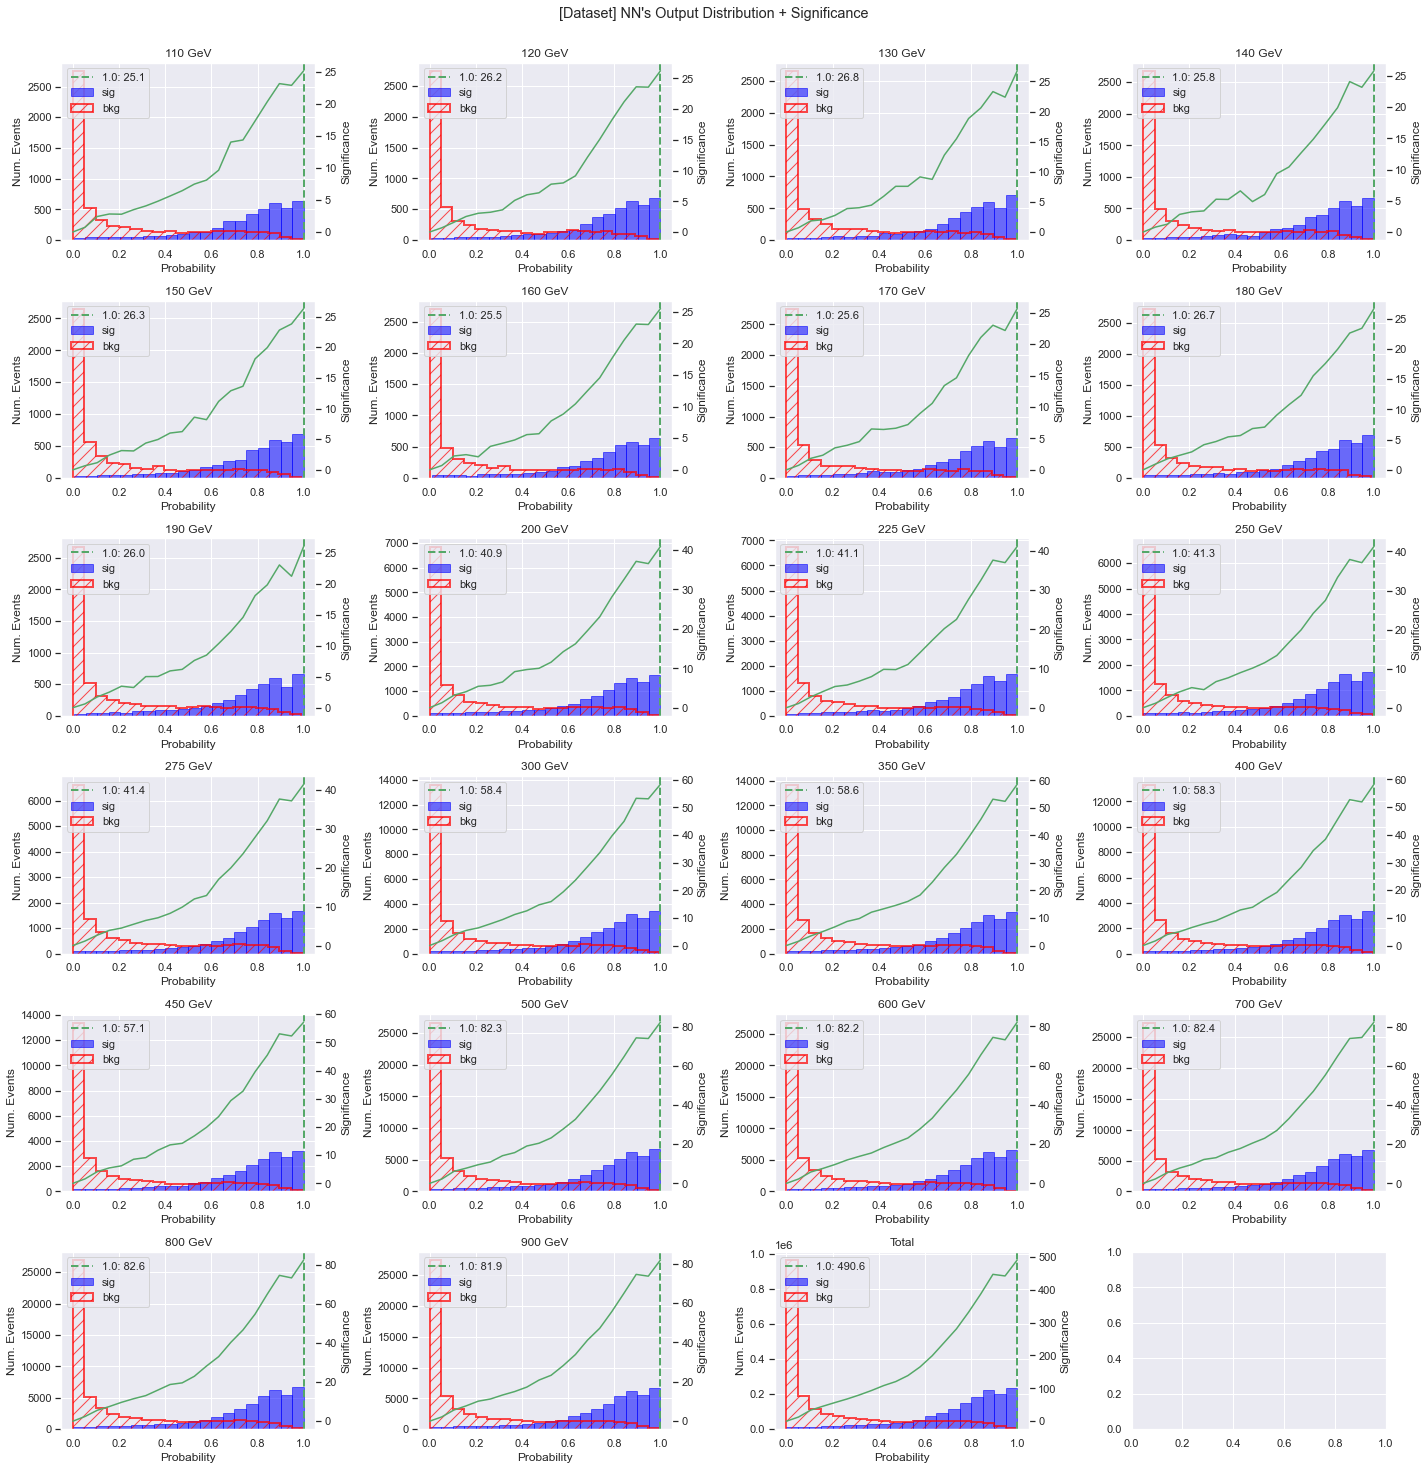

In [53]:
plot_significance(model, data, name='NN')

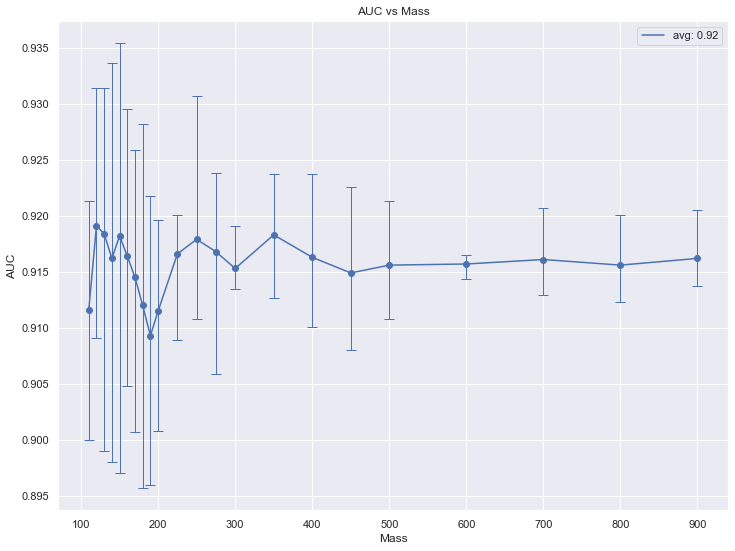

array([0.91164, 0.9191 , 0.91841, 0.91616, 0.91822, 0.91642, 0.91448,
       0.91196, 0.90931, 0.91152, 0.91661, 0.91789, 0.91677, 0.91525,
       0.91834, 0.9163 , 0.91487, 0.91558, 0.91567, 0.91609, 0.91563,
       0.91617])

In [54]:
auc_with_error(model, data, verbose=0, silent=True)

### PNN

In [32]:
model, checkpoint = utils.get_compiled_pnn(data, save='tom/baseline-pnn-bkg', lr=3e-4,
                                           track_mass_reliance=True)

In [33]:
model.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 83.58, AUC: 91.64

Epoch 1/20
21410/21410 [==============================] - 129s 6ms/step - loss: 0.4111 - binary_accuracy: 0.8159 - auc: 0.8961 - precision: 0.7666 - recall: 0.8297 - lr: 3.0000e-04 - grad-norm: 1.8387 - weight-norm: 24.6336 - reg-losses: 0.0000e+00 - mass-reliance: 0.0169 - val_loss: 0.3886 - val_binary_accuracy: 0.8212 - val_auc: 0.9061 - val_precision: 0.8077 - val_recall: 0.7733
Epoch 2/20
21410/21410 [==============================] - 121s 6ms/step - loss: 0.4211 - binary_accuracy: 0.8267 - auc: 0.9070 - precision: 0.7798 - recall: 0.8384 - lr: 3.0000e-04 - grad-norm: 1.8824 - weight-norm: 32.6546 - reg-losses: 0.0000e+00 - mass-reliance: 0.0648 - val_loss: 0.3917 - val_binary_accuracy: 0.8211 - val_auc: 0.9056 - val_precision: 0.8008 - val_recall: 0.7839
Epoch 3/20
21410/21410 [==============================] - 122s 6ms/step - loss: 0.3635 - binary_accuracy: 0.8301 - auc: 0.9103 - precision: 0.7841 - recall: 0.8413 - lr: 3.0000e-04 - grad-norm: 1.7951 - weight-norm: 41.0318 - reg-

In [34]:
utils.load_from_checkpoint(model, path='tom/baseline-pnn-bkg')

Loaded from "weights\tom/baseline-pnn-bkg\weights-20-0.916"


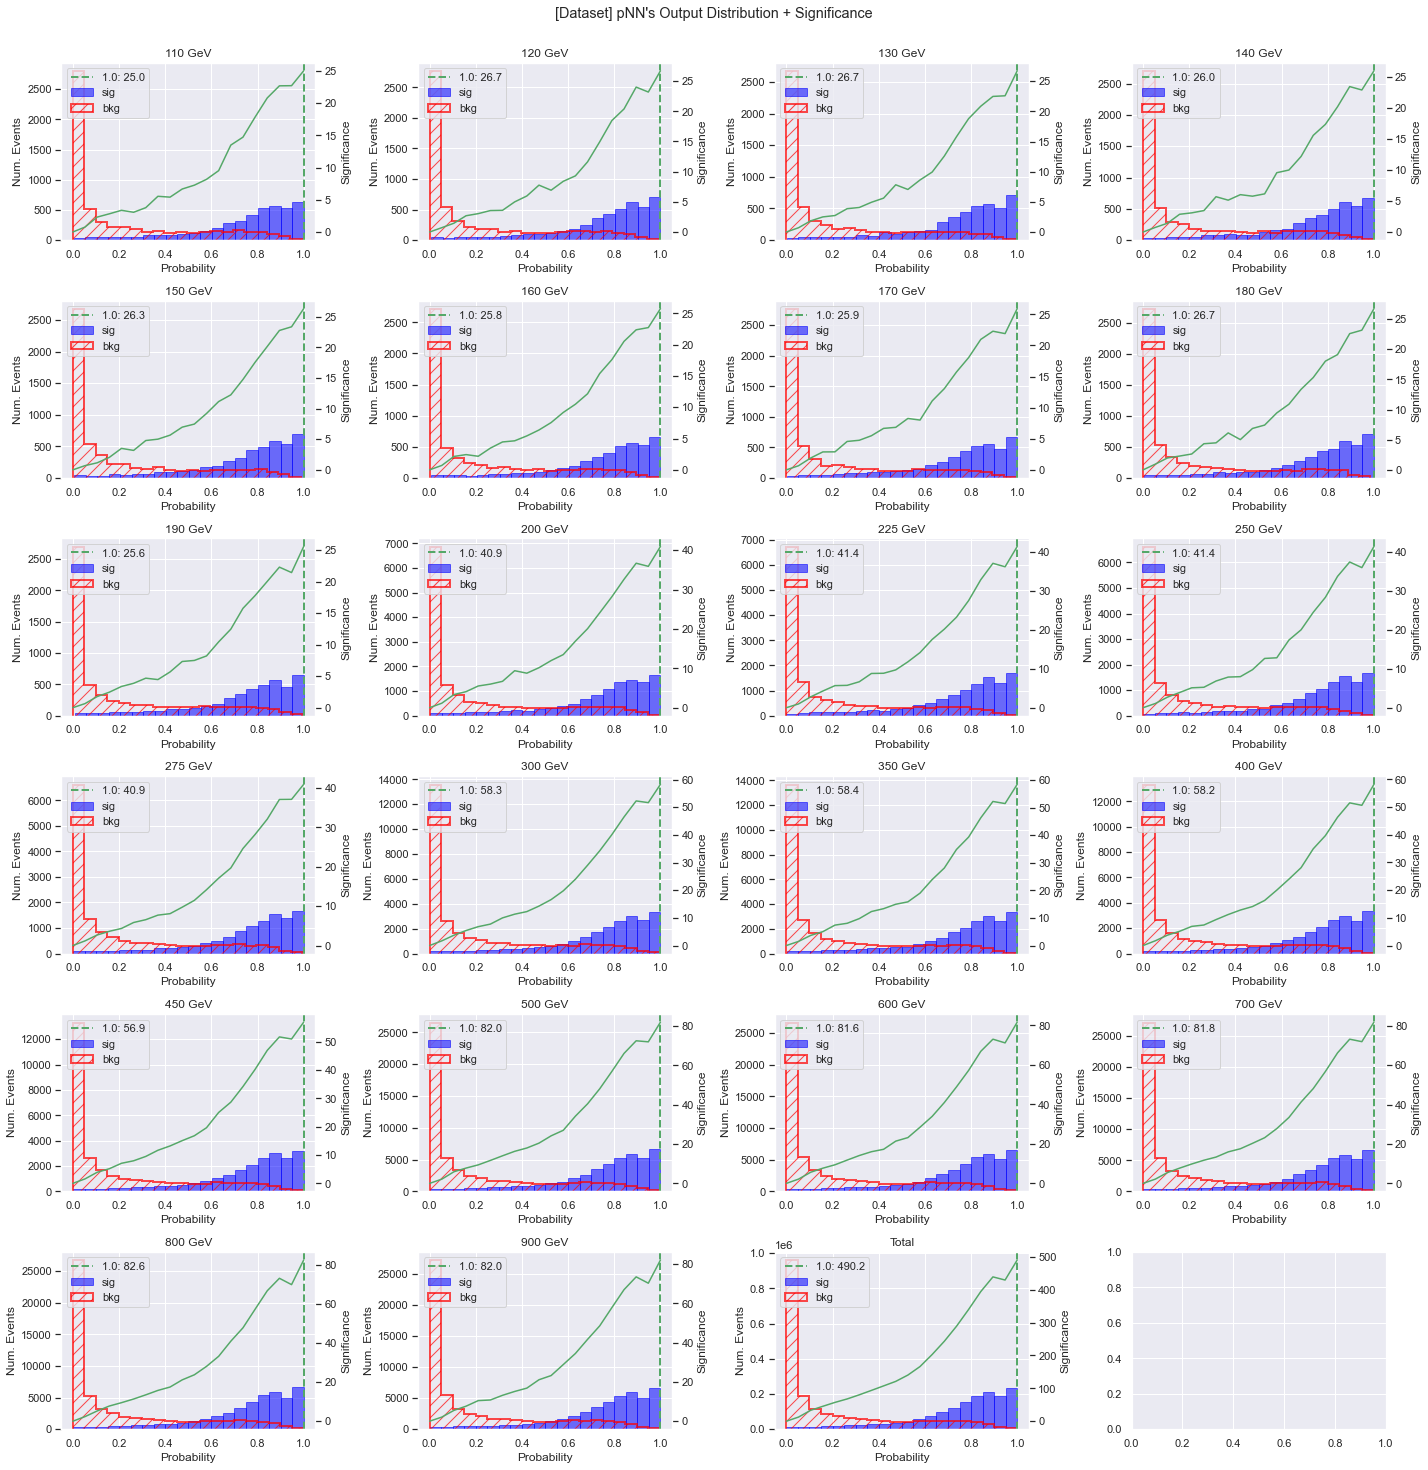

In [43]:
plot_significance(model, data, name='pNN')

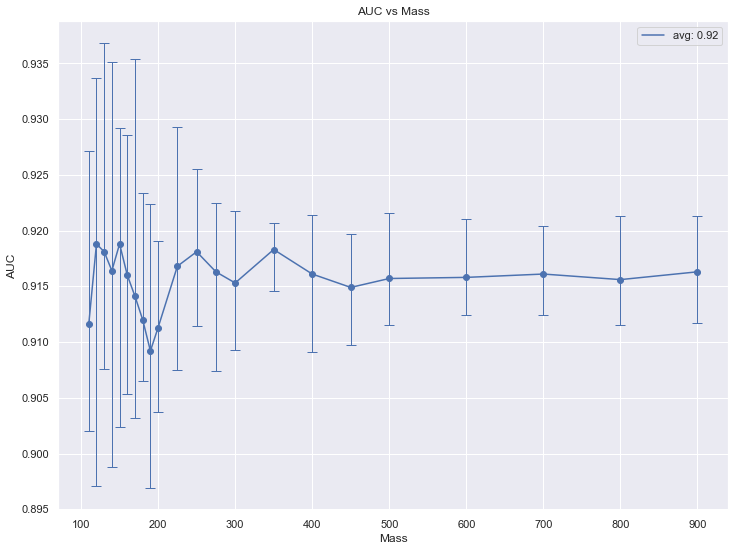

array([0.91158, 0.91876, 0.91811, 0.91638, 0.9188 , 0.91602, 0.91407,
       0.91195, 0.90923, 0.9113 , 0.91681, 0.91812, 0.9163 , 0.91534,
       0.91827, 0.91607, 0.91487, 0.91567, 0.91575, 0.91607, 0.91564,
       0.91631])

In [44]:
auc_with_error(model, data, verbose=0, silent=True)

### AffinePNN

In [45]:
model, checkpoint = utils.get_compiled_affine(data, save='tom/baseline-affine-bkg', 
                                              lr=3e-4, track_mass_reliance=True)

In [46]:
model.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 83.51, AUC: 91.62

Epoch 1/20
21410/21410 [==============================] - 153s 7ms/step - loss: 0.4444 - binary_accuracy: 0.8017 - auc: 0.8826 - precision: 0.7610 - recall: 0.7936 - cls-loss: 0.4231 - lr: 3.0000e-04 - grad-norm: 1.0361 - weight-norm: 33.8144 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0715 - val_loss: 0.4018 - val_binary_accuracy: 0.8141 - val_auc: 0.8978 - val_precision: 0.7949 - val_recall: 0.7720
Epoch 2/20
21410/21410 [==============================] - 150s 7ms/step - loss: 0.4170 - binary_accuracy: 0.8195 - auc: 0.9000 - precision: 0.7727 - recall: 0.8292 - cls-loss: 0.3919 - lr: 3.0000e-04 - grad-norm: 1.4093 - weight-norm: 42.4785 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - mass-reliance: 0.0088 - val_loss: 0.3940 - val_binary_accuracy: 0.8187 - val_auc: 0.9020 - val_precision: 0.7918 - val_recall: 0.791420 - lr: 3.0000e-04 - grad-norm: 1.4057 - weight-norm: 42.3287 - reg-lo
Epoch 3/20
21410/21410 [==============================] - 1

* **Mass reliance** is low.

In [47]:
utils.load_from_checkpoint(model, path='tom/baseline-affine-bkg')

Loaded from "weights\tom/baseline-affine-bkg\weights-20-0.916"


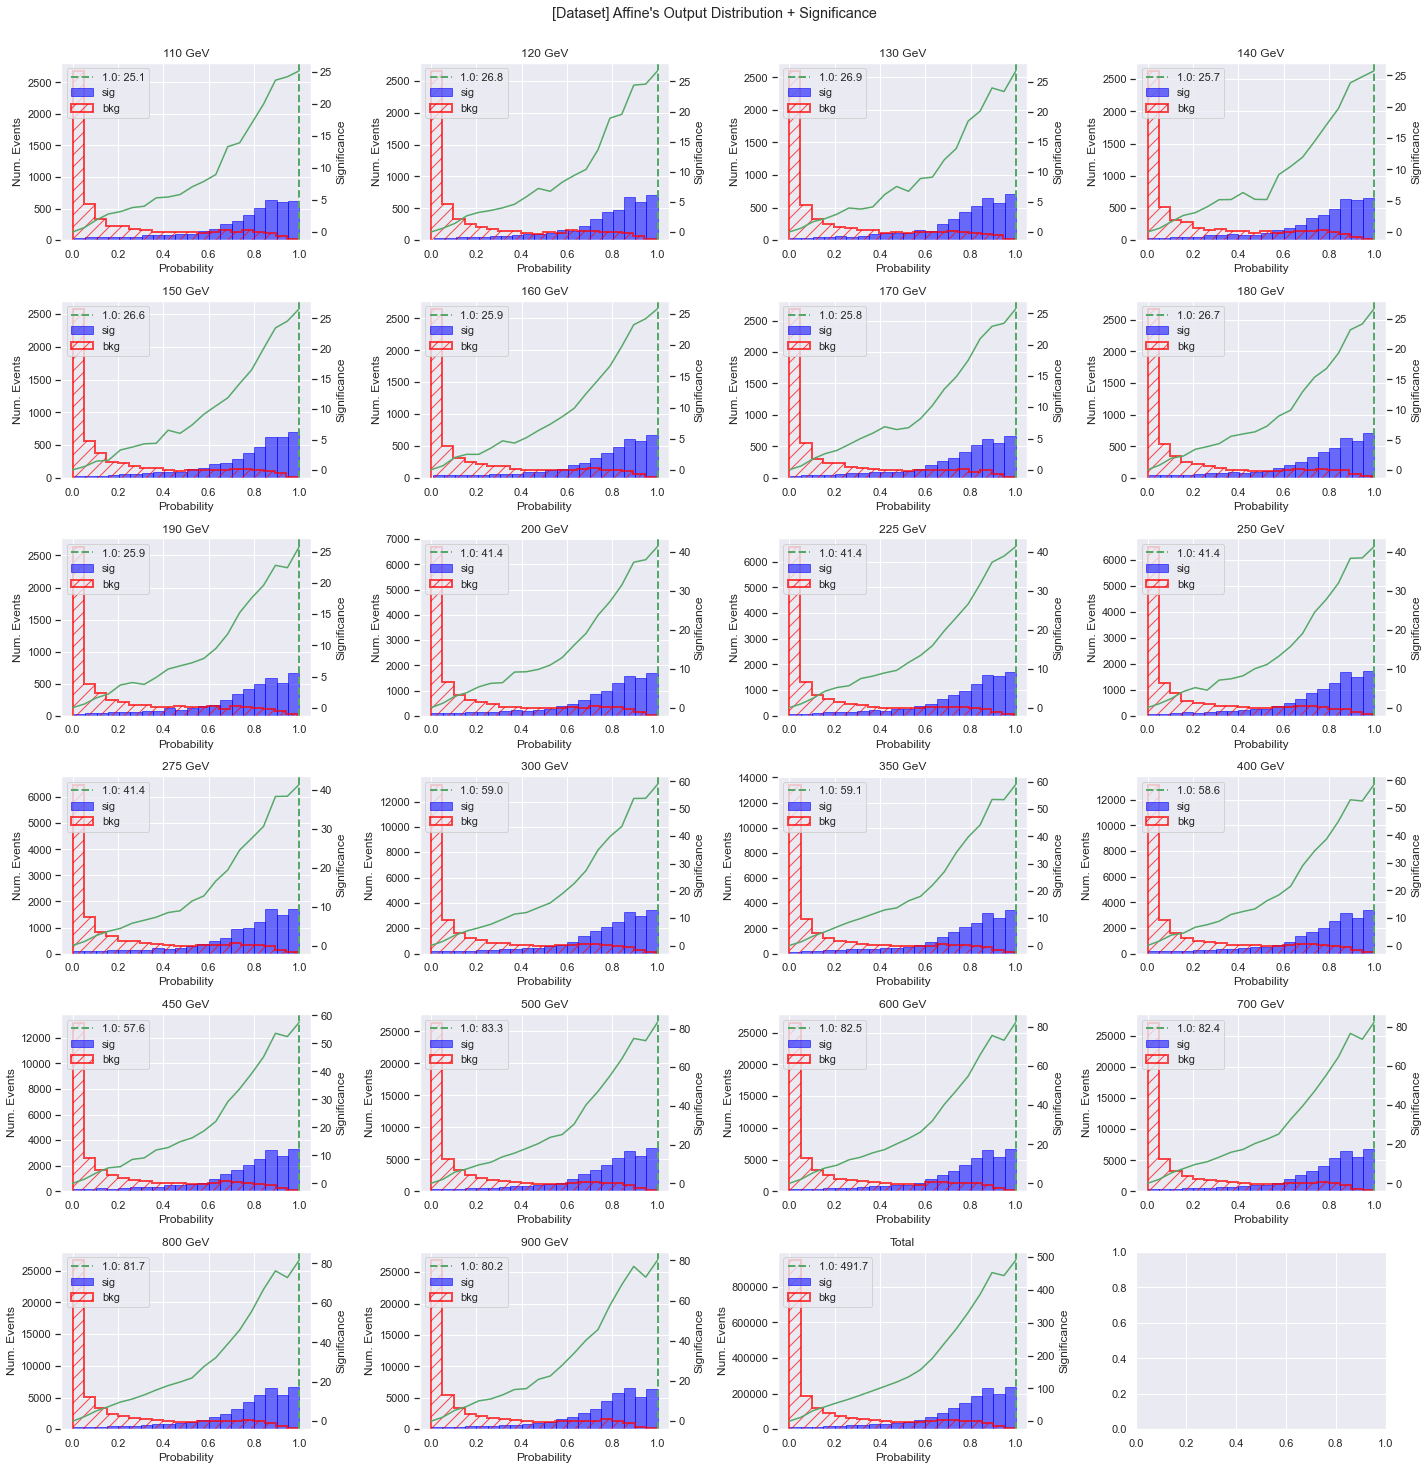

In [48]:
plot_significance(model, data, name='Affine')

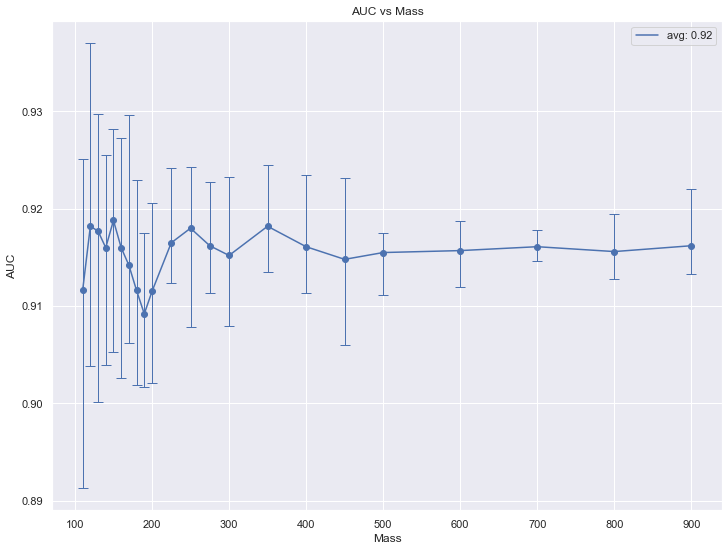

array([0.91163, 0.9182 , 0.91769, 0.91599, 0.9188 , 0.91604, 0.91423,
       0.91164, 0.90924, 0.91154, 0.91653, 0.91796, 0.91623, 0.91517,
       0.9182 , 0.91609, 0.91478, 0.9155 , 0.9157 , 0.91611, 0.91559,
       0.91622])

In [49]:
auc_with_error(model, data, verbose=0, silent=True)

---

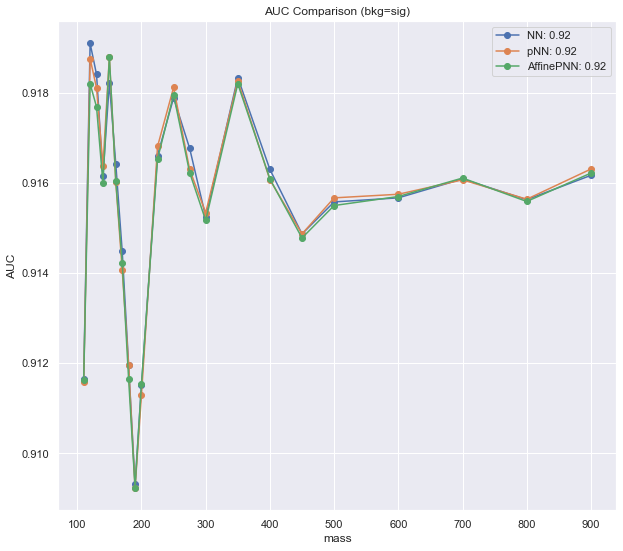

In [55]:
compare_plot(mass=data.unique_signal_mass[:-1],
             title='AUC Comparison (bkg=sig)',
             NN=[0.91164, 0.9191 , 0.91841, 0.91616, 0.91822, 0.91642, 0.91448,
                 0.91196, 0.90931, 0.91152, 0.91661, 0.91789, 0.91677, 0.91525,
                 0.91834, 0.9163 , 0.91487, 0.91558, 0.91567, 0.91609, 0.91563, 0.91617],
             pNN=[0.91158, 0.91876, 0.91811, 0.91638, 0.9188 , 0.91602, 0.91407,
                  0.91195, 0.90923, 0.9113 , 0.91681, 0.91812, 0.9163 , 0.91534,
                  0.91827, 0.91607, 0.91487, 0.91567, 0.91575, 0.91607, 0.91564, 0.91631],
             AffinePNN=[0.91163, 0.9182 , 0.91769, 0.91599, 0.9188 , 0.91604, 0.91423,
                        0.91164, 0.90924, 0.91154, 0.91653, 0.91796, 0.91623, 0.91517,
                        0.9182 , 0.91609, 0.91478, 0.9155 , 0.9157 , 0.91611, 0.91559, 0.91622])

* Exactly **same performance**: no advantage of parametrization; could be due to the fact that predicted mass by inverse model is always 345-350 GeV...

## PNN

In [ ]:
model, checkpoint = utils.get_compiled_affine(data, save='tom/baseline-pnn-sample',
                                              mass=data.scale_mass(data.unique_signal_mas),
                                              lr=3e-4, track_mass_reliance=True)

## Dataset [sample *bkg* mass from *sig*]

In [2]:
data = Dataset(x_scaler=MinMaxScaler(), m_scaler=MinMaxScaler())
data.load()

free_mem()
x_train, y_train = data.get()

[signal] loading...
[background] loading...
[Dataset] fitting feature scaler..
[Dataset] fitting mass scaler..
[Dataset] loaded.


### Affine

In [3]:
model, checkpoint = utils.get_compiled_affine(data, save='tom/baseline-affine-sample',
                                              mass=data.scale_mass(data.unique_signal_mass),
                                              lr=3e-4, track_mass_reliance=True)

In [4]:
model.fit(x=x_train, y=y_train, batch_size=128, validation_split=VAL_SPLIT, 
          epochs=NUM_EPOCHS, callbacks=[checkpoint])

# Accuracy: 95.85, AUC: 99.26

Epoch 1/20
21410/21410 [==============================] - 151s 7ms/step - loss: 0.4397 - binary_accuracy: 0.8189 - auc: 0.9000 - precision: 0.7772 - recall: 0.8182 - cls-loss: 0.3916 - lr: 3.0000e-04 - grad-norm: 1.3531 - weight-norm: 35.9346 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - ams: 0.0024 - mass-reliance: 0.0743 - val_loss: 0.3524 - val_binary_accuracy: 0.8428 - val_auc: 0.9206 - val_precision: 0.8079 - val_recall: 0.8385
Epoch 2/20
21410/21410 [==============================] - 151s 7ms/step - loss: 0.3379 - binary_accuracy: 0.8474 - auc: 0.9250 - precision: 0.7994 - recall: 0.8666 - cls-loss: 0.3394 - lr: 3.0000e-04 - grad-norm: 2.0302 - weight-norm: 52.7354 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - ams: 1.3485e-04 - mass-reliance: 0.0836 - val_loss: 0.3226 - val_binary_accuracy: 0.8570 - val_auc: 0.9326 - val_precision: 0.8120 - val_recall: 0.8741
Epoch 3/20
21410/21410 [==============================] - 155s 7ms/step - loss: 0.2412 - binary_ac

21410/21410 [==============================] - 120s 6ms/step - loss: 0.0840 - binary_accuracy: 0.9591 - auc: 0.9915 - precision: 0.9386 - recall: 0.9694 - cls-loss: 0.1067 - lr: 3.0000e-04 - grad-norm: 15.5928 - weight-norm: 129.8451 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - ams: 5.9109e-04 - mass-reliance: 0.5490 - val_loss: 0.1064 - val_binary_accuracy: 0.9586 - val_auc: 0.9916 - val_precision: 0.9424 - val_recall: 0.9640
Epoch 20/20
21410/21410 [==============================] - 128s 6ms/step - loss: 0.0678 - binary_accuracy: 0.9600 - auc: 0.9917 - precision: 0.9397 - recall: 0.9702 - cls-loss: 0.1045 - lr: 3.0000e-04 - grad-norm: 15.3829 - weight-norm: 131.5463 - reg-losses: 0.0000e+00 - adversarial-loss: 0.0000e+00 - ams: 5.4265e-04 - mass-reliance: 0.5317 - val_loss: 0.1240 - val_binary_accuracy: 0.9535 - val_auc: 0.9897 - val_precision: 0.9438 - val_recall: 0.9498


In [5]:
utils.load_from_checkpoint(model, path='tom/baseline-affine-sample')

Loaded from "weights\tom/baseline-affine-sample\weights-16-0.993"


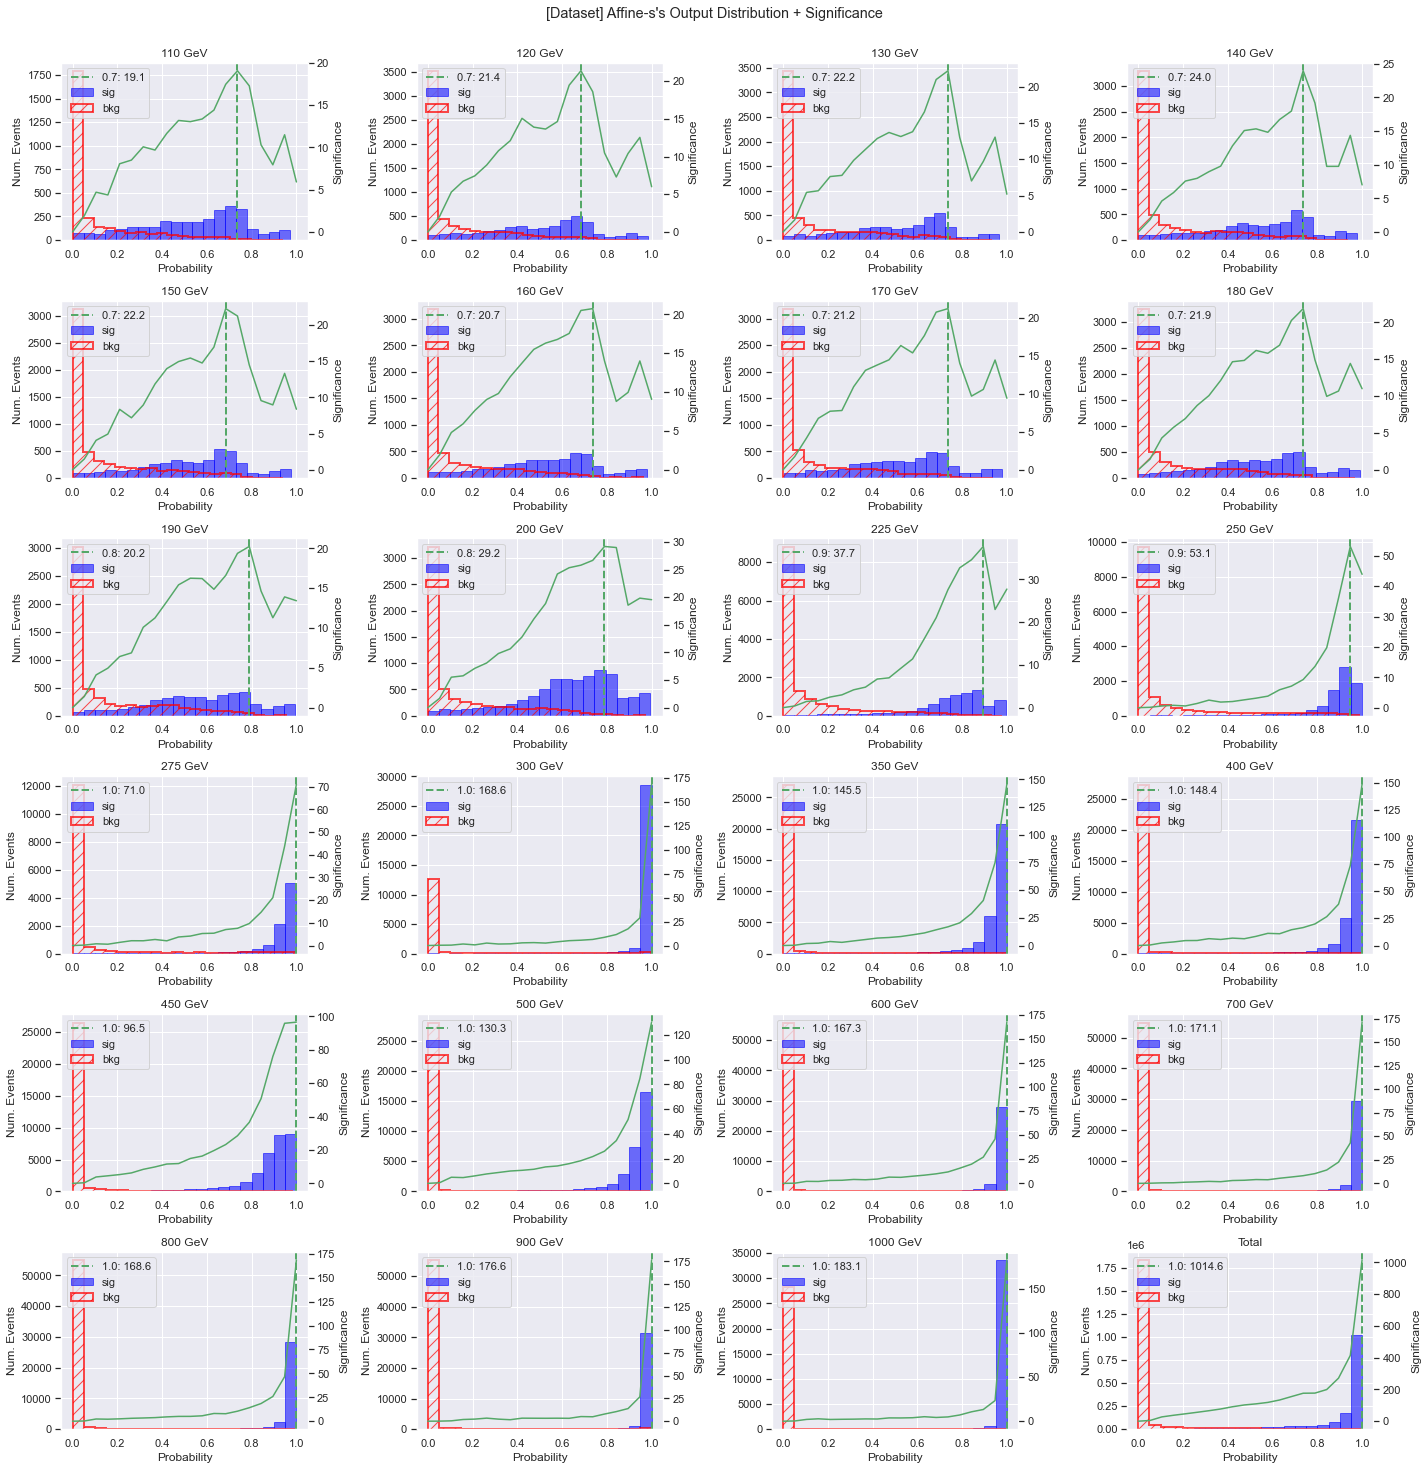

In [10]:
plot_significance(model, data, name='Affine-s')

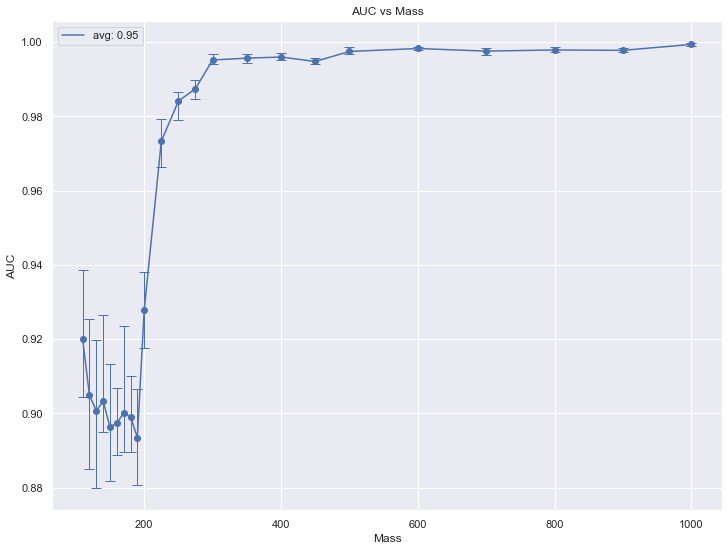

array([0.91998, 0.90487, 0.90065, 0.90331, 0.89628, 0.89736, 0.90012,
       0.89911, 0.8935 , 0.92781, 0.97327, 0.98414, 0.98752, 0.99519,
       0.99572, 0.99603, 0.99478, 0.99754, 0.99827, 0.99758, 0.99789,
       0.99781, 0.99939])

In [11]:
auc_with_error(model, data, verbose=0, silent=True)